In [1]:
# coding:utf-8
import math
import numpy
import jieba
import jieba.analyse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cPickle as pkl
import re
import os
import tqdm
import codecs
import fasttext
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer  
%matplotlib inline
print "done"

done


# 1.数据处理

## 加载分词

In [2]:
# 停用词加载
import codecs
stopwords = []
with codecs.open('./stopwords_full.txt', 'r', 'utf-8') as f:
    stopwords = [i.rstrip() for i in f.readlines()]
    
# 新加停用词，使用tf-idf筛选
# with codecs.open('./stopwords_new.txt', 'r', 'utf-8') as f:
#     stopwords += [i.rstrip() for i in f.readlines()]
stopwords.append(' ')
stopwords.append(u'\x1d')
print('停用词个数：{}'.format(len(stopwords)))

stopwords_dict = dict(zip(stopwords, range(len(stopwords))))

# 结巴字典加载
jieba.load_userdict('./medical_jieba.dic')
print "done"

Building prefix dict from the default dictionary ...
Loading model from cache /mnt/d/work/appointment/appointment-code/jieba.cache


停用词个数：1896


Loading model cost 0.607 seconds.
Prefix dict has been built succesfully.


done


## 处理数据

In [3]:
# 读取数据，分词，储存
des_list = list()

with codecs.open('../data/traindata_all_processed.txt', 'rb', 'utf-8') as f:
    contents = f.readlines()
for line in tqdm.tqdm(contents):
    line_s = line.split('\t')
    if len(line_s) < 2:
        continue
    des = line_s[0]
    depart = line_s[1].strip()
    
    des_jieba = jieba.cut_for_search(des)
    des_final = u' '.join([j for j in des_jieba if (not stopwords_dict.has_key(j)) 
                              and (re.search(pattern=u'[\u4e00-\u9fa5]+', string=j))])
    # 分词后，疾病描述不能为空
    if not des_final=='':
        des_list.append((depart, des_final))
        
# 存储
with codecs.open('../data/search_appointments_split_raw.txt', 'wb', 'utf-8') as f:
    for (label, des) in des_list:
        w = u'{}\t{}\n'.format(label, des)
        f.write(w)
print ("分词数据保存成功")

100%|██████████| 246616/246616 [02:12<00:00, 1854.32it/s]


分词数据保存成功


In [4]:
# # 统计样本长度
# len_dict = dict()
# for label, des in des_list:
#     length = len(des.split(" "))
#     if len_dict.has_key(length):
#         len_dict[length] += 1
#     else:
#         len_dict[length] = 1
# for key in len_dict.keys():
#     print key, len_dict[key]

## 统计TF-IDF

In [5]:
# from collections import defaultdict

# alldata = defaultdict(list)

# with open("../data/search_appointments_split_raw.txt", 'rb') as f:
#     for aline in f.readlines():
#         lines = aline.split("\t")
#         alldata[lines[0]] += lines[1].split(' ')
        
# for key in alldata.keys():
#     alldata[key] = " ".join(alldata[key])
# vectorizer = CountVectorizer()
# transformer = TfidfTransformer()
# tfidf = transformer.fit_transform(vectorizer.fit_transform(alldata.values()))

# word = vectorizer.get_feature_names()
# print "done"

In [6]:
# threshhold = 400
# topDict = defaultdict(list)

# for i, key in enumerate(alldata.keys()):
#     # 筛选tf-idf高的词
#     sortIndex = (-tfidf[i].toarray()).argsort()[0]
#     for j, index in enumerate(sortIndex):
#         topDict[key].append(word[index])
#         if j == threshhold-1:
#             break
# # 打印看看
# # for key in topDict.keys():
# #     print "*"*40
# #     print key
# #     for word in topDict[key]:
# #         print word
# wordset = set([j for i in topDict.values() for j in i])
# count = dict()
# for aword in wordset:
#     count[aword] = 0
# for key, wordlist in topDict.items():
#     for aword in wordlist:
#         count[aword] += 1
# res = sorted(count.iteritems(), key=lambda item:item[1], reverse = True)
# for (a, b) in res:
#     print a
#     if b<30:
#         break

In [7]:
# cut_des_list = list()
# threshhold = 30
# with codecs.open('../data/search_appointments_split_raw.txt', 'rb', 'utf-8') as f:
#     for aline in f.readlines():
#         line = aline.split('\t')
#         depart = line[0]
#         des = line[1].split(' ')
#         length = len(des)
#         if length >= threshhold:
#             rem = length % 30
            

## 处理数据（替换相似词）

In [8]:
sub_dict = dict()
new_data = list()
with codecs.open('../word2vec/sub_dict.txt', 'rb', 'utf-8') as f:
    for line in f.readlines():
        line_s = line.split('\t')
        sub_word = line_s[0]
        sub_set = set(line_s[1].split(" "))
        sub_dict[sub_word] = sub_set

with codecs.open('../data/search_appointments_split_raw.txt', 'rb', 'utf-8') as f:
        contents = f.readlines()
        for line in tqdm.tqdm(contents):
            line_s = line.split('\t')
            department = line_s[0]
            description = line_s[1].split(" ")
            new_description = list()
            for aword in description:
                aword = aword.strip()
                found = False
                for sub_word in sub_dict.keys():
                    if aword in sub_dict[sub_word]:
                        new_description.append(sub_word)
                        found = True
                        break
                if not found:
                    new_description.append(aword)
            new_data.append((department, new_description))

            # 储存        
with codecs.open('../data/search_appointments_split.txt', 'wb', 'utf-8') as f:
    for (label, des) in new_data:
        des = [i.strip() for i in des]
        w = u'{}\t{}\n'.format(label, " ".join(des))
        f.write(w)
print "储存成功"

100%|██████████| 246206/246206 [26:50<00:00, 152.89it/s]


储存成功


# 2.筛选科室

## 二级科室

In [9]:
# 创建目录
if not os.path.exists('../data/depart'):
    os.makedirs('../data/depart')
if not os.path.exists('../data/depart_data'):
    os.makedirs('../data/depart_data')
if not os.path.exists('../data/model'):
    os.makedirs('../data/model')

In [10]:
# 二级科室划分训练集与数据集
def erji_department_s(deName):
    # 数据处理 分层 train/test
    SPLIT_RATE = 0.8
    label_index_list = list()
    with codecs.open('../data/depart_data/search_appointments_select_split_{}.txt'.format(deName), 'rb', 'utf-8') as f:
        contents = f.readlines()
        descrip_data = contents
        for line in contents:
            line_s = line.split('\t')
            label_index_list.append(line_s[0].encode('utf-8'))

    label_dict = dict()
    for index in range(len(label_index_list)):
        label = label_index_list[index]

        if label_dict.has_key(label):
            label_dict[label].append(index)
        else:
            label_dict.setdefault(label, [index])
    train_list = list()
    test_list = list()
    train_num_dict = dict()
    # 设置是否过采样
    over_sampling = False

    for index in range(len(label_dict.keys())):
        label_aim = '__label__'+str(index)

        llist = label_dict[label_aim]

        train_num_dict[label_aim] = int(SPLIT_RATE*len(llist))

    max_samp_num = max(train_num_dict.values())   

    print('二级科目数：{}'.format(len(label_dict.keys())))
    for index in range(len(label_dict.keys())):
        label_aim = '__label__'+str(index)
        llist = label_dict[label_aim]
        np.random.shuffle(llist)

        train_slen = train_num_dict[label_aim]
        for sindex in llist[:train_slen]:
            train_list.append(descrip_data[sindex])

        if over_sampling:
            over_count_need = (max_samp_num/train_slen-1)*train_slen
            over_count = 0
            over_indexs = np.random.randint(0, train_slen, over_count_need)
            for over_index in over_indexs:
                sindex = llist[over_index]
                train_list.append(descrip_data[sindex])

        for sindex in llist[train_slen:]:
            test_list.append(descrip_data[sindex])

    np.random.shuffle(train_list)
    np.random.shuffle(test_list)

    # 存储
    with codecs.open('../data/depart_data/search_appointments_split_train1_{}.txt'.format(deName), 'wb', 'utf-8') as f:
        for line in train_list:
            f.write(line)

    with codecs.open('../data/depart_data/search_appointments_split_test1_{}.txt'.format(deName), 'wb', 'utf-8') as f:
        for line in test_list:
            f.write(line)
            
    # 训练集字典生成，以及测试集合词筛选
    # 到时候做 低频词筛选
    with open('../data/depart_data/search_appointments_split_train1_{}.txt'.format(deName), 'rb') as f:
        train_contents = f.read()
        
    # 对训练集统计词
    train_countv = CountVectorizer()
    result_train_countv = train_countv.fit_transform([train_contents])

    train_vocabulary = train_countv.vocabulary_
    print('训练集词语数：{}'.format(len(train_countv.vocabulary_)))

    LESS_FRE_WORD = 0
    train_dictionary = list()

    #低频词筛选
    for word, value in train_vocabulary.iteritems():
        if result_train_countv[0, value] > LESS_FRE_WORD:
            train_dictionary.append(word.encode('utf-8'))

    print('低频词筛选后词语数：{}'.format(len(train_dictionary)))
    with codecs.open('../data/depart_data/word_dictionary_{}.txt'.format(deName), 'wb', 'utf-8') as f:
        for line in train_dictionary:
            f.write(line.decode('utf-8')+'\n')
    train_dictionary = dict(zip(train_dictionary, range(len(train_dictionary))))


    with open('../data/depart_data/search_appointments_split_test1_{}.txt'.format(deName), 'rb') as f:
        test_contents = f.read()
        
    # 对测试集统计词
    test_countv = CountVectorizer()
    result_test_countv = test_countv.fit_transform([test_contents])

    test_vocabulary = test_countv.vocabulary_
    print('测试集词语数：{}'.format(len(test_countv.vocabulary_))) 

    # 通过字典，分别对train数据集和test数据集筛选
    with open('../data/depart_data/search_appointments_split_train1_{}.txt'.format(deName), 'rb') as f:
        train_contents = f.readlines()
        print('筛选前训练集大小：{}'.format(len(train_contents)))
    with open('../data/depart_data/search_appointments_split_test1_{}.txt'.format(deName), 'rb') as f:
        test_contents = f.readlines()
        print('筛选前测试集大小：{}'.format(len(test_contents)))

    train_list = list()
    test_list = list()
    
    # 训练集
    for line in train_contents:
        line_s = line.split('\t')
        label = line_s[0]
        words = [i.strip() for i in line_s[1].split(' ')]
        words = [i for i in words if train_dictionary.has_key(i)]
        if len(words) != 0:
            train_list.append('{}\t{}'.format(label, ' '.join(words)))

    # 测试集
    for line in test_contents:
        line_s = line.split('\t')
        label = line_s[0]
        words = [i.strip() for i in line_s[1].split(' ')]
        words = [i for i in words if train_dictionary.has_key(i)]
        if len(words) != 0:
            test_list.append('{}\t{}'.format(label, ' '.join(words)))

    print('筛选后训练集大小：{}'.format(len(train_list)))
    print('筛选后测试集大小：{}'.format(len(test_list)))

    # 存储
    with codecs.open('../data/depart_data/search_appointments_split_train_{}.txt'.format(deName), 'wb', 'utf-8') as f:
        for line in train_list:
            f.write(line.decode('utf-8')+'\n')

    with codecs.open('../data/depart_data/search_appointments_split_test_{}.txt'.format(deName), 'wb', 'utf-8') as f:
        for line in test_list:
            f.write(line.decode('utf-8')+'\n')

In [11]:
# 二级科室模型训练
def fast_text_model(deName):           
    # set params
    with open('../data/depart_data/search_appointments_split_train_{}.txt'.format(deName), 'rb') as f:
        content = f.readlines()
        count = len(content)
    
    lr = 0.3
    epoch = int(100*math.sqrt(200000/count))
    bucket = int(math.sqrt((float(count)/200000))*2000000)
    print deName, count, lr, epoch, bucket
    keshi = deName
    input_file = '../data/depart_data/search_appointments_split_train_{}.txt'.format(keshi)
    output = '../data/model/app_model_{}'.format(keshi)
    dim=50
    loss= 'hs'
    lr_update_rate = 98
    ws = 5
    min_count=2
    neg = 2
    word_ngrams= 5
    thread=5
    silent=1
    label_prefix='__label__'

    # Train the classifier
    classifier_app = fasttext.supervised(input_file, output, dim=dim, lr=lr, epoch=epoch,
                                         lr_update_rate = lr_update_rate, loss = loss, neg = neg,
                                         min_count=min_count, word_ngrams=word_ngrams, bucket=bucket,
                                         thread=thread, silent=silent, label_prefix=label_prefix, ws=ws)


    result = classifier_app.test(input_file)
    print('Train:')
    print('P@1:', result.precision)
    print('R@1:', result.recall)
    print('Number of examples:', result.nexamples)

    test_result = classifier_app.test('../data/depart_data/search_appointments_split_test_{}.txt'.format(keshi), 1)
    print('Test:')
    print('P@1:', test_result.precision)
    print('R@1:', test_result.recall)
    print('Number of examples:', test_result.nexamples)

    labels_right = []
    texts = []
    with open('../data/depart_data/search_appointments_split_test_{}.txt'.format(keshi)) as fr:
        lines = fr.readlines()
    for line in lines:
        labels_right.append(line.split("\t")[0].rstrip().replace("__label__",""))
        texts.append(line.split("\t")[1].decode("utf-8"))
    #     print labels
    #     print texts
    #     break
    labels_predict = [e[0] for e in classifier_app.predict(texts)] #预测输出结果为二维形式
    # print labels_predict

    text_labels = list(set(labels_right))
    text_predict_labels = list(set(labels_predict))
    # print text_predict_labels
    # print text_labels

    A = dict.fromkeys(text_labels,0)  #预测正确的各个类的数目
    B = dict.fromkeys(text_labels,0)  #测试数据集中各个类的数目
    C = dict.fromkeys(text_labels,0)  #预测结果中各个类的数目
    for i in range(0,len(labels_right)):
        B[labels_right[i]] += 1
        C[labels_predict[i]] += 1
        if labels_right[i] == labels_predict[i]:
            A[labels_right[i]] += 1

    # print A 
    # print B
    # print C
    select_department_dict = pkl.load(open('../data/depart/department_{}.pkl'.format(keshi), 'rb'))
    select_de_tup = select_department_dict.items()
    new_dict = dict(zip([str(x[1]) for x in select_de_tup], [x[0] for x in select_de_tup]))

    rlist = list()
    #计算准确率，召回率，F值
    for key in B:
        if int(B[key]) == 0:
            r = 0
        else:
            r = round(A[key] / float(B[key]), 3)
        if int(C[key]) == 0:
            p = 0
        else:
            p = round(A[key] / float(C[key]), 3)
        if (p+r) == 0:
            f1 = 0
        else:
            f1 = round(p * r * 2 / (p + r), 3)
        rlist.append([key,new_dict.get(key),r,p,f1,int(B[key])])
#         print "%s:%s\tp:%f\tr:%f\tf:%f\t" % (key,new_dict.get(key),r,p,f1)
    rdataf = pd.DataFrame(rlist, columns=['Key', 'Department', 'Recall', 'Precision', 'F1', 'Support'])
    print(rdataf)

In [12]:
# 数据处理，根据一级科目筛选，并保存label对应关系
with codecs.open('../data/department_seg.txt', 'rb') as f:
    contents = f.readlines()
for line in contents:
    line_s = line.split('：')
    fdepart = line_s[0]
    sdepart_list = line_s[1].split('，')
    select_department = [i.strip() for i in sdepart_list]
    fdepart_name = line_s[2].strip()
    
    des_list = list()
    select_depart_dict = dict()

    with codecs.open('../data/search_appointments_split.txt', 'rb', 'utf-8') as f:
        contents = f.readlines()
        for line in contents:
            line_s = line.split('\t')
            department = line_s[0].encode('utf-8')
            
            if department in select_department:
                if not select_depart_dict.has_key(department):
                    select_depart_dict[department] = len(select_depart_dict.keys())
                des_list.append(('__label__{}'.format(select_depart_dict[department]), u''.join(line_s[1:])))

    #保存科室与label对应关系
    if len(select_depart_dict.keys()) == 0:
        continue
        
    store_tup = sorted(select_depart_dict.items(), key=lambda item:item[1])
    with codecs.open('../data/depart/department_{}.txt'.format(fdepart_name), 'wb','utf-8') as f:
        for depart, index in store_tup:
            f.write(('{}\t{}\n'.format(depart, index)).decode('utf-8'))

    pkl.dump(select_depart_dict, open('../data/depart/department_{}.pkl'.format(fdepart_name), 'wb'))

    # 存储
    with codecs.open('../data/depart_data/search_appointments_select_split_{}.txt'.format(fdepart_name), 'w', 'utf-8') as f:
        for (label, des) in des_list:
            f.write(u'{}\t{}'.format(label, des))  
    print fdepart, "done"
print "done"

内科 done
儿科 done
外科 done
妇产科 done
肿瘤科 done
五官科 done
皮肤性病科 done
骨科 done
血液科 done
感染科 done
心理健康 done
康复科 done
中医科 done
男科 done
疼痛科 done
风湿免疫科 done
急诊科 done
done


In [13]:
# 划分训练集测试集
with codecs.open('../data/department_seg.txt', 'rb') as f:
    contents = f.readlines()
    for line in contents:
        fdepart_name = line.split('：')[2].strip()

        print('*'*40)
        print(line.split('：')[0].strip())
        erji_department_s(fdepart_name)
print "done"

****************************************
内科
二级科目数：7
训练集词语数：39697
低频词筛选后词语数：39697
测试集词语数：18948
筛选前训练集大小：44351
筛选前测试集大小：11094
筛选后训练集大小：44319
筛选后测试集大小：11082
****************************************
儿科
二级科目数：2
训练集词语数：14950
低频词筛选后词语数：14950
测试集词语数：6819
筛选前训练集大小：10005
筛选前测试集大小：2503
筛选后训练集大小：10000
筛选后测试集大小：2499
****************************************
外科
二级科目数：8
训练集词语数：35103
低频词筛选后词语数：35103
测试集词语数：16454
筛选前训练集大小：40768
筛选前测试集大小：10196
筛选后训练集大小：40731
筛选后测试集大小：10186
****************************************
妇产科
二级科目数：2
训练集词语数：16186
低频词筛选后词语数：16186
测试集词语数：7639
筛选前训练集大小：14383
筛选前测试集大小：3597
筛选后训练集大小：14377
筛选后测试集大小：3595
****************************************
肿瘤科
二级科目数：1
训练集词语数：11473
低频词筛选后词语数：11473
测试集词语数：5414
筛选前训练集大小：5662
筛选前测试集大小：1416
筛选后训练集大小：5660
筛选后测试集大小：1416
****************************************
五官科
二级科目数：3
训练集词语数：23694
低频词筛选后词语数：23694
测试集词语数：11279
筛选前训练集大小：21572
筛选前测试集大小：5396
筛选后训练集大小：21564
筛选后测试集大小：5392
****************************************
皮肤性病科
二级科目数：2
训练集词语数：15553
低频词筛选后词语数：15553
测试

In [14]:
# 二级模型训练与测试
with codecs.open('../data/department_seg.txt', 'rb') as f:
    contents = f.readlines()
for line in contents:
    line_s = line.split('：')
    fdepart = line_s[0]
    sdepart_list = line_s[1].split('，')
    
    # 二级科目只有一个，无需分类
    if len(sdepart_list)==1:
        print fdepart, "pass"
        continue
        
    fdepart_name = line_s[2].strip()
    print('*'*40)
    print(fdepart)
    fast_text_model(fdepart_name)
    print('\n')
print "done"

****************************************
内科
neike 44319 0.3 200 941477
Train:
('P@1:', 0.9990523251878427)
('R@1:', 0.9990523251878427)
('Number of examples:', 44319)
Test:
('P@1:', 0.8191662154845696)
('R@1:', 0.8191662154845696)
('Number of examples:', 11082)
  Key Department  Recall  Precision     F1  Support
0   1       消化内科   0.867      0.829  0.848     1799
1   0       内分泌科   0.835      0.844  0.839     1755
2   3       普通内科   0.484      0.648  0.554     1207
3   2        肾内科   0.863      0.914  0.888     1192
4   5       呼吸内科   0.891      0.872  0.881     1799
5   4       神经内科   0.859      0.772  0.813     1798
6   6      心血管内科   0.844      0.810  0.827     1532


****************************************
儿科
erke 10000 0.3 447 447213
Train:
('P@1:', 0.9997)
('R@1:', 0.9997)
('Number of examples:', 10000)
Test:
('P@1:', 0.9203681472589036)
('R@1:', 0.9203681472589036)
('Number of examples:', 2499)
  Key Department  Recall  Precision     F1  Support
0   1         儿科   0.966      0.

# 一级科室

In [15]:
# 生成一级科目label对应文件
# import json
first_secondDepart = dict()
second_firstDepart = dict()

with codecs.open('../data/department_seg.txt', 'rb') as f:
    contents = f.readlines()
    for line in contents:
        line_s = line.split('：')
        fdepart = line_s[0]
        sdepart_list = line_s[1].split('，')
        sdepart_list = [i.strip() for i in sdepart_list]
        first_secondDepart.setdefault(fdepart, sdepart_list)
        for sdepart in sdepart_list:
            second_firstDepart.setdefault(sdepart, fdepart)

#print json.dumps(first_secondDepart, encoding="UTF-8", ensure_ascii=False)
#print json.dumps(second_firstDepart, encoding="UTF-8", ensure_ascii=False)
            
select_department_zip = zip(first_secondDepart.keys(), range(len(first_secondDepart.keys())))

with codecs.open('../data/department.txt', 'wb','utf-8') as f:
    for (d, i) in select_department_zip:
        f.write(('{}\t{}\n'.format(d, i)).decode('utf-8'))

select_department_dict = dict(select_department_zip)
pkl.dump(select_department_dict, open('../data/department.pkl', 'wb'))

print "done"

done


In [16]:
# # 统计一下数据中病人科室分布情况

# WORDS_COUNT = 700
# department_counts = appointment_data.department_std.value_counts()
# print '二级科室数：' , len(department_counts)
# print department_counts
# print '数据超过%d的科室数：%d' %(WORDS_COUNT, len(department_counts[department_counts>WORDS_COUNT]))

# select_department = department_counts[department_counts>WORDS_COUNT].keys()
# black_list = ['特诊部','未定义','其他']
# white_list = ['心血管内科', '感染内科', '过敏反应科', '普通内科', '呼吸内科', '肝胆内科', '血液内科', '泌尿内科',
#              '风湿免疫科', '消化内科', '神经内科', '内分泌科', '肾内科']
# select_department = list(set(select_department)-set(black_list))
# # select_department = list(set(select_department)&set(white_list))
# select_department_zip = zip(select_department, range(len(select_department)))

# with codecs.open('./data/department_freq_select.txt', 'wb','utf-8') as f:
#     for (d, i) in select_department_zip:
#         f.write(('{}\t{}\n'.format(d, i)).decode('utf-8'))

# select_department_dict = dict(select_department_zip)
# pkl.dump(select_department_dict, open('./data/department_freq_select.pkl', 'wb'))
# print "有效科室数：", len(select_department_dict)
# for i in select_department_dict:
#      print i

# print "done"

In [17]:
# print len(second_firstDepart)
# print len(select_department_dict)

In [18]:
# # label加载，筛选低于一定数据量的科室
# select_department_dict = pkl.load(open('./data/department_freq_select.pkl', 'rb'))
# first_department_dict = pkl.load(open('./data/department.pkl', 'rb'))

# des_list = list()

# with codecs.open('./data/search_appointments_split.txt', 'rb', 'utf-8') as f:
#     contents = f.readlines()
#     for line in contents:
#         line_s = line.split('\t')
#         department = line_s[0].encode('utf-8')
        
#         if select_department_dict.has_key(department) and second_firstDepart.has_key(department):
#             first_depart = second_firstDepart[department]
#             des_list.append(('__label__{}'.format(first_department_dict[first_depart]), u''.join(line_s[1:])))

# # 存储
# with codecs.open('./data/search_appointments_freq_select_split.txt', 'w', 'utf-8') as f:
#     for (label, des) in des_list:
#         f.write(u'{}\t{}'.format(label, des))
# print "done"

In [19]:
## 测试jieba功能
# print(appointment_data.disease_desc.loc[91717])


# aaa = jieba.cut(appointment_data.disease_desc.loc[91717])
# for i in aaa:
#     if not stopwords_dict.has_key(i):
#         print(i)
#         print([i])
# # print(' '.join(aaa))
# print(' '.join([j.strip() for j in aaa if j not in stopwords_dict]))

# print(des_list[91717][1])
# # appointment_data.disease_desc.loc[91717]

# FastText数据集

In [20]:
import fasttext
from sklearn.cross_validation import train_test_split

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [21]:
# 合并二级科目训练集测试集，生成一级科目训练集测试集
first_label = pkl.load(open('../data/department.pkl', 'rb'))

with codecs.open('../data/department_seg.txt', 'rb') as f:
    contents = f.readlines()
    des_dict_train = dict()
    des_dict_test = dict()
    des_dict_test_final = dict()
    for line in contents:
        depart_name_ch = line.split('：')[0].strip()
        depart_name_py = line.split('：')[2].strip()
        second_label = pkl.load(open('../data/depart/department_{}.pkl'.format(depart_name_py), 'rb'))
        second_label = dict(zip(second_label.values(), second_label.keys()))
        label = '__label__' + str(first_label[depart_name_ch])
        
        
        # 训练集合并
        des_list_train = list()
        with open('../data/depart_data/search_appointments_split_train_{}.txt'.format(depart_name_py)) as f:
            for line in f.readlines():
                des_list_train.append(line.split('\t')[1])
        
        np.random.shuffle(des_list_train)
        des_dict_train[label] = des_list_train
        
        
        #测试集合并
        des_list_test = list()
        with open('../data/depart_data/search_appointments_split_test_{}.txt'.format(depart_name_py)) as f:
            for line in f.readlines():
                des_list_test.append(line.split('\t')[1])
                
        np.random.shuffle(des_list_test)
        des_dict_test[label] = des_list_test
        
        #测试集合并（最终用）
        with open('../data/depart_data/search_appointments_split_test_{}.txt'.format(depart_name_py)) as f:
            for line in f.readlines():
                this_label = line.split('\t')[0].replace('__label__', '')
                second_depart = second_label[int(this_label)]
                if not des_dict_test_final.has_key(second_depart):
                    des_dict_test_final[second_depart] = [line.split('\t')[1]]
                else:
                    des_dict_test_final[second_depart].append(line.split('\t')[1])

train_list = list()
test_list = list()

for key in des_dict_train.keys():
        for des in des_dict_train[key]:
            train_list.append('{}\t{}'.format(key, des))

for key in des_dict_test.keys():
        for des in des_dict_test[key]:
            test_list.append('{}\t{}'.format(key, des))
            
np.random.shuffle(train_list)
np.random.shuffle(test_list)
            
# 存储
with codecs.open('../data/search_appointments_split_train.txt', 'wb', 'utf-8') as f:
    for line in train_list:
        f.write(line.decode('utf-8'))
        

with codecs.open('../data/search_appointments_split_test.txt', 'wb', 'utf-8') as f:
    for line in test_list:
        f.write(line.decode('utf-8'))
        
with codecs.open('../data/search_appointments_split_test_final.txt', 'wb', 'utf-8') as f:
    for key in des_dict_test_final.keys():
        for des in des_dict_test_final[key]:
            f.write("{}\t{}".format(key, des).decode('utf-8'))
        
print "done"

done


In [22]:
print "训练集大小："
for key in des_dict_train.keys():
    print key, len(des_dict_train[key])
    
print "测试集大小："
for key in des_dict_test.keys():
    print key, len(des_dict_test[key])
print "done"

训练集大小：
__label__8 40731
__label__9 4789
__label__0 21564
__label__1 10382
__label__2 10000
__label__3 4031
__label__4 7186
__label__5 44319
__label__6 4622
__label__7 14377
__label__12 7191
__label__13 965
__label__10 5660
__label__11 4625
__label__16 5050
__label__14 4560
__label__15 4852
测试集大小：
__label__8 10186
__label__9 1198
__label__0 5392
__label__1 2596
__label__2 2499
__label__3 1008
__label__4 1798
__label__5 11082
__label__6 1155
__label__7 3595
__label__12 1797
__label__13 242
__label__10 1416
__label__11 1156
__label__16 1261
__label__14 1138
__label__15 1212
done


# FastText

In [23]:
# set params
keshi = 'yiji'
input_file = '../data/search_appointments_split_train.txt'
output = '../data/model/app_model'
dim=50
lr=0.3
loss= 'hs'
lr_update_rate = 98
epoch=100
ws = 5
min_count=2
neg = 2
word_ngrams= 5
bucket=2000000
thread=10
silent=1
label_prefix='__label__'

# Train the classifier
classifier_app = fasttext.supervised(input_file, output, dim=dim, lr=lr, epoch=epoch,
                                     lr_update_rate = lr_update_rate, loss = loss, neg = neg,
                                     min_count=min_count, word_ngrams=word_ngrams, bucket=bucket,
                                     thread=thread, silent=silent, label_prefix=label_prefix, ws=ws)

result = classifier_app.test(input_file)
print('Train:')
print('P@1:', result.precision)
print('R@1:', result.recall)
print('Number of examples:', result.nexamples)

test_result = classifier_app.test('../data/search_appointments_split_test.txt', 1)
print('Test:')
print('P@1:', test_result.precision)
print('R@1:', test_result.recall)
print('Number of examples:', test_result.nexamples)

labels_right = []
texts = []
with open('../data/search_appointments_split_test.txt') as fr:
    lines = fr.readlines()
for line in lines:
    labels_right.append(line.split("\t")[0].rstrip().replace("__label__",""))
    texts.append(line.split("\t")[1].decode("utf-8"))
#     print labels
#     print texts
#     break
labels_predict = [e[0] for e in classifier_app.predict(texts)] #预测输出结果为二维形式
# print labels_predict

text_labels = list(set(labels_right))
text_predict_labels = list(set(labels_predict))
# print text_predict_labels
# print text_labels

A = dict.fromkeys(text_labels,0)  #预测正确的各个类的数目
B = dict.fromkeys(text_labels,0)  #测试数据集中各个类的数目
C = dict.fromkeys(text_labels,0)  #预测结果中各个类的数目
for i in range(0,len(labels_right)):
    B[labels_right[i]] += 1
    C[labels_predict[i]] += 1
    if labels_right[i] == labels_predict[i]:
        A[labels_right[i]] += 1

# print A 
# print B
# print C
select_department_dict = pkl.load(open('../data/department.pkl', 'rb'))
select_de_tup = select_department_dict.items()
new_dict = dict(zip([str(x[1]) for x in select_de_tup], [x[0] for x in select_de_tup]))
print "done"

Train:
('P@1:', 0.9980144070927226)
('R@1:', 0.9980144070927226)
('Number of examples:', 194904)
Test:
('P@1:', 0.7627382980033244)
('R@1:', 0.7627382980033244)
('Number of examples:', 48731)
done


In [24]:
## 计算准确率，召回率，F值
depart_name = []
precision = []
recall = []
f1_measure = []
for key in B:
    r = float(A[key]) / float(B[key])
    recall.append(r)
    p = float(A[key]) / float(C[key])
    precision.append(p)
    f1 = p * r * 2 / (p + r)
    f1_measure.append(f1)
    depart_name.append(new_dict.get(key))
    print "%2s: %-16s \t p:%f\tr:%f\tf:%f\t" % (key,new_dict.get(key),p,r,f1)
for index in range(len(depart_name)):
    depart_name[index] = depart_name[index].decode('utf-8')
print "done"

11: 血液科        	 p:0.810056	r:0.752595	f:0.780269	
10: 肿瘤科        	 p:0.774905	r:0.719633	f:0.746247	
13: 康复科        	 p:0.771689	r:0.698347	f:0.733189	
12: 骨科           	 p:0.652995	r:0.673344	f:0.663014	
15: 风湿免疫科  	 p:0.782790	r:0.773102	f:0.777916	
14: 感染科        	 p:0.716389	r:0.641476	f:0.676866	
16: 男科           	 p:0.641395	r:0.670896	f:0.655814	
 1: 皮肤性病科  	 p:0.757493	r:0.749615	f:0.753533	
 0: 五官科        	 p:0.848546	r:0.855156	f:0.851838	
 3: 急诊科        	 p:0.812567	r:0.756944	f:0.783770	
 2: 儿科           	 p:0.678398	r:0.725090	f:0.700967	
 5: 内科           	 p:0.761283	r:0.779282	f:0.770177	
 4: 中医科        	 p:0.616976	r:0.481090	f:0.540625	
 7: 妇产科        	 p:0.841192	r:0.863421	f:0.852162	
 6: 疼痛科        	 p:0.503443	r:0.569697	f:0.534525	
 9: 心理健康     	 p:0.753894	r:0.808013	f:0.780016	
 8: 外科           	 p:0.794948	r:0.787846	f:0.791381	
done


In [25]:
#! /usr/bin/env python 
# -*- coding: utf-8 -*- 
## 绘图函数
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.sans-serif'] = ['SimHei']   
matplotlib.rcParams['font.family']='sans-serif'  

# font = FontProperties(fname=r"/mnt/c/Windows/Fonts/simsun.ttc", size=10) 

def draw_bar(x, y, heading):
    plt.figure(figsize=(9,3),dpi=100)
    plt.bar(range(len(x)), y, tick_label=x)
    plt.xticks(rotation=60, fontsize=12)
#     ax=plt.gca()
#     ax.set_xticklabels(x, fontproperties=font)
#     plt.title(heading, fontproperties=font)
#     plt.xlabel(u'科室')
    plt.ylabel(heading, fontsize=15)
#     plt.ylabel(heading, fontproperties=font)
    plt.grid(True)
    plt.show()

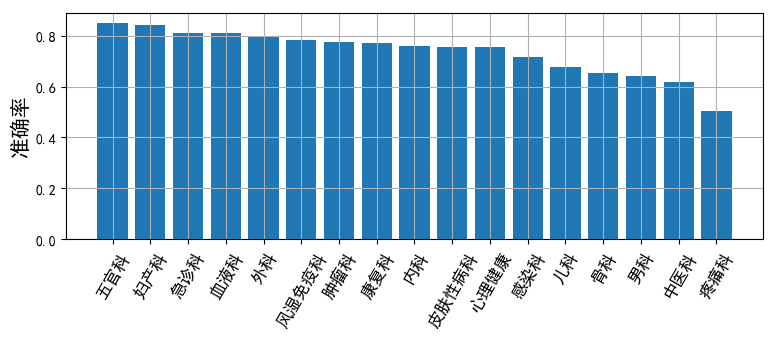

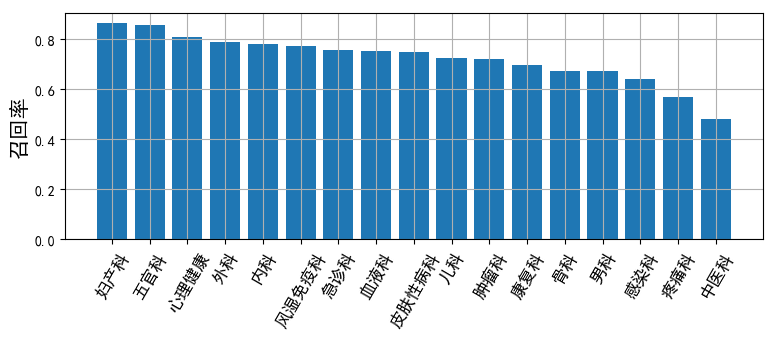

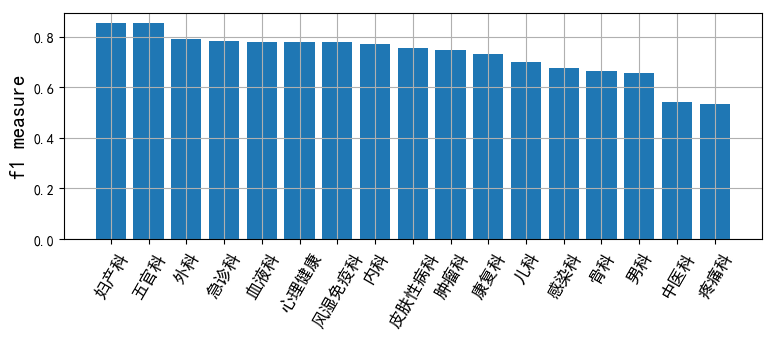

In [26]:
## 绘图   
precision_dict = dict(zip(depart_name, precision))
precision_list = sorted(precision_dict.items(), key=lambda item:item[1], reverse=True)
recall_dict = dict(zip(depart_name, recall))
recall_list = sorted(recall_dict.items(), key=lambda item:item[1], reverse=True)
f1_dict = dict(zip(depart_name, f1_measure))
f1_list = sorted(f1_dict.items(), key=lambda item:item[1], reverse=True)
draw_bar([i[0] for i in precision_list], [i[1] for i in precision_list], u'准确率')
draw_bar([i[0] for i in recall_list], [i[1] for i in recall_list], u'召回率')
draw_bar([i[0] for i in f1_list], [i[1] for i in f1_list], 'f1 measure')

# 4.预测

In [1]:
# coding:utf-8
import numpy
import jieba
import jieba.analyse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cPickle as pkl
import re
import os
import tqdm
import codecs
import fasttext
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline
print "done"

done


## 4.1 数据预处理

In [2]:
# # 统计科室数据量 过滤样本不足的科室

# WORDS_COUNT = 1000
# depart_count = dict()

# with codecs.open('../data/search_appointments_split.txt', 'rb', 'utf-8') as f:
#     contents = f.readlines()
#     for line in contents:
#         line_s = line.split('\t')
#         department = line_s[0].encode('utf-8')
        
#         if not depart_count.has_key(department):
#             depart_count[department] = 1
#         else:
#             depart_count[department] += 1

# depart_count = sorted(depart_count.items(), key=lambda item:item[1], reverse=True)
# print "总科室数：", len(depart_count)
# for (depart, count) in depart_count:
#     print depart, count
    
# print '数据超过%d的科室数：%d' %(WORDS_COUNT, len([count for (depart, count) in depart_count if count > WORDS_COUNT]))

# select_department = [depart for (depart, count) in depart_count if count > WORDS_COUNT]
# # black_list = ['特诊部','未定义','其他']
# # white_list = ['心血管内科', '感染内科', '过敏反应科', '普通内科', '呼吸内科', '肝胆内科', '血液内科', '泌尿内科',
# #              '风湿免疫科', '消化内科', '神经内科', '内分泌科', '肾内科']
# # select_department = list(set(select_department)-set(black_list))
# # select_department = list(set(select_department)&set(white_list))
# select_department_zip = zip(select_department, range(len(select_department)))

# with codecs.open('../data/department_freq_select.txt', 'wb','utf-8') as f:
#     for (d, i) in select_department_zip:
#         f.write(('{}\t{}\n'.format(d, i)).decode('utf-8'))

# select_department_dict = dict(select_department_zip)
# pkl.dump(select_department_dict, open('../data/department_freq_select.pkl', 'wb'))
# print "有效科室数：", len(select_department_dict)
# for i in select_department_dict:
#      print i

# print "done"

In [3]:
# # label加载，筛选低于一定数据量的科室
# select_department_dict = pkl.load(open('../data/department_freq_select.pkl', 'rb'))

# des_list = list()

# with codecs.open('../data/search_appointments_split.txt', 'rb', 'utf-8') as f:
#     contents = f.readlines()
#     for line in contents:
#         line_s = line.split('\t')
#         department = line_s[0].encode('utf-8')
        
#         if select_department_dict.has_key(department):
#             des_list.append((department, u''.join(line_s[1:])))

# # 存储
# with codecs.open('../data/final_test.txt', 'w', 'utf-8') as f:
#     for (label, des) in des_list:
#         f.write(u'{}\t{}'.format(label.decode('utf-8'), des))
# print "done"

## 4.2 测试

In [4]:
#加载一级科目训练集词汇
train_dictionary_first = list()
with codecs.open('../data/word_dictionary.txt', 'rb', 'utf-8') as f:
    cont = f.readlines()
    for line in cont:
        train_dictionary_first.append(line.strip())
train_dictionary_first = dict(zip(train_dictionary_first, range(len(train_dictionary_first))))

#加载一级科目对应关系
select_department_dict_first = pkl.load(open('../data/department.pkl', 'rb'))
select_de_tup_first = select_department_dict_first.items()
new_dict_first = dict(zip([str(x[1]) for x in select_de_tup_first], [x[0] for x in select_de_tup_first]))


#加载二级科目训练集词汇
train_dictionary_second = dict()
new_dict_second = dict()
with codecs.open('../data/department_seg.txt', 'rb') as f:
    contents = f.readlines()
    for line in contents:
        line_s = line.split('：')
        deName = line_s[2].strip()
        train_dictionary_second[deName] = list()
        new_dict_second[deName] = dict()
        
        #加载二级科目对应关系
        with codecs.open('../data/depart_data/word_dictionary_{}.txt'.format(deName), 'rb', 'utf-8') as f:
            cont = f.readlines()
            for line in cont:
                train_dictionary_second[deName].append(line.strip())
        train_dictionary_second[deName] = dict(zip(train_dictionary_second[deName], range(len(train_dictionary_second[deName]))))
        
        select_department_dict_second = pkl.load(open('../data/depart/department_{}.pkl'.format(deName), 'rb'))
        select_de_tup_second = select_department_dict_second.items()
        new_dict_second[deName] = dict(zip([str(x[1]) for x in select_de_tup_second], [x[0] for x in select_de_tup_second]))

print 'done' 

done


In [5]:
# 二层模型
def first_part_decide(model, sentence, prothresh = 0.05):    
    words = [i.strip() for i in sentence.split(' ')]
    words = [i for i in words if train_dictionary_first.has_key(i)]
    words = ' '.join(words)
    if len(words) != 0:
        result = model.predict_proba([words], 5)[0]
        return [(new_dict_first.get(i[0].replace("__label__","")), i[1], i[0]) for i in result if i[1]>prothresh]
    else:
#         print('未出现字典中的关键词,无法判定')
        return None

def second_part_decide(model, sentence, deName, prothresh = 0.05):
    words = [i.strip() for i in sentence.split(' ')]
    words = [i for i in words if train_dictionary_second[deName].has_key(i)]
    words = ' '.join(words)
    if len(words) != 0:
        result = model.predict_proba([words], 5)[0]
        return [(new_dict_second[deName].get(i[0].replace("__label__","")), i[1], i[0]) for i in result if i[1]>prothresh]
    else:
#         print('未出现字典中的关键词,无法判定')
        return None

In [6]:
# 模型加载
first_departPath = '../data/model/app_model.bin'

first_departModel = fasttext.load_model(first_departPath)

second_departModel_dict = dict()
with codecs.open('../data/department_seg.txt', 'rb') as f:
    contents = f.readlines()
modelList = dict()
for line in contents:
    line_s = line.split('：')
    fdepart = line_s[0]
    sdepart_list = line_s[1].split('，')
    if len(sdepart_list) == 1:
        continue
    select_department = [i.strip() for i in sdepart_list]
    fdepart_name = line_s[2].strip()
    modelList[fdepart] = fdepart_name
    secondmodel = fasttext.load_model('../data/model/app_model_{}.bin'.format(fdepart_name))
    second_departModel_dict[fdepart] = secondmodel

print "done"

done


In [7]:
# 加载数据
des_list = list()
label_list = list()
# # 过滤后的科室
# with codecs.open('../data/final_test.txt', 'rb', 'utf-8') as f:
# 未过滤的科室
with codecs.open('../data/search_appointments_split_test_final.txt', 'rb', 'utf-8') as f:
    contents = f.readlines()
    for line in contents:
        line_s = line.split('\t')
        label = line_s[0].encode('utf-8')
        des = line_s[1]
        label_list.append(label)
        des_list.append(des)
print 'done'

done


In [12]:
labels_right = list()
texts = list()
labels_predict = list()

for des_index in tqdm.tqdm(range(len(des_list))):
    des = des_list[des_index]
    first_result = first_part_decide(first_departModel, des)
    if first_result == None:
        continue
    optim_depart = ''
    optim_pro = 0.0
    
    for (fdepart, fpro, fkey) in first_result:
        if second_departModel_dict.has_key(fdepart):
            second_result = second_part_decide(second_departModel_dict[fdepart], des, modelList[fdepart])
            if second_result == None:
                continue
            for (sdepart, spro, skey) in second_result:
                pro = spro
                if pro > optim_pro:
                    optim_depart = sdepart
                    optim_pro = pro
        else:
            if fpro > optim_pro:
                optim_depart = fdepart
                optim_pro = fpro
            
#     print(optim_fdepart)
    if optim_depart!= '':
        labels_predict.append(optim_depart)
        texts.append(des)
        labels_right.append(label_list[des_index])

# for index in range(len(test_data_data)):
#     print('描述：{}'.format(test_data_data[index]))
#     print('科室：{}'.format(res_list[index]))
#     print('\n')

  0%|          | 203/48731 [00:00<00:23, 2027.26it/s]

****************************************
血液科 0.72483 __label__11
五官科 0.0902774 __label__0
皮肤性病科 0.0767997 __label__1
肿瘤科 0.0542406 __label__10
****************************************
五官科 0.628797 __label__0
疼痛科 0.126259 __label__6
内科 0.0728989 __label__5
心理健康 0.0657724 __label__9
****************************************
五官科 0.748047 __label__0
内科 0.25 __label__5
****************************************
五官科 0.674877 __label__0
内科 0.101929 __label__5
急诊科 0.0997585 __label__3
****************************************
儿科 0.606731 __label__2
五官科 0.230606 __label__0
内科 0.10318 __label__5
****************************************
儿科 0.79142 __label__2
五官科 0.204678 __label__0
****************************************
五官科 0.613281 __label__0
内科 0.384766 __label__5
****************************************
五官科 0.884987 __label__0
内科 0.0556641 __label__5
****************************************
儿科 0.920219 __label__2
五官科 0.0649593 __label__0
****************************************
儿科 0.563863 __lab

  1%|▏         | 654/48731 [00:00<00:29, 1602.98it/s]


肿瘤科 0.096899 __label__10
****************************************
五官科 0.895251 __label__0
内科 0.0564766 __label__5
****************************************
五官科 0.622765 __label__0
儿科 0.307256 __label__2
内科 0.0605621 __label__5
****************************************
五官科 0.886666 __label__0
皮肤性病科 0.0770207 __label__1
****************************************
五官科 0.684208 __label__0
肿瘤科 0.247161 __label__10
皮肤性病科 0.0596976 __label__1
****************************************
五官科 0.753906 __label__0
内科 0.244141 __label__5
****************************************
五官科 0.660232 __label__0
中医科 0.185751 __label__4
儿科 0.0663307 __label__2
****************************************
五官科 0.405938 __label__0
肿瘤科 0.265058 __label__10
外科 0.156906 __label__8
内科 0.0789986 __label__5
****************************************
外科 0.589069 __label__8
肿瘤科 0.388383 __label__10
****************************************
五官科 0.935787 __label__0
外科 0.0584793 __label__8
****************************************
外科 0.61

  2%|▏         | 773/48731 [00:00<00:33, 1430.18it/s]

 __label__0
****************************************
外科 0.839233 __label__8
五官科 0.13357 __label__0
****************************************
五官科 0.831354 __label__0
内科 0.150772 __label__5
****************************************
五官科 0.667272 __label__0
皮肤性病科 0.159034 __label__1
肿瘤科 0.0693137 __label__10
****************************************
五官科 0.896683 __label__0
儿科 0.0996094 __label__2
****************************************
内科 0.675476 __label__5
五官科 0.180779 __label__0
儿科 0.0570084 __label__2
****************************************
内科 0.444496 __label__5
五官科 0.204278 __label__0
中医科 0.164979 __label__4
骨科 0.0622561 __label__12
****************************************
外科 0.75943 __label__8
内科 0.225677 __label__5
****************************************
外科 0.772888 __label__8
内科 0.144352 __label__5
五官科 0.0601566 __label__0
****************************************
内科 0.581081 __label__5
五官科 0.355469 __label__0
****************************************
中医科 0.685354 __label__4
五官科 0.2

  2%|▏         | 1186/48731 [00:00<00:34, 1396.17it/s]

0.0501404 __label__5
****************************************
五官科 0.900391 __label__0
内科 0.0656128 __label__5
****************************************
内科 0.802734 __label__5
五官科 0.088495 __label__0
****************************************
五官科 0.777432 __label__0
儿科 0.0693171 __label__2
****************************************
五官科 0.475335 __label__0
皮肤性病科 0.398363 __label__1
儿科 0.0750182 __label__2
****************************************
五官科 0.742169 __label__0
妇产科 0.123625 __label__7
内科 0.0624313 __label__5
外科 0.0614433 __label__8
****************************************
皮肤性病科 0.374636 __label__1
五官科 0.330855 __label__0
肿瘤科 0.178911 __label__10
****************************************
五官科 0.799609 __label__0
肿瘤科 0.150188 __label__10
****************************************
内科 0.613281 __label__5
外科 0.378002 __label__8
****************************************
儿科 0.370053 __label__2
五官科 0.355469 __label__0
心理健康 0.115924 __label__9
妇产科 0.105777 __label__7
*******************************

  3%|▎         | 1577/48731 [00:01<00:30, 1564.88it/s]

五官科 0.4375 __label__0
****************************************
皮肤性病科 0.640068 __label__1
五官科 0.35408 __label__0
****************************************
五官科 0.920497 __label__0
感染科 0.0703125 __label__14
****************************************
五官科 0.904484 __label__0
内科 0.0521241 __label__5
****************************************
内科 0.845795 __label__5
儿科 0.0541556 __label__2
外科 0.0505562 __label__8
****************************************
内科 0.5 __label__5
五官科 0.495117 __label__0
****************************************
中医科 0.486401 __label__4
内科 0.377686 __label__5
五官科 0.0679594 __label__0
妇产科 0.0563967 __label__7
****************************************
五官科 0.795341 __label__0
中医科 0.0746404 __label__4
血液科 0.0540191 __label__11
****************************************
儿科 0.880619 __label__2
五官科 0.103516 __label__0
****************************************
外科 0.724514 __label__8
内科 0.157776 __label__5
五官科 0.0998489 __label__0
****************************************
五官科 0.612083 __lab

  4%|▎         | 1740/48731 [00:01<00:29, 1583.74it/s]

内科 0.798416 __label__5
五官科 0.0583204 __label__0
****************************************
五官科 0.896454 __label__0
外科 0.0800781 __label__8
****************************************
外科 0.583984 __label__8
五官科 0.414063 __label__0
****************************************
五官科 0.885204 __label__0
外科 0.109161 __label__8
****************************************
五官科 0.642578 __label__0
肿瘤科 0.350609 __label__10
****************************************
儿科 0.850463 __label__2
五官科 0.142578 __label__0
****************************************
内科 0.8974 __label__5
五官科 0.0917969 __label__0
****************************************
心理健康 0.273877 __label__9
外科 0.205078 __label__8
疼痛科 0.155506 __label__6
肿瘤科 0.0845626 __label__10
皮肤性病科 0.0694992 __label__1
****************************************
外科 0.943359 __label__8
内科 0.0546875 __label__5
****************************************
五官科 0.864017 __label__0
外科 0.0858078 __label__8
****************************************
五官科 0.635475 __label__0
内科 0.361328 __

  4%|▍         | 2048/48731 [00:01<00:36, 1282.10it/s]


心理健康 0.113027 __label__9
****************************************
风湿免疫科 0.898949 __label__15
疼痛科 0.0619401 __label__6
****************************************
风湿免疫科 0.825457 __label__15
内科 0.0856018 __label__5
骨科 0.0701636 __label__12
****************************************
风湿免疫科 0.765625 __label__15
疼痛科 0.232422 __label__6
****************************************
风湿免疫科 0.591797 __label__15
疼痛科 0.40625 __label__6
****************************************
内科 0.520466 __label__5
风湿免疫科 0.470998 __label__15
****************************************
儿科 0.755818 __label__2
风湿免疫科 0.216612 __label__15
****************************************
风湿免疫科 0.721194 __label__15
疼痛科 0.19974 __label__6
内科 0.0546875 __label__5
****************************************
外科 0.711922 __label__8
内科 0.266533 __label__5
****************************************
皮肤性病科 0.730639 __label__1
骨科 0.163898 __label__12
外科 0.0560303 __label__8
****************************************
风湿免疫科 0.515964 __label__15
五官科 0.159336 _

  5%|▍         | 2308/48731 [00:01<00:41, 1107.95it/s]

 0.1622 __label__11
****************************************
风湿免疫科 0.821384 __label__15
血液科 0.0505653 __label__11
****************************************
风湿免疫科 0.628906 __label__15
内科 0.369141 __label__5
****************************************
儿科 0.545983 __label__2
五官科 0.204878 __label__0
内科 0.106655 __label__5
感染科 0.0713615 __label__14
****************************************
疼痛科 0.624351 __label__6
风湿免疫科 0.355699 __label__15
****************************************
急诊科 0.348492 __label__3
皮肤性病科 0.219621 __label__1
风湿免疫科 0.186281 __label__15
儿科 0.138574 __label__2
****************************************
骨科 0.498049 __label__12
疼痛科 0.49415 __label__6
****************************************
骨科 0.59944 __label__12
风湿免疫科 0.309802 __label__15
****************************************
外科 0.687332 __label__8
心理健康 0.257639 __label__9
****************************************
风湿免疫科 0.750964 __label__15
内科 0.244141 __label__5
****************************************
风湿免疫科 0.539972 __label__1

  5%|▍         | 2424/48731 [00:01<00:42, 1078.24it/s]

 __label__15
****************************************
血液科 0.376408 __label__11
内科 0.304565 __label__5
感染科 0.180785 __label__14
****************************************
风湿免疫科 0.658203 __label__15
内科 0.339844 __label__5
****************************************
骨科 0.810913 __label__12
风湿免疫科 0.184099 __label__15
****************************************
风湿免疫科 0.810715 __label__15
皮肤性病科 0.142578 __label__1
****************************************
内科 0.724609 __label__5
心理健康 0.0817437 __label__9
中医科 0.0801469 __label__4
血液科 0.051285 __label__11
****************************************
风湿免疫科 0.914687 __label__15
疼痛科 0.0754304 __label__6
****************************************
风湿免疫科 0.878086 __label__15
内科 0.111111 __label__5
****************************************
内科 0.928001 __label__5
风湿免疫科 0.054679 __label__15
****************************************
内科 0.792969 __label__5
儿科 0.179493 __label__2
****************************************
五官科 0.568761 __label__0
皮肤性病科 0.390437 __label__1
***

  5%|▌         | 2670/48731 [00:01<00:41, 1108.25it/s]

 0.10799 __label__6
****************************************
心理健康 0.656707 __label__9
风湿免疫科 0.307337 __label__15
****************************************
外科 0.267494 __label__8
急诊科 0.234415 __label__3
风湿免疫科 0.173332 __label__15
中医科 0.158363 __label__4
皮肤性病科 0.0697322 __label__1
****************************************
风湿免疫科 0.894531 __label__15
骨科 0.103516 __label__12
****************************************
内科 0.927734 __label__5
风湿免疫科 0.0561116 __label__15
****************************************
内科 0.655632 __label__5
风湿免疫科 0.332585 __label__15
****************************************
皮肤性病科 0.581453 __label__1
心理健康 0.207176 __label__9
中医科 0.084735 __label__4
****************************************
风湿免疫科 0.498686 __label__15
骨科 0.401736 __label__12
内科 0.0585938 __label__5
****************************************
内科 0.793762 __label__5
中医科 0.145821 __label__4
风湿免疫科 0.0523424 __label__15
****************************************
骨科 0.361972 __label__12
风湿免疫科 0.338695 __label__15
疼痛科 0.

  6%|▌         | 2898/48731 [00:02<00:45, 1001.96it/s]

__label__15
急诊科 0.227959 __label__3
内科 0.0625 __label__5
****************************************
风湿免疫科 0.876953 __label__15
内科 0.121094 __label__5
****************************************
内科 0.826172 __label__5
风湿免疫科 0.171875 __label__15
****************************************
骨科 0.615851 __label__12
皮肤性病科 0.276872 __label__1
风湿免疫科 0.0508932 __label__15
****************************************
骨科 0.87284 __label__12
疼痛科 0.087894 __label__6
****************************************
风湿免疫科 0.900391 __label__15
骨科 0.0976563 __label__12
****************************************
风湿免疫科 0.697853 __label__15
内科 0.298828 __label__5
****************************************
骨科 0.916016 __label__12
风湿免疫科 0.0820313 __label__15
****************************************
风湿免疫科 0.67561 __label__15
儿科 0.23497 __label__2
****************************************
血液科 0.799599 __label__11
风湿免疫科 0.195313 __label__15
****************************************
骨科 0.759468 __label__12
疼痛科 0.209049 __label__6
******

  6%|▋         | 3098/48731 [00:02<00:50, 907.06it/s] 


****************************************
风湿免疫科 0.5 __label__15
骨科 0.485435 __label__12
****************************************
风湿免疫科 0.921875 __label__15
内科 0.0761719 __label__5
****************************************
风湿免疫科 0.404516 __label__15
感染科 0.161956 __label__14
五官科 0.108948 __label__0
妇产科 0.0888163 __label__7
儿科 0.0632038 __label__2
****************************************
风湿免疫科 0.635238 __label__15
皮肤性病科 0.172832 __label__1
中医科 0.12591 __label__4
****************************************
外科 0.367699 __label__8
中医科 0.351043 __label__4
康复科 0.083179 __label__13
内科 0.0786133 __label__5
疼痛科 0.0599526 __label__6
****************************************
内科 0.90625 __label__5
外科 0.0917969 __label__8
****************************************
内科 0.711197 __label__5
风湿免疫科 0.249134 __label__15
****************************************
疼痛科 0.458781 __label__6
风湿免疫科 0.218108 __label__15
外科 0.173916 __label__8
骨科 0.137787 __label__12
****************************************
风湿免疫科 0.682462 __

  7%|▋         | 3319/48731 [00:02<00:46, 981.36it/s]

****************************************
心理健康 0.891056 __label__9
内科 0.0820313 __label__5
****************************************
心理健康 0.92281 __label__9
内科 0.0620117 __label__5
****************************************
心理健康 0.617406 __label__9
中医科 0.273316 __label__4
****************************************
急诊科 0.639323 __label__3
心理健康 0.287109 __label__9
****************************************
内科 0.428913 __label__5
五官科 0.3308 __label__0
外科 0.0601807 __label__8
心理健康 0.0596916 __label__9
皮肤性病科 0.0502144 __label__1
****************************************
五官科 0.657879 __label__0
内科 0.304047 __label__5
****************************************
内科 0.526474 __label__5
皮肤性病科 0.213735 __label__1
五官科 0.112424 __label__0
中医科 0.0680817 __label__4
****************************************
心理健康 0.759766 __label__9
感染科 0.238281 __label__14
****************************************
内科 0.882812 __label__5
骨科 0.113209 __label__12
****************************************
心理健康 0.45087 __label__9
内科 0.33

  7%|▋         | 3527/48731 [00:02<00:47, 944.35it/s]

 0.174168 __label__8
皮肤性病科 0.159622 __label__1
妇产科 0.149595 __label__7
****************************************
心理健康 0.814533 __label__9
五官科 0.0916055 __label__0
****************************************
感染科 0.324283 __label__14
心理健康 0.239578 __label__9
疼痛科 0.19034 __label__6
中医科 0.0847723 __label__4
****************************************
皮肤性病科 0.423861 __label__1
五官科 0.32102 __label__0
男科 0.197355 __label__16
****************************************
内科 0.892578 __label__5
外科 0.105263 __label__8
****************************************
中医科 0.505683 __label__4
男科 0.448881 __label__16
****************************************
心理健康 0.78014 __label__9
外科 0.0673828 __label__8
****************************************
内科 0.844345 __label__5
中医科 0.128474 __label__4
****************************************
心理健康 0.591434 __label__9
妇产科 0.346298 __label__7
中医科 0.0510601 __label__4
****************************************
风湿免疫科 0.452939 __label__15
心理健康 0.165151 __label__9
五官科 0.134763 __label__0


  8%|▊         | 3756/48731 [00:03<00:46, 969.05it/s] 

内科 0.181641 __label__5
****************************************
急诊科 0.453874 __label__3
心理健康 0.361316 __label__9
感染科 0.071618 __label__14
儿科 0.0617664 __label__2
****************************************
急诊科 0.899187 __label__3
内科 0.0916176 __label__5
****************************************
急诊科 0.911692 __label__3
内科 0.065239 __label__5
****************************************
内科 0.610886 __label__5
急诊科 0.381021 __label__3
****************************************
急诊科 0.768814 __label__3
内科 0.210938 __label__5
****************************************
内科 0.903351 __label__5
外科 0.0628243 __label__8
****************************************
康复科 0.846001 __label__13
内科 0.150097 __label__5
****************************************
急诊科 0.909809 __label__3
外科 0.0671578 __label__8
****************************************
急诊科 0.815515 __label__3
康复科 0.176695 __label__13
****************************************
急诊科 0.933841 __label__3
康复科 0.0603106 __label__13
**************************************

  8%|▊         | 3976/48731 [00:03<00:45, 990.24it/s]

感染科 0.228008 __label__14
****************************************
急诊科 0.885682 __label__3
内科 0.082016 __label__5
****************************************
急诊科 0.408474 __label__3
血液科 0.309026 __label__11
风湿免疫科 0.104096 __label__15
康复科 0.058484 __label__13
外科 0.0561981 __label__8
****************************************
内科 0.583984 __label__5
骨科 0.244802 __label__12
中医科 0.135422 __label__4
****************************************
感染科 0.466282 __label__14
急诊科 0.259431 __label__3
内科 0.171875 __label__5
****************************************
急诊科 0.8536 __label__3
疼痛科 0.0944197 __label__6
****************************************
儿科 0.93988 __label__2
急诊科 0.0502869 __label__3
****************************************
儿科 0.435631 __label__2
风湿免疫科 0.43374 __label__15
****************************************
内科 0.542793 __label__5
急诊科 0.444332 __label__3
****************************************
儿科 0.685436 __label__2
急诊科 0.0856099 __label__3
内科 0.0626183 __label__5
五官科 0.0555842 __label__0
****

  9%|▊         | 4198/48731 [00:03<00:43, 1024.83it/s]


外科 0.0625 __label__8
****************************************
疼痛科 0.331044 __label__6
外科 0.22525 __label__8
感染科 0.0950604 __label__14
内科 0.0845833 __label__5
风湿免疫科 0.0663796 __label__15
****************************************
风湿免疫科 0.782497 __label__15
皮肤性病科 0.210938 __label__1
****************************************
急诊科 0.842102 __label__3
内科 0.154297 __label__5
****************************************
疼痛科 0.328809 __label__6
感染科 0.233135 __label__14
内科 0.176147 __label__5
外科 0.0982094 __label__8
****************************************
疼痛科 0.429482 __label__6
风湿免疫科 0.21067 __label__15
感染科 0.168516 __label__14
急诊科 0.112391 __label__3
****************************************
感染科 0.79142 __label__14
急诊科 0.205078 __label__3
****************************************
风湿免疫科 0.71203 __label__15
皮肤性病科 0.111111 __label__1
心理健康 0.0976906 __label__9
血液科 0.0649149 __label__11
****************************************
急诊科 0.658203 __label__3
内科 0.339844 __label__5
********************************

  9%|▉         | 4471/48731 [00:03<00:40, 1101.70it/s]

__label__5
****************************************
急诊科 0.736121 __label__3
内科 0.167313 __label__5
****************************************
内科 0.79874 __label__5
心理健康 0.113349 __label__9
****************************************
心理健康 0.519511 __label__9
中医科 0.252945 __label__4
风湿免疫科 0.163575 __label__15
内科 0.0527344 __label__5
****************************************
急诊科 0.836531 __label__3
内科 0.134766 __label__5
****************************************
疼痛科 0.818234 __label__6
急诊科 0.0929522 __label__3
****************************************
五官科 0.748047 __label__0
内科 0.247559 __label__5
****************************************
疼痛科 0.624575 __label__6
心理健康 0.278508 __label__9
感染科 0.0894246 __label__14
****************************************
急诊科 0.882328 __label__3
内科 0.0742188 __label__5
****************************************
急诊科 0.912109 __label__3
内科 0.0859375 __label__5
****************************************
血液科 0.306318 __label__11
急诊科 0.288867 __label__3
心理健康 0.271278 __label_

 10%|▉         | 4695/48731 [00:04<00:42, 1038.74it/s]

****************************************
外科 0.60051 __label__8
皮肤性病科 0.205169 __label__1
五官科 0.0825839 __label__0
疼痛科 0.0620164 __label__6
****************************************
皮肤性病科 0.826172 __label__1
男科 0.164154 __label__16
****************************************
五官科 0.478107 __label__0
中医科 0.194904 __label__4
感染科 0.155755 __label__14
皮肤性病科 0.127377 __label__1
****************************************
皮肤性病科 0.768483 __label__1
血液科 0.0681868 __label__11
****************************************
皮肤性病科 0.470839 __label__1
疼痛科 0.43817 __label__6
男科 0.0695595 __label__16
****************************************
急诊科 0.471584 __label__3
感染科 0.279353 __label__14
内科 0.0815506 __label__5
****************************************
外科 0.882805 __label__8
肿瘤科 0.0741893 __label__10
****************************************
皮肤性病科 0.866428 __label__1
男科 0.101979 __label__16
****************************************
外科 0.362652 __label__8
男科 0.310104 __label__16
皮肤性病科 0.304099 __label__1
*************

 10%|█         | 4908/48731 [00:04<00:42, 1038.24it/s]

 0.291825 __label__1
内科 0.206566 __label__5
****************************************
皮肤性病科 0.924498 __label__1
男科 0.0635759 __label__16
****************************************
中医科 0.624848 __label__4
皮肤性病科 0.106879 __label__1
男科 0.0876593 __label__16
****************************************
皮肤性病科 0.668288 __label__1
外科 0.1978 __label__8
中医科 0.106496 __label__4
****************************************
中医科 0.808249 __label__4
男科 0.0855863 __label__16
****************************************
疼痛科 0.491985 __label__6
中医科 0.20927 __label__4
男科 0.19417 __label__16
心理健康 0.0969734 __label__9
****************************************
妇产科 0.727768 __label__7
中医科 0.157492 __label__4
内科 0.0994148 __label__5
****************************************
男科 0.693849 __label__16
外科 0.190659 __label__8
肿瘤科 0.106505 __label__10
****************************************
皮肤性病科 0.894531 __label__1
男科 0.103516 __label__16
****************************************
外科 0.607719 __label__8
内科 0.294743 __label__5
皮肤性病科

 10%|█         | 5022/48731 [00:04<00:41, 1065.15it/s]

****************************************
肿瘤科 0.686325 __label__10
皮肤性病科 0.251408 __label__1
外科 0.0566406 __label__8
****************************************
皮肤性病科 0.854494 __label__1
外科 0.103313 __label__8
****************************************
男科 0.81475 __label__16
皮肤性病科 0.0817161 __label__1
****************************************
男科 0.606873 __label__16
皮肤性病科 0.275208 __label__1
肿瘤科 0.0931543 __label__10
****************************************
外科 0.883369 __label__8
疼痛科 0.0670988 __label__6
****************************************
男科 0.778201 __label__16
皮肤性病科 0.215951 __label__1
****************************************
男科 0.778806 __label__16
皮肤性病科 0.165344 __label__1
****************************************
内科 0.440231 __label__5
皮肤性病科 0.34132 __label__1
五官科 0.194073 __label__0
****************************************
妇产科 0.463966 __label__7
感染科 0.427002 __label__14
外科 0.0575295 __label__8
****************************************
男科 0.87279 __label__16
皮肤性病科 0.0584216 __label_

 11%|█         | 5372/48731 [00:04<00:39, 1104.94it/s]

__label__0
感染科 0.0889329 __label__14
****************************************
外科 0.459595 __label__8
皮肤性病科 0.308742 __label__1
男科 0.202352 __label__16
****************************************
男科 0.851552 __label__16
中医科 0.0682551 __label__4
****************************************
感染科 0.773334 __label__14
妇产科 0.156181 __label__7
****************************************
内科 0.617851 __label__5
五官科 0.369141 __label__0
****************************************
疼痛科 0.825979 __label__6
外科 0.138672 __label__8
****************************************
内科 0.84375 __label__5
皮肤性病科 0.117871 __label__1
****************************************
皮肤性病科 0.44916 __label__1
肿瘤科 0.384708 __label__10
内科 0.128563 __label__5
****************************************
外科 0.487183 __label__8
男科 0.241896 __label__16
心理健康 0.140081 __label__9
皮肤性病科 0.0574862 __label__1
****************************************
内科 0.843266 __label__5
骨科 0.0832119 __label__12
****************************************
皮肤性病科 0.906429 __lab

 11%|█▏        | 5537/48731 [00:04<00:35, 1223.71it/s]

****************************************
心理健康 0.564419 __label__9
内科 0.248535 __label__5
血液科 0.0694669 __label__11
****************************************
心理健康 0.848045 __label__9
内科 0.0742188 __label__5
中医科 0.073834 __label__4
****************************************
心理健康 0.724609 __label__9
中医科 0.241041 __label__4
****************************************
内科 0.855469 __label__5
儿科 0.110863 __label__2
****************************************
心理健康 0.896297 __label__9
内科 0.0839844 __label__5
****************************************
心理健康 0.676411 __label__9
中医科 0.320313 __label__4
****************************************
中医科 0.790886 __label__4
内科 0.191406 __label__5
****************************************
儿科 0.894531 __label__2
心理健康 0.103516 __label__9
****************************************
心理健康 0.483443 __label__9
内科 0.403076 __label__5
急诊科 0.0734083 __label__3
****************************************
心理健康 0.69901 __label__9
内科 0.201172 __label__5
中医科 0.0947548 __label__4
**********

 12%|█▏        | 5929/48731 [00:05<00:34, 1256.40it/s]

__label__5
****************************************
心理健康 0.933594 __label__9
中医科 0.0644531 __label__4
****************************************
中医科 0.3882 __label__4
心理健康 0.304814 __label__9
内科 0.292397 __label__5
****************************************
心理健康 0.407993 __label__9
疼痛科 0.336612 __label__6
内科 0.201172 __label__5
****************************************
心理健康 0.621262 __label__9
内科 0.0882263 __label__5
五官科 0.0749141 __label__0
****************************************
内科 0.881088 __label__5
五官科 0.0733719 __label__0
****************************************
急诊科 0.425083 __label__3
心理健康 0.323136 __label__9
内科 0.0813904 __label__5
康复科 0.0685929 __label__13
****************************************
心理健康 0.685547 __label__9
中医科 0.31189 __label__4
****************************************
心理健康 0.880021 __label__9
儿科 0.0905058 __label__2
****************************************
心理健康 0.913306 __label__9
内科 0.0697632 __label__5
****************************************
儿科 0.576859 __label_

 12%|█▏        | 6057/48731 [00:05<00:34, 1228.64it/s]

__label__9
中医科 0.22092 __label__4
****************************************
内科 0.642578 __label__5
心理健康 0.35408 __label__9
****************************************
内科 0.698597 __label__5
急诊科 0.112397 __label__3
中医科 0.0780856 __label__4
****************************************
儿科 0.744471 __label__2
急诊科 0.106949 __label__3
心理健康 0.10091 __label__9
****************************************
心理健康 0.865234 __label__9
风湿免疫科 0.0663156 __label__15
****************************************
心理健康 0.906519 __label__9
中医科 0.0638237 __label__4
****************************************
中医科 0.643002 __label__4
骨科 0.166294 __label__12
内科 0.104675 __label__5
****************************************
内科 0.830078 __label__5
心理健康 0.167641 __label__9
****************************************
五官科 0.859909 __label__0
内科 0.13345 __label__5
****************************************
心理健康 0.893173 __label__9
感染科 0.0986389 __label__14
****************************************
内科 0.863544 __label__5
心理健康 0.132035 __label__9

 13%|█▎        | 6296/48731 [00:05<00:43, 968.65it/s] 

 0.712454 __label__12
内科 0.174957 __label__5
疼痛科 0.0684347 __label__6
****************************************
外科 0.765625 __label__8
骨科 0.232422 __label__12
****************************************
外科 0.929688 __label__8
骨科 0.0683594 __label__12
****************************************
外科 0.830078 __label__8
骨科 0.0977083 __label__12
疼痛科 0.0692781 __label__6
****************************************
外科 0.904297 __label__8
骨科 0.0926532 __label__12
****************************************
外科 0.792969 __label__8
骨科 0.205078 __label__12
****************************************
骨科 0.943565 __label__12
中医科 0.0505829 __label__4
****************************************
外科 0.837891 __label__8
骨科 0.159843 __label__12
****************************************
骨科 0.882812 __label__12
外科 0.115234 __label__8
****************************************
外科 0.859375 __label__8
骨科 0.138672 __label__12
****************************************
骨科 0.858812 __label__12
外科 0.0680924 __label__8
*******************

 13%|█▎        | 6500/48731 [00:05<00:47, 895.35it/s]

 __label__12
外科 0.429688 __label__8
****************************************
外科 0.745125 __label__8
风湿免疫科 0.0689561 __label__15
骨科 0.0647234 __label__12
疼痛科 0.0538685 __label__6
****************************************
外科 0.552734 __label__8
骨科 0.247519 __label__12
内科 0.0913239 __label__5
疼痛科 0.0726203 __label__6
****************************************
疼痛科 0.858856 __label__6
骨科 0.0709648 __label__12
外科 0.0662766 __label__8
****************************************
外科 0.724609 __label__8
内科 0.220566 __label__5
****************************************
骨科 0.799064 __label__12
内科 0.142021 __label__5
****************************************
骨科 0.529297 __label__12
外科 0.46875 __label__8
****************************************
外科 0.677734 __label__8
骨科 0.320313 __label__12
****************************************
外科 0.491226 __label__8
骨科 0.486136 __label__12
****************************************
外科 0.583984 __label__8
骨科 0.414063 __label__12
****************************************
外科 0

 14%|█▎        | 6687/48731 [00:05<00:47, 889.77it/s]

风湿免疫科 0.244679 __label__15
****************************************
骨科 0.904655 __label__12
外科 0.0898438 __label__8
****************************************
骨科 0.60149 __label__12
中医科 0.38681 __label__4
****************************************
骨科 0.815734 __label__12
外科 0.0887909 __label__8
疼痛科 0.0682898 __label__6
****************************************
外科 0.943466 __label__8
骨科 0.0507931 __label__12
****************************************
外科 0.389404 __label__8
疼痛科 0.200046 __label__6
风湿免疫科 0.146253 __label__15
血液科 0.111526 __label__11
****************************************
疼痛科 0.530754 __label__6
外科 0.286549 __label__8
骨科 0.167177 __label__12
****************************************
儿科 0.508195 __label__2
外科 0.459137 __label__8
****************************************
外科 0.787109 __label__8
疼痛科 0.117548 __label__6
骨科 0.0921049 __label__12
****************************************
骨科 0.671875 __label__12
外科 0.326172 __label__8
****************************************
骨科 0.921875 _

 14%|█▍        | 6886/48731 [00:06<00:45, 918.48it/s]

0.544922 __label__8
骨科 0.453125 __label__12
****************************************
内科 0.789059 __label__5
骨科 0.15873 __label__12
****************************************
骨科 0.900391 __label__12
外科 0.0976563 __label__8
****************************************
外科 0.645309 __label__8
疼痛科 0.236133 __label__6
内科 0.0583954 __label__5
****************************************
皮肤性病科 0.439542 __label__1
男科 0.281823 __label__16
五官科 0.125443 __label__0
外科 0.0870361 __label__8
****************************************
内科 0.490265 __label__5
骨科 0.395837 __label__12
风湿免疫科 0.0658444 __label__15
****************************************
骨科 0.578986 __label__12
中医科 0.263925 __label__4
疼痛科 0.0947045 __label__6
****************************************
骨科 0.812889 __label__12
外科 0.150391 __label__8
****************************************
骨科 0.904297 __label__12
外科 0.09375 __label__8
****************************************
骨科 0.535011 __label__12
疼痛科 0.453756 __label__6
***********************************

 15%|█▍        | 7092/48731 [00:06<00:44, 930.29it/s]

 __label__6
骨科 0.269695 __label__12
外科 0.176125 __label__8
风湿免疫科 0.10057 __label__15
血液科 0.0564005 __label__11
****************************************
外科 0.922024 __label__8
骨科 0.0663559 __label__12
****************************************
骨科 0.576172 __label__12
外科 0.421875 __label__8
****************************************
感染科 0.353181 __label__14
中医科 0.291339 __label__4
疼痛科 0.125534 __label__6
血液科 0.0698889 __label__11
内科 0.0552025 __label__5
****************************************
骨科 0.524611 __label__12
外科 0.455536 __label__8
****************************************
外科 0.650391 __label__8
骨科 0.342911 __label__12
****************************************
骨科 0.855469 __label__12
外科 0.142578 __label__8
****************************************
五官科 0.546127 __label__0
内科 0.24855 __label__5
外科 0.0941277 __label__8
骨科 0.083986 __label__12
****************************************
外科 0.765625 __label__8
骨科 0.232422 __label__12
****************************************
骨科 0.931641 __label_

 15%|█▌        | 7385/48731 [00:06<00:36, 1138.80it/s]

****************************************
妇产科 0.601538 __label__7
外科 0.218643 __label__8
肿瘤科 0.105776 __label__10
****************************************
妇产科 0.586018 __label__7
内科 0.40625 __label__5
****************************************
妇产科 0.816099 __label__7
中医科 0.16023 __label__4
****************************************
妇产科 0.792212 __label__7
皮肤性病科 0.19921 __label__1
****************************************
内科 0.440979 __label__5
外科 0.333332 __label__8
中医科 0.10761 __label__4
妇产科 0.0921042 __label__7
****************************************
妇产科 0.775391 __label__7
骨科 0.222656 __label__12
****************************************
外科 0.637558 __label__8
妇产科 0.233635 __label__7
骨科 0.0661863 __label__12
****************************************
妇产科 0.939568 __label__7
肿瘤科 0.0558693 __label__10
****************************************
外科 0.843544 __label__8
妇产科 0.109375 __label__7
****************************************
妇产科 0.803493 __label__7
外科 0.111778 __label__8
肿瘤科 0.0516453 __la

 16%|█▌        | 7705/48731 [00:06<00:30, 1335.62it/s]

__label__5
****************************************
妇产科 0.664063 __label__7
感染科 0.333984 __label__14
****************************************
妇产科 0.837174 __label__7
内科 0.153996 __label__5
****************************************
妇产科 0.511429 __label__7
内科 0.445313 __label__5
****************************************
外科 0.504589 __label__8
妇产科 0.391569 __label__7
****************************************
妇产科 0.909004 __label__7
内科 0.0800781 __label__5
****************************************
妇产科 0.762467 __label__7
内科 0.155502 __label__5
外科 0.0722657 __label__8
****************************************
妇产科 0.943466 __label__7
疼痛科 0.0526314 __label__6
****************************************
妇产科 0.732299 __label__7
男科 0.105836 __label__16
血液科 0.0787316 __label__11
****************************************
男科 0.85643 __label__16
皮肤性病科 0.102804 __label__1
****************************************
妇产科 0.820146 __label__7
内科 0.0836563 __label__5
****************************************
妇产科 0.546

 16%|█▋        | 7997/48731 [00:06<00:29, 1360.69it/s]


****************************************
妇产科 0.556054 __label__7
内科 0.201347 __label__5
外科 0.0684815 __label__8
****************************************
皮肤性病科 0.742029 __label__1
男科 0.158536 __label__16
****************************************
内科 0.758282 __label__5
骨科 0.180176 __label__12
****************************************
妇产科 0.809458 __label__7
骨科 0.106104 __label__12
****************************************
妇产科 0.67988 __label__7
内科 0.229004 __label__5
外科 0.0807495 __label__8
****************************************
妇产科 0.784596 __label__7
皮肤性病科 0.0557978 __label__1
感染科 0.0519655 __label__14
****************************************
疼痛科 0.233886 __label__6
风湿免疫科 0.230073 __label__15
妇产科 0.167313 __label__7
血液科 0.165508 __label__11
康复科 0.150384 __label__13
****************************************
外科 0.621277 __label__8
男科 0.204791 __label__16
妇产科 0.0553082 __label__7
骨科 0.0532592 __label__12
****************************************
骨科 0.805226 __label__12
内科 0.145985 __label__

 17%|█▋        | 8323/48731 [00:07<00:28, 1407.43it/s]

__label__7
疼痛科 0.0722657 __label__6
****************************************
骨科 0.894531 __label__12
妇产科 0.103516 __label__7
****************************************
儿科 0.824558 __label__2
妇产科 0.171875 __label__7
****************************************
疼痛科 0.910495 __label__6
妇产科 0.0838204 __label__7
****************************************
妇产科 0.705078 __label__7
内科 0.292969 __label__5
****************************************
妇产科 0.834621 __label__7
男科 0.156103 __label__16
****************************************
中医科 0.662218 __label__4
妇产科 0.251861 __label__7
内科 0.0600739 __label__5
****************************************
妇产科 0.724609 __label__7
感染科 0.272903 __label__14
****************************************
内科 0.812302 __label__5
妇产科 0.175999 __label__7
****************************************
儿科 0.666626 __label__2
妇产科 0.324261 __label__7
****************************************
肿瘤科 0.610888 __label__10
妇产科 0.378779 __label__7
****************************************
儿科 0.93405

 18%|█▊        | 8606/48731 [00:07<00:29, 1339.48it/s]


内科 0.0777359 __label__5
****************************************
肿瘤科 0.685547 __label__10
妇产科 0.31189 __label__7
****************************************
内科 0.752434 __label__5
妇产科 0.243188 __label__7
****************************************
外科 0.595688 __label__8
妇产科 0.26376 __label__7
肿瘤科 0.0616862 __label__10
****************************************
妇产科 0.796131 __label__7
中医科 0.0688339 __label__4
****************************************
外科 0.479126 __label__8
男科 0.285415 __label__16
妇产科 0.215951 __label__7
****************************************
内科 0.513672 __label__5
外科 0.484375 __label__8
****************************************
皮肤性病科 0.508126 __label__1
男科 0.359573 __label__16
妇产科 0.12015 __label__7
****************************************
妇产科 0.774507 __label__7
皮肤性病科 0.155789 __label__1
****************************************
妇产科 0.642926 __label__7
五官科 0.216797 __label__0
内科 0.134277 __label__5
****************************************
内科 0.883812 __label__5
妇产科 0.07745 __l

 18%|█▊        | 8895/48731 [00:07<00:29, 1373.58it/s]

__label__8
五官科 0.341315 __label__0
妇产科 0.266533 __label__7
****************************************
外科 0.892784 __label__8
妇产科 0.101706 __label__7
****************************************
妇产科 0.675622 __label__7
内科 0.165585 __label__5
中医科 0.0502389 __label__4
****************************************
疼痛科 0.554774 __label__6
感染科 0.325628 __label__14
****************************************
妇产科 0.656395 __label__7
内科 0.142765 __label__5
中医科 0.0830032 __label__4
骨科 0.0627516 __label__12
****************************************
妇产科 0.932304 __label__7
疼痛科 0.0546875 __label__6
****************************************
中医科 0.587407 __label__4
妇产科 0.377753 __label__7
****************************************
妇产科 0.673977 __label__7
男科 0.264954 __label__16
****************************************
妇产科 0.889618 __label__7
内科 0.0722657 __label__5
****************************************
男科 0.392764 __label__16
皮肤性病科 0.225824 __label__1
妇产科 0.14506 __label__7
外科 0.101601 __label__8
感染科 0.0673968 __la

 19%|█▊        | 9034/48731 [00:07<00:32, 1234.66it/s]

感染科 0.750531 __label__14
皮肤性病科 0.0611248 __label__1
急诊科 0.0551341 __label__3
****************************************
儿科 0.566141 __label__2
内科 0.428848 __label__5
****************************************
外科 0.499023 __label__8
内科 0.413086 __label__5
疼痛科 0.0750275 __label__6
****************************************
外科 0.935783 __label__8
疼痛科 0.0551049 __label__6
****************************************
皮肤性病科 0.78422 __label__1
外科 0.183373 __label__8
****************************************
骨科 0.923828 __label__12
外科 0.0742188 __label__8
****************************************
外科 0.868389 __label__8
妇产科 0.0977051 __label__7
****************************************
外科 0.624283 __label__8
疼痛科 0.193912 __label__6
内科 0.0839806 __label__5
****************************************
外科 0.784424 __label__8
儿科 0.135277 __label__2
内科 0.0644379 __label__5
****************************************
外科 0.587254 __label__8
疼痛科 0.279196 __label__6
骨科 0.0873224 __label__12
********************************

 19%|█▉        | 9274/48731 [00:08<00:38, 1012.12it/s]

__label__4
感染科 0.119216 __label__14
急诊科 0.0521155 __label__3
****************************************
五官科 0.868403 __label__0
外科 0.120148 __label__8
****************************************
内科 0.861855 __label__5
疼痛科 0.0582662 __label__6
感染科 0.053247 __label__14
****************************************
皮肤性病科 0.393428 __label__1
外科 0.284866 __label__8
肿瘤科 0.246263 __label__10
****************************************
外科 0.575047 __label__8
内科 0.418579 __label__5
****************************************
儿科 0.64534 __label__2
感染科 0.273862 __label__14
****************************************
外科 0.760086 __label__8
皮肤性病科 0.114467 __label__1
儿科 0.10281 __label__2
****************************************
中医科 0.357808 __label__4
骨科 0.270507 __label__12
妇产科 0.247015 __label__7
内科 0.109161 __label__5
****************************************
外科 0.688843 __label__8
皮肤性病科 0.115709 __label__1
风湿免疫科 0.0535263 __label__15
****************************************
疼痛科 0.382297 __label__6
外科 0.335743 __la

 19%|█▉        | 9381/48731 [00:08<00:39, 1001.07it/s]

__label__12
中医科 0.137197 __label__4
****************************************
外科 0.902756 __label__8
内科 0.0585938 __label__5
****************************************
内科 0.65239 __label__5
外科 0.33268 __label__8
****************************************
肿瘤科 0.450116 __label__10
外科 0.121185 __label__8
心理健康 0.115587 __label__9
内科 0.0766754 __label__5
男科 0.0726324 __label__16
****************************************
外科 0.891418 __label__8
五官科 0.058488 __label__0
****************************************
外科 0.888672 __label__8
皮肤性病科 0.0922852 __label__1
****************************************
外科 0.705383 __label__8
儿科 0.268935 __label__2
****************************************
肿瘤科 0.78125 __label__10
外科 0.216797 __label__8
****************************************
外科 0.811623 __label__8
儿科 0.112678 __label__2
内科 0.067051 __label__5
****************************************
外科 0.838806 __label__8
儿科 0.154297 __label__2
****************************************
外科 0.69957 __label__8
内科 0.123596 __

 20%|█▉        | 9586/48731 [00:08<00:41, 942.11it/s] 

骨科 0.168366 __label__12
****************************************
外科 0.873047 __label__8
骨科 0.120638 __label__12
****************************************
骨科 0.571929 __label__12
内科 0.196457 __label__5
疼痛科 0.103539 __label__6
心理健康 0.0851451 __label__9
****************************************
内科 0.943359 __label__5
外科 0.0546875 __label__8
****************************************
肿瘤科 0.847656 __label__10
外科 0.150391 __label__8
****************************************
外科 0.802979 __label__8
内科 0.0645065 __label__5
****************************************
肿瘤科 0.585176 __label__10
内科 0.27029 __label__5
血液科 0.052862 __label__11
****************************************
外科 0.604897 __label__8
内科 0.322392 __label__5
****************************************
风湿免疫科 0.894958 __label__15
内科 0.0742188 __label__5
****************************************
外科 0.73489 __label__8
皮肤性病科 0.259679 __label__1
****************************************
皮肤性病科 0.835428 __label__1
疼痛科 0.096815 __label__6
*************

 20%|██        | 9778/48731 [00:08<00:44, 882.17it/s]

 0.573944 __label__10
五官科 0.194778 __label__0
皮肤性病科 0.115156 __label__1
外科 0.0996094 __label__8
****************************************
感染科 0.910655 __label__14
皮肤性病科 0.0669708 __label__1
****************************************
急诊科 0.752832 __label__3
感染科 0.150314 __label__14
****************************************
肿瘤科 0.544922 __label__10
外科 0.453125 __label__8
****************************************
五官科 0.513104 __label__0
内科 0.404221 __label__5
****************************************
肿瘤科 0.578728 __label__10
皮肤性病科 0.389893 __label__1
****************************************
外科 0.898438 __label__8
内科 0.0922165 __label__5
****************************************
儿科 0.852621 __label__2
外科 0.125 __label__8
****************************************
外科 0.820312 __label__8
疼痛科 0.174965 __label__6
****************************************
内科 0.525829 __label__5
外科 0.371201 __label__8
****************************************
内科 0.42828 __label__5
外科 0.385284 __label__8
*******************

 21%|██        | 10037/48731 [00:08<00:37, 1018.28it/s]

 __label__2
****************************************
肿瘤科 0.83073 __label__10
外科 0.164063 __label__8
****************************************
内科 0.568962 __label__5
儿科 0.344548 __label__2
外科 0.0696259 __label__8
****************************************
外科 0.649204 __label__8
内科 0.177223 __label__5
血液科 0.103918 __label__11
****************************************
外科 0.759766 __label__8
骨科 0.19241 __label__12
****************************************
肿瘤科 0.329713 __label__10
外科 0.25914 __label__8
血液科 0.19527 __label__11
内科 0.138519 __label__5
皮肤性病科 0.0550597 __label__1
****************************************
男科 0.775021 __label__16
外科 0.18446 __label__8
****************************************
妇产科 0.750964 __label__7
感染科 0.243664 __label__14
****************************************
外科 0.312794 __label__8
骨科 0.202804 __label__12
中医科 0.179605 __label__4
内科 0.149597 __label__5
疼痛科 0.101598 __label__6
****************************************
妇产科 0.450782 __label__7
内科 0.349445 __label__5
肿瘤科 

 21%|██        | 10250/48731 [00:09<00:40, 940.42it/s] 

内科 0.354271 __label__5
皮肤性病科 0.0922339 __label__1
****************************************
外科 0.806641 __label__8
男科 0.191406 __label__16
****************************************
内科 0.587173 __label__5
外科 0.404663 __label__8
****************************************
肿瘤科 0.511665 __label__10
外科 0.482483 __label__8
****************************************
骨科 0.58195 __label__12
外科 0.36842 __label__8
****************************************
男科 0.9375 __label__16
外科 0.0605469 __label__8
****************************************
血液科 0.486262 __label__11
感染科 0.159419 __label__14
中医科 0.114983 __label__4
内科 0.0909005 __label__5
心理健康 0.0671453 __label__9
****************************************
外科 0.859375 __label__8
男科 0.0904406 __label__16
****************************************
血液科 0.330073 __label__11
内科 0.243664 __label__5
风湿免疫科 0.187905 __label__15
儿科 0.16495 __label__2
****************************************
内科 0.677734 __label__5
外科 0.320313 __label__8
**********************************

 21%|██▏       | 10465/48731 [00:09<00:38, 995.95it/s]

 0.458237 __label__8
****************************************
外科 0.860676 __label__8
内科 0.0737839 __label__5
****************************************
外科 0.861855 __label__8
男科 0.12845 __label__16
****************************************
疼痛科 0.868257 __label__6
内科 0.0661926 __label__5
外科 0.0553131 __label__8
****************************************
外科 0.917969 __label__8
男科 0.0800781 __label__16
****************************************
肿瘤科 0.875473 __label__10
外科 0.118675 __label__8
****************************************
外科 0.945313 __label__8
内科 0.0522194 __label__5
****************************************
外科 0.83992 __label__8
内科 0.140762 __label__5
****************************************
外科 0.699219 __label__8
肿瘤科 0.298245 __label__10
****************************************
外科 0.5 __label__8
肿瘤科 0.495129 __label__10
****************************************
外科 0.830708 __label__8
疼痛科 0.0583278 __label__6
****************************************
内科 0.82077 __label__5
外科 0.138401 __

 22%|██▏       | 10655/48731 [00:09<00:47, 806.68it/s]

__label__12
中医科 0.0579567 __label__4
****************************************
外科 0.664063 __label__8
肿瘤科 0.333984 __label__10
****************************************
儿科 0.797578 __label__2
外科 0.0898438 __label__8
感染科 0.078592 __label__14
****************************************
肿瘤科 0.912441 __label__10
外科 0.0820313 __label__8
****************************************
外科 0.400516 __label__8
疼痛科 0.201933 __label__6
风湿免疫科 0.0979171 __label__15
肿瘤科 0.0954645 __label__10
血液科 0.063934 __label__11
****************************************
肿瘤科 0.91259 __label__10
外科 0.0800781 __label__8
****************************************
内科 0.521484 __label__5
外科 0.476563 __label__8
****************************************
内科 0.724609 __label__5
肿瘤科 0.272369 __label__10
****************************************
外科 0.882812 __label__8
内科 0.115009 __label__5
****************************************
肿瘤科 0.748047 __label__10
外科 0.25 __label__8
****************************************
肿瘤科 0.869141 __label__10
五

 22%|██▏       | 10881/48731 [00:09<00:40, 939.91it/s]

 __label__10
****************************************
外科 0.916862 __label__8
内科 0.0617981 __label__5
****************************************
外科 0.513672 __label__8
肿瘤科 0.484375 __label__10
****************************************
内科 0.321396 __label__5
血液科 0.179209 __label__11
外科 0.158882 __label__8
感染科 0.0761371 __label__14
儿科 0.0588554 __label__2
****************************************
外科 0.537109 __label__8
肿瘤科 0.460938 __label__10
****************************************
骨科 0.312777 __label__12
疼痛科 0.305631 __label__6
中医科 0.244118 __label__4
内科 0.110241 __label__5
****************************************
肿瘤科 0.835523 __label__10
外科 0.153091 __label__8
****************************************
肿瘤科 0.52253 __label__10
五官科 0.248507 __label__0
外科 0.143051 __label__8
皮肤性病科 0.0567845 __label__1
****************************************
外科 0.710937 __label__8
肿瘤科 0.284313 __label__10
****************************************
肿瘤科 0.803236 __label__10
外科 0.159256 __label__8
*****************

 23%|██▎       | 11100/48731 [00:09<00:40, 927.10it/s]

肿瘤科 0.816099 __label__10
五官科 0.160858 __label__0
****************************************
肿瘤科 0.685363 __label__10
外科 0.126389 __label__8
五官科 0.0882124 __label__0
****************************************
外科 0.928123 __label__8
肿瘤科 0.0640755 __label__10
****************************************
肿瘤科 0.913166 __label__10
外科 0.0717011 __label__8
****************************************
外科 0.90271 __label__8
妇产科 0.0542877 __label__7
****************************************
外科 0.523094 __label__8
内科 0.411072 __label__5
****************************************
外科 0.869141 __label__8
内科 0.128906 __label__5
****************************************
肿瘤科 0.90448 __label__10
内科 0.081398 __label__5
****************************************
肿瘤科 0.801167 __label__10
疼痛科 0.149168 __label__6
****************************************
肿瘤科 0.837168 __label__10
外科 0.153393 __label__8
****************************************
外科 0.941406 __label__8
儿科 0.05122 __label__2
****************************************
肿

 23%|██▎       | 11290/48731 [00:10<00:42, 878.26it/s]

 0.146081 __label__0
外科 0.0791016 __label__8
肿瘤科 0.0546941 __label__10
****************************************
外科 0.889832 __label__8
血液科 0.0557402 __label__11
****************************************
外科 0.851715 __label__8
内科 0.126068 __label__5
****************************************
感染科 0.865975 __label__14
急诊科 0.0529908 __label__3
****************************************
外科 0.895115 __label__8
疼痛科 0.0934821 __label__6
****************************************
肿瘤科 0.755395 __label__10
内科 0.106445 __label__5
外科 0.104015 __label__8
****************************************
肿瘤科 0.709107 __label__10
血液科 0.210202 __label__11
内科 0.0564423 __label__5
****************************************
肿瘤科 0.903351 __label__10
外科 0.0830002 __label__8
****************************************
外科 0.853165 __label__8
肿瘤科 0.129045 __label__10
****************************************
肿瘤科 0.673851 __label__10
外科 0.306641 __label__8
****************************************
肿瘤科 0.892578 __label__10
外科 0.105469

 24%|██▎       | 11492/48731 [00:10<00:39, 942.05it/s]

0.185972 __label__10
****************************************
肿瘤科 0.823203 __label__10
外科 0.0859375 __label__8
男科 0.058677 __label__16
****************************************
肿瘤科 0.511667 __label__10
外科 0.483429 __label__8
****************************************
内科 0.858307 __label__5
肿瘤科 0.116369 __label__10
****************************************
内科 0.434876 __label__5
中医科 0.366609 __label__4
感染科 0.0794132 __label__14
****************************************
肿瘤科 0.587254 __label__10
血液科 0.253764 __label__11
内科 0.12207 __label__5
****************************************
肿瘤科 0.685547 __label__10
外科 0.3125 __label__8
****************************************
骨科 0.815515 __label__12
风湿免疫科 0.171864 __label__15
****************************************
内科 0.881088 __label__5
儿科 0.0519879 __label__2
****************************************
内科 0.785034 __label__5
疼痛科 0.0740437 __label__6
****************************************
肿瘤科 0.750961 __label__10
外科 0.244141 __label__8
***************

 24%|██▍       | 11686/48731 [00:10<00:42, 879.74it/s]

肿瘤科 0.801167 __label__10
血液科 0.115513 __label__11
内科 0.0778198 __label__5
****************************************
外科 0.465271 __label__8
内科 0.421879 __label__5
血液科 0.0668051 __label__11
****************************************
肿瘤科 0.84375 __label__10
内科 0.153694 __label__5
****************************************
肿瘤科 0.931641 __label__10
内科 0.0664063 __label__5
****************************************
皮肤性病科 0.537109 __label__1
肿瘤科 0.460938 __label__10
****************************************
肿瘤科 0.76184 __label__10
外科 0.220917 __label__8
****************************************
外科 0.797844 __label__8
肿瘤科 0.0986675 __label__10
疼痛科 0.0528696 __label__6
****************************************
外科 0.763893 __label__8
内科 0.128906 __label__5
肿瘤科 0.103348 __label__10
****************************************
肿瘤科 0.796875 __label__10
外科 0.201172 __label__8
****************************************
内科 0.743664 __label__5
感染科 0.145744 __label__14
****************************************
外科 0.8783

 24%|██▍       | 11881/48731 [00:10<00:39, 921.51it/s]

0.0878665 __label__16
****************************************
内科 0.728107 __label__5
外科 0.124756 __label__8
儿科 0.058178 __label__2
****************************************
外科 0.817108 __label__8
肿瘤科 0.174973 __label__10
****************************************
肿瘤科 0.748994 __label__10
外科 0.221252 __label__8
****************************************
肿瘤科 0.685547 __label__10
五官科 0.3125 __label__0
****************************************
康复科 0.56769 __label__13
风湿免疫科 0.286073 __label__15
内科 0.134766 __label__5
****************************************
肿瘤科 0.828267 __label__10
外科 0.103313 __label__8
五官科 0.0627739 __label__0
****************************************
外科 0.642776 __label__8
肿瘤科 0.325433 __label__10
****************************************
肿瘤科 0.575644 __label__10
内科 0.303894 __label__5
妇产科 0.0526909 __label__7
****************************************
肿瘤科 0.44354 __label__10
血液科 0.335258 __label__11
内科 0.158169 __label__5
****************************************
肿瘤科 0.544123 __l

 25%|██▍       | 12081/48731 [00:11<00:41, 872.66it/s]


****************************************
中医科 0.825207 __label__4
骨科 0.141951 __label__12
****************************************
外科 0.570679 __label__8
皮肤性病科 0.176524 __label__1
肿瘤科 0.0617286 __label__10
骨科 0.0544897 __label__12
****************************************
疼痛科 0.275649 __label__6
骨科 0.227941 __label__12
心理健康 0.188855 __label__9
内科 0.149509 __label__5
中医科 0.146586 __label__4
****************************************
骨科 0.806869 __label__12
风湿免疫科 0.113126 __label__15
****************************************
疼痛科 0.641323 __label__6
骨科 0.354775 __label__12
****************************************
骨科 0.921875 __label__12
外科 0.0761719 __label__8
****************************************
骨科 0.941406 __label__12
疼痛科 0.0566406 __label__6
****************************************
儿科 0.592131 __label__2
外科 0.163742 __label__8
骨科 0.0923019 __label__12
疼痛科 0.0759536 __label__6
风湿免疫科 0.0640971 __label__15
****************************************
中医科 0.935897 __label__4
骨科 0.0563092 __lab

 25%|██▌       | 12259/48731 [00:11<00:43, 829.80it/s]


儿科 0.91674 __label__2
骨科 0.0609378 __label__12
****************************************
妇产科 0.794577 __label__7
骨科 0.0951201 __label__12
外科 0.0548706 __label__8
****************************************
骨科 0.89032 __label__12
外科 0.0917969 __label__8
****************************************
外科 0.519379 __label__8
骨科 0.20109 __label__12
内科 0.110626 __label__5
中医科 0.0736612 __label__4
****************************************
内科 0.583984 __label__5
骨科 0.395462 __label__12
****************************************
骨科 0.693197 __label__12
疼痛科 0.168001 __label__6
外科 0.132813 __label__8
****************************************
疼痛科 0.601015 __label__6
骨科 0.28016 __label__12
外科 0.0533219 __label__8
****************************************
外科 0.524506 __label__8
肿瘤科 0.12972 __label__10
内科 0.103336 __label__5
骨科 0.0912298 __label__12
五官科 0.077753 __label__0
****************************************
骨科 0.393512 __label__12
外科 0.290051 __label__8
疼痛科 0.0864549 __label__6
内科 0.0845642 __label__5
******

 26%|██▌       | 12468/48731 [00:11<00:39, 912.41it/s]

__label__12
****************************************
外科 0.730469 __label__8
内科 0.188663 __label__5
骨科 0.0735406 __label__12
****************************************
疼痛科 0.66925 __label__6
外科 0.326172 __label__8
****************************************
骨科 0.924583 __label__12
外科 0.062378 __label__8
****************************************
骨科 0.592056 __label__12
血液科 0.232573 __label__11
疼痛科 0.113127 __label__6
内科 0.0566406 __label__5
****************************************
骨科 0.823162 __label__12
外科 0.159218 __label__8
****************************************
疼痛科 0.471522 __label__6
骨科 0.279534 __label__12
风湿免疫科 0.077973 __label__15
五官科 0.0758955 __label__0
中医科 0.0549903 __label__4
****************************************
骨科 0.692406 __label__12
疼痛科 0.23328 __label__6
风湿免疫科 0.0574974 __label__15
****************************************
外科 0.469116 __label__8
骨科 0.299362 __label__12
内科 0.185371 __label__5
****************************************
骨科 0.742778 __label__12
外科 0.200779 __lab

 26%|██▌       | 12652/48731 [00:11<00:43, 827.26it/s]


骨科 0.665873 __label__12
外科 0.320313 __label__8
****************************************
疼痛科 0.80349 __label__6
骨科 0.190659 __label__12
****************************************
疼痛科 0.7752 __label__6
外科 0.0883904 __label__8
内科 0.0672608 __label__5
中医科 0.0567013 __label__4
****************************************
妇产科 0.886719 __label__7
骨科 0.111328 __label__12
****************************************
骨科 0.939568 __label__12
外科 0.0566406 __label__8
****************************************
骨科 0.64151 __label__12
外科 0.232422 __label__8
疼痛科 0.12238 __label__6
****************************************
骨科 0.651016 __label__12
外科 0.273438 __label__8
内科 0.0721779 __label__5
****************************************
内科 0.650391 __label__5
骨科 0.346977 __label__12
****************************************
内科 0.621094 __label__5
骨科 0.375482 __label__12
****************************************
外科 0.705078 __label__8
骨科 0.292969 __label__12
****************************************
骨科 0.869141 __label__12

 26%|██▋       | 12820/48731 [00:11<00:46, 773.27it/s]

 0.0872154 __label__6
****************************************
骨科 0.890835 __label__12
外科 0.105469 __label__8
****************************************
骨科 0.282033 __label__12
疼痛科 0.268009 __label__6
内科 0.203671 __label__5
风湿免疫科 0.07146 __label__15
中医科 0.0686211 __label__4
****************************************
妇产科 0.833984 __label__7
骨科 0.131699 __label__12
****************************************
骨科 0.653687 __label__12
外科 0.201172 __label__8
内科 0.141632 __label__5
****************************************
五官科 0.642583 __label__0
骨科 0.091203 __label__12
肿瘤科 0.0886161 __label__10
内科 0.069809 __label__5
疼痛科 0.0544753 __label__6
****************************************
外科 0.765625 __label__8
骨科 0.232422 __label__12
****************************************
骨科 0.411948 __label__12
风湿免疫科 0.353568 __label__15
外科 0.163147 __label__8
****************************************
疼痛科 0.368817 __label__6
风湿免疫科 0.307287 __label__15
骨科 0.212685 __label__12
男科 0.0699493 __label__16
********************

 27%|██▋       | 12977/48731 [00:12<00:47, 746.44it/s]


外科 0.369141 __label__8
****************************************
男科 0.307191 __label__16
中医科 0.139607 __label__4
骨科 0.112475 __label__12
肿瘤科 0.0963426 __label__10
妇产科 0.0953116 __label__7
****************************************
骨科 0.923828 __label__12
外科 0.0742188 __label__8
****************************************
外科 0.886719 __label__8
骨科 0.111328 __label__12
****************************************
皮肤性病科 0.702854 __label__1
外科 0.277405 __label__8
****************************************
骨科 0.505244 __label__12
外科 0.476563 __label__8
****************************************
感染科 0.867302 __label__14
疼痛科 0.0618203 __label__6
****************************************
骨科 0.908546 __label__12
外科 0.0859375 __label__8
****************************************
外科 0.743443 __label__8
肿瘤科 0.219071 __label__10
****************************************
骨科 0.74146 __label__12
中医科 0.10616 __label__4
内科 0.0618897 __label__5
****************************************
骨科 0.917969 __label__12
外科 0.0800781

 27%|██▋       | 13135/48731 [00:12<00:46, 762.59it/s]

 __label__6
骨科 0.306042 __label__12
****************************************
疼痛科 0.444711 __label__6
骨科 0.418528 __label__12
外科 0.128403 __label__8
****************************************
骨科 0.564295 __label__12
妇产科 0.343151 __label__7
内科 0.0857697 __label__5
****************************************
骨科 0.821337 __label__12
风湿免疫科 0.0947416 __label__15
疼痛科 0.0572914 __label__6
****************************************
骨科 0.886322 __label__12
疼痛科 0.0961304 __label__6
****************************************
中医科 0.176382 __label__4
男科 0.11612 __label__16
风湿免疫科 0.110294 __label__15
内科 0.0977745 __label__5
儿科 0.0954422 __label__2
****************************************
外科 0.914063 __label__8
骨科 0.0839844 __label__12
****************************************
骨科 0.742689 __label__12
疼痛科 0.11828 __label__6
心理健康 0.0669908 __label__9
内科 0.0507813 __label__5
****************************************
五官科 0.314922 __label__0
外科 0.184967 __label__8
皮肤性病科 0.142699 __label__1
内科 0.131618 __label__5
肿瘤科 

 27%|██▋       | 13293/48731 [00:12<00:47, 751.00it/s]

 __label__8
骨科 0.176349 __label__12
****************************************
骨科 0.90625 __label__12
疼痛科 0.0909005 __label__6
****************************************
外科 0.513672 __label__8
骨科 0.457084 __label__12
****************************************
肿瘤科 0.448306 __label__10
皮肤性病科 0.39634 __label__1
内科 0.120857 __label__5
****************************************
骨科 0.691331 __label__12
疼痛科 0.28389 __label__6
****************************************
骨科 0.495066 __label__12
外科 0.445313 __label__8
****************************************
骨科 0.704953 __label__12
外科 0.273438 __label__8
****************************************
骨科 0.624 __label__12
外科 0.369141 __label__8
****************************************
外科 0.650391 __label__8
中医科 0.315918 __label__4
****************************************
骨科 0.677504 __label__12
外科 0.273438 __label__8
****************************************
骨科 0.605805 __label__12
内科 0.229439 __label__5
中医科 0.115795 __label__4
************************************

 28%|██▊       | 13447/48731 [00:12<00:47, 744.61it/s]

 __label__4
风湿免疫科 0.319638 __label__15
骨科 0.149098 __label__12
儿科 0.108378 __label__2
****************************************
外科 0.796875 __label__8
骨科 0.201172 __label__12
****************************************
骨科 0.908001 __label__12
外科 0.0682259 __label__8
****************************************
外科 0.619881 __label__8
骨科 0.376953 __label__12
****************************************
疼痛科 0.505859 __label__6
骨科 0.492188 __label__12
****************************************
骨科 0.8125 __label__12
疼痛科 0.174313 __label__6
****************************************
内科 0.573921 __label__5
骨科 0.242538 __label__12
中医科 0.171967 __label__4
****************************************
外科 0.650391 __label__8
骨科 0.344944 __label__12
****************************************
外科 0.582844 __label__8
疼痛科 0.37767 __label__6
****************************************
外科 0.802734 __label__8
骨科 0.19265 __label__12
****************************************
疼痛科 0.660065 __label__6
骨科 0.320438 __label__12
**********

 28%|██▊       | 13594/48731 [00:13<00:51, 678.67it/s]

 __label__12
疼痛科 0.1573 __label__6
****************************************
疼痛科 0.941406 __label__6
骨科 0.0566406 __label__12
****************************************
骨科 0.541735 __label__12
疼痛科 0.418739 __label__6
****************************************
内科 0.884563 __label__5
外科 0.0936508 __label__8
****************************************
疼痛科 0.506687 __label__6
骨科 0.43398 __label__12
外科 0.0546875 __label__8
****************************************
五官科 0.56622 __label__0
外科 0.331375 __label__8
****************************************
疼痛科 0.661185 __label__6
骨科 0.282575 __label__12
****************************************
外科 0.730469 __label__8
骨科 0.267578 __label__12
****************************************
骨科 0.848026 __label__12
疼痛科 0.115721 __label__6
****************************************
风湿免疫科 0.645317 __label__15
康复科 0.342923 __label__13
****************************************
内科 0.747894 __label__5
外科 0.23735 __label__8
****************************************
骨科 0.757303 _

 28%|██▊       | 13887/48731 [00:13<00:41, 843.37it/s]

****************************************
内科 0.894531 __label__5
康复科 0.102103 __label__13
****************************************
康复科 0.656918 __label__13
内科 0.33918 __label__5
****************************************
康复科 0.813285 __label__13
内科 0.169525 __label__5
****************************************
骨科 0.887553 __label__12
外科 0.103516 __label__8
****************************************
康复科 0.451075 __label__13
外科 0.361328 __label__8
疼痛科 0.0873612 __label__6
****************************************
外科 0.70055 __label__8
疼痛科 0.255347 __label__6
****************************************
内科 0.711197 __label__5
外科 0.276306 __label__8
****************************************
内科 0.812302 __label__5
康复科 0.086325 __label__13
****************************************
内科 0.941517 __label__5
外科 0.0546875 __label__8
****************************************
康复科 0.868075 __label__13
外科 0.0662766 __label__8
内科 0.0600472 __label__5
****************************************
康复科 0.828457 __label__13
内

 29%|██▉       | 14094/48731 [00:13<00:37, 914.40it/s]


风湿免疫科 0.702467 __label__15
内科 0.244141 __label__5
****************************************
皮肤性病科 0.864048 __label__1
风湿免疫科 0.111528 __label__15
****************************************
内科 0.894531 __label__5
外科 0.0994721 __label__8
****************************************
五官科 0.585701 __label__0
外科 0.23346 __label__8
内科 0.167641 __label__5
****************************************
内科 0.788322 __label__5
皮肤性病科 0.205078 __label__1
****************************************
内科 0.568359 __label__5
妇产科 0.408953 __label__7
****************************************
妇产科 0.593061 __label__7
中医科 0.327435 __label__4
****************************************
中医科 0.677807 __label__4
急诊科 0.251204 __label__3
****************************************
内科 0.884987 __label__5
妇产科 0.110244 __label__7
****************************************
内科 0.691406 __label__5
妇产科 0.190453 __label__7
中医科 0.104753 __label__4
****************************************
内科 0.777359 __label__5
五官科 0.126113 __label__0
中医科 0.0800281

 29%|██▉       | 14299/48731 [00:13<00:36, 955.18it/s]

 __label__6
****************************************
五官科 0.628906 __label__0
内科 0.354 __label__5
****************************************
内科 0.820312 __label__5
皮肤性病科 0.177734 __label__1
****************************************
妇产科 0.635197 __label__7
内科 0.347656 __label__5
****************************************
中医科 0.437089 __label__4
骨科 0.38709 __label__12
内科 0.118908 __label__5
****************************************
儿科 0.849258 __label__2
内科 0.12207 __label__5
****************************************
内科 0.929821 __label__5
外科 0.0662766 __label__8
****************************************
内科 0.84375 __label__5
血液科 0.0759471 __label__11
****************************************
疼痛科 0.884485 __label__6
内科 0.0761719 __label__5
****************************************
内科 0.765625 __label__5
外科 0.190659 __label__8
****************************************
风湿免疫科 0.684197 __label__15
内科 0.115009 __label__5
血液科 0.0702019 __label__11
康复科 0.0507089 __label__13
********************************

 30%|██▉       | 14566/48731 [00:13<00:30, 1107.18it/s]


妇产科 0.0648225 __label__7
****************************************
内科 0.820312 __label__5
儿科 0.173939 __label__2
****************************************
中医科 0.840629 __label__4
骨科 0.124678 __label__12
****************************************
外科 0.602722 __label__8
内科 0.22612 __label__5
肿瘤科 0.151007 __label__10
****************************************
中医科 0.541957 __label__4
内科 0.266533 __label__5
妇产科 0.134374 __label__7
****************************************
中医科 0.479278 __label__4
男科 0.419617 __label__16
疼痛科 0.055287 __label__6
****************************************
儿科 0.282835 __label__2
感染科 0.245608 __label__14
内科 0.243187 __label__5
中医科 0.215608 __label__4
****************************************
妇产科 0.605721 __label__7
内科 0.33268 __label__5
****************************************
妇产科 0.647853 __label__7
内科 0.347656 __label__5
****************************************
内科 0.759766 __label__5
儿科 0.237351 __label__2
****************************************
内科 0.628906 __label__5


 30%|███       | 14801/48731 [00:14<00:30, 1111.62it/s]

五官科 0.0605469 __label__0
****************************************
内科 0.720364 __label__5
儿科 0.236492 __label__2
****************************************
内科 0.713997 __label__5
皮肤性病科 0.267566 __label__1
****************************************
皮肤性病科 0.317324 __label__1
风湿免疫科 0.215224 __label__15
内科 0.192902 __label__5
感染科 0.104752 __label__14
儿科 0.0503292 __label__2
****************************************
内科 0.463081 __label__5
外科 0.260185 __label__8
儿科 0.0967422 __label__2
妇产科 0.0791337 __label__7
****************************************
内科 0.491226 __label__5
妇产科 0.468387 __label__7
****************************************
外科 0.628906 __label__8
妇产科 0.198601 __label__7
内科 0.136265 __label__5
****************************************
中医科 0.539507 __label__4
妇产科 0.209493 __label__7
心理健康 0.125975 __label__9
****************************************
儿科 0.812638 __label__2
风湿免疫科 0.0998303 __label__15
疼痛科 0.0611665 __label__6
****************************************
男科 0.49059 __label__16
外科

 31%|███       | 15033/48731 [00:14<00:29, 1126.58it/s]

****************************************
内科 0.847115 __label__5
皮肤性病科 0.135685 __label__1
****************************************
儿科 0.751878 __label__2
内科 0.0827484 __label__5
妇产科 0.062778 __label__7
****************************************
中医科 0.567287 __label__4
内科 0.280701 __label__5
心理健康 0.0846713 __label__9
****************************************
内科 0.76395 __label__5
儿科 0.219545 __label__2
****************************************
内科 0.628906 __label__5
妇产科 0.367699 __label__7
****************************************
妇产科 0.805065 __label__7
内科 0.191406 __label__5
****************************************
外科 0.751896 __label__8
肿瘤科 0.22081 __label__10
****************************************
妇产科 0.496953 __label__7
皮肤性病科 0.228734 __label__1
风湿免疫科 0.071539 __label__15
外科 0.0532723 __label__8
****************************************
五官科 0.797901 __label__0
外科 0.0763703 __label__8
****************************************
妇产科 0.514542 __label__7
内科 0.438355 __label__5
***************

 31%|███▏      | 15286/48731 [00:14<00:28, 1189.49it/s]


急诊科 0.148936 __label__3
风湿免疫科 0.132157 __label__15
****************************************
五官科 0.926182 __label__0
外科 0.0660172 __label__8
****************************************
内科 0.90448 __label__5
急诊科 0.0729235 __label__3
****************************************
五官科 0.916176 __label__0
内科 0.0799217 __label__5
****************************************
儿科 0.867443 __label__2
内科 0.128906 __label__5
****************************************
内科 0.908203 __label__5
外科 0.0666809 __label__8
****************************************
五官科 0.489761 __label__0
内科 0.384796 __label__5
外科 0.0765228 __label__8
****************************************
内科 0.580406 __label__5
血液科 0.227279 __label__11
外科 0.166985 __label__8
****************************************
外科 0.870102 __label__8
皮肤性病科 0.118974 __label__1
****************************************
内科 0.658203 __label__5
外科 0.338516 __label__8
****************************************
内科 0.802734 __label__5
外科 0.195313 __label__8
*******************

 32%|███▏      | 15526/48731 [00:14<00:28, 1181.00it/s]

0.84548 __label__12
中医科 0.0876524 __label__4
****************************************
内科 0.412445 __label__5
中医科 0.191661 __label__4
心理健康 0.182375 __label__9
妇产科 0.128109 __label__7
血液科 0.0523697 __label__11
****************************************
内科 0.736328 __label__5
外科 0.218269 __label__8
****************************************
内科 0.921875 __label__5
妇产科 0.0724659 __label__7
****************************************
内科 0.787109 __label__5
外科 0.162735 __label__8
****************************************
内科 0.899914 __label__5
中医科 0.0535786 __label__4
****************************************
外科 0.483429 __label__8
内科 0.375221 __label__5
骨科 0.0753936 __label__12
****************************************
内科 0.671875 __label__5
中医科 0.321075 __label__4
****************************************
内科 0.673851 __label__5
急诊科 0.190116 __label__3
血液科 0.0788581 __label__11
****************************************
内科 0.904297 __label__5
外科 0.0933838 __label__8
**************************************

 32%|███▏      | 15763/48731 [00:14<00:28, 1161.27it/s]

内科 0.670563 __label__5
外科 0.325535 __label__8
****************************************
男科 0.499337 __label__16
皮肤性病科 0.456323 __label__1
****************************************
内科 0.886002 __label__5
皮肤性病科 0.0710025 __label__1
****************************************
中医科 0.759644 __label__4
内科 0.232422 __label__5
****************************************
妇产科 0.52538 __label__7
内科 0.319687 __label__5
感染科 0.0651595 __label__14
****************************************
男科 0.431672 __label__16
皮肤性病科 0.223317 __label__1
外科 0.159439 __label__8
五官科 0.129269 __label__0
****************************************
内科 0.779724 __label__5
外科 0.216373 __label__8
****************************************
内科 0.621094 __label__5
外科 0.376217 __label__8
****************************************
皮肤性病科 0.896683 __label__1
急诊科 0.0788191 __label__3
****************************************
外科 0.821972 __label__8
疼痛科 0.0599783 __label__6
内科 0.0547867 __label__5
****************************************
风湿免疫科 0.86967

 33%|███▎      | 16002/48731 [00:15<00:29, 1096.04it/s]

__label__8
****************************************
风湿免疫科 0.656316 __label__15
血液科 0.270238 __label__11
急诊科 0.0542295 __label__3
****************************************
外科 0.710937 __label__8
感染科 0.287109 __label__14
****************************************
皮肤性病科 0.714872 __label__1
感染科 0.266012 __label__14
****************************************
内科 0.39093 __label__5
疼痛科 0.282228 __label__6
五官科 0.163742 __label__0
心理健康 0.131139 __label__9
****************************************
内科 0.931641 __label__5
感染科 0.0664063 __label__14
****************************************
五官科 0.816406 __label__0
感染科 0.181641 __label__14
****************************************
皮肤性病科 0.520013 __label__1
感染科 0.323009 __label__14
血液科 0.0599349 __label__11
男科 0.0537 __label__16
****************************************
疼痛科 0.572802 __label__6
内科 0.421051 __label__5
****************************************
妇产科 0.763886 __label__7
感染科 0.149788 __label__14
****************************************
内科 0.664001 __l

 33%|███▎      | 16113/48731 [00:15<00:31, 1038.06it/s]


内科 0.709549 __label__5
感染科 0.283755 __label__14
****************************************
疼痛科 0.479964 __label__6
感染科 0.318934 __label__14
急诊科 0.105147 __label__3
****************************************
五官科 0.558359 __label__0
皮肤性病科 0.435793 __label__1
****************************************
内科 0.822052 __label__5
感染科 0.0974046 __label__14
****************************************
男科 0.710568 __label__16
肿瘤科 0.158093 __label__10
内科 0.0605049 __label__5
****************************************
皮肤性病科 0.421491 __label__1
感染科 0.354475 __label__14
外科 0.179672 __label__8
****************************************
内科 0.873047 __label__5
血液科 0.0611134 __label__11
****************************************
内科 0.634052 __label__5
感染科 0.212744 __label__14
****************************************
感染科 0.500438 __label__14
内科 0.390381 __label__5
****************************************
皮肤性病科 0.703674 __label__1
感染科 0.138804 __label__14
五官科 0.138428 __label__0
****************************************
感染

 33%|███▎      | 16319/48731 [00:15<00:37, 855.51it/s] 

****************************************
男科 0.888401 __label__16
外科 0.09375 __label__8
****************************************
内科 0.655197 __label__5
感染科 0.25708 __label__14
外科 0.08218 __label__8
****************************************
感染科 0.519447 __label__14
内科 0.285427 __label__5
儿科 0.176962 __label__2
****************************************
感染科 0.898438 __label__14
内科 0.0996094 __label__5
****************************************
感染科 0.304317 __label__14
儿科 0.295412 __label__2
骨科 0.289712 __label__12
****************************************
感染科 0.664063 __label__14
皮肤性病科 0.332027 __label__1
****************************************
感染科 0.579382 __label__14
内科 0.311279 __label__5
****************************************
外科 0.755703 __label__8
皮肤性病科 0.148766 __label__1
男科 0.0678134 __label__16
****************************************
感染科 0.714782 __label__14
疼痛科 0.126816 __label__6
风湿免疫科 0.0997916 __label__15
****************************************
感染科 0.591797 __label__14
皮肤性病科 0.

 34%|███▍      | 16542/48731 [00:15<00:33, 957.55it/s]

 __label__7
感染科 0.195313 __label__14
****************************************
皮肤性病科 0.79142 __label__1
肿瘤科 0.202279 __label__10
****************************************
疼痛科 0.758296 __label__6
风湿免疫科 0.114752 __label__15
内科 0.0682259 __label__5
****************************************
感染科 0.468977 __label__14
五官科 0.246836 __label__0
心理健康 0.121984 __label__9
血液科 0.089317 __label__11
****************************************
中医科 0.247413 __label__4
感染科 0.235931 __label__14
疼痛科 0.114536 __label__6
皮肤性病科 0.0848397 __label__1
妇产科 0.0652994 __label__7
****************************************
内科 0.727692 __label__5
儿科 0.223531 __label__2
****************************************
感染科 0.869141 __label__14
五官科 0.124661 __label__0
****************************************
内科 0.733452 __label__5
感染科 0.182686 __label__14
儿科 0.0675593 __label__2
****************************************
内科 0.830078 __label__5
感染科 0.167969 __label__14
****************************************
皮肤性病科 0.794791 __label__1
男科 0

 34%|███▍      | 16739/48731 [00:16<00:35, 895.58it/s]

 __label__7
****************************************
心理健康 0.624667 __label__9
血液科 0.142652 __label__11
皮肤性病科 0.13369 __label__1
中医科 0.0500542 __label__4
****************************************
感染科 0.583984 __label__14
内科 0.414063 __label__5
****************************************
内科 0.8564 __label__5
疼痛科 0.0988263 __label__6
****************************************
内科 0.724609 __label__5
妇产科 0.196886 __label__7
中医科 0.0637584 __label__4
****************************************
感染科 0.859909 __label__14
血液科 0.134239 __label__11
****************************************
感染科 0.519008 __label__14
急诊科 0.463271 __label__3
****************************************
内科 0.524128 __label__5
感染科 0.416863 __label__14
****************************************
皮肤性病科 0.799413 __label__1
外科 0.0769501 __label__8
男科 0.0738581 __label__16
****************************************
皮肤性病科 0.563558 __label__1
感染科 0.383854 __label__14
****************************************
儿科 0.557319 __label__2
感染科 0.421341 __l

 35%|███▌      | 17129/48731 [00:16<00:25, 1229.86it/s]

****************************************
外科 0.559452 __label__8
疼痛科 0.171491 __label__6
妇产科 0.138761 __label__7
内科 0.0734863 __label__5
****************************************
外科 0.381008 __label__8
男科 0.252064 __label__16
皮肤性病科 0.178168 __label__1
肿瘤科 0.0923338 __label__10
五官科 0.0818421 __label__0
****************************************
外科 0.631897 __label__8
妇产科 0.15296 __label__7
五官科 0.128055 __label__0
****************************************
外科 0.590641 __label__8
疼痛科 0.16984 __label__6
妇产科 0.106594 __label__7
儿科 0.0540601 __label__2
****************************************
外科 0.935547 __label__8
内科 0.062378 __label__5
****************************************
儿科 0.830727 __label__2
外科 0.164063 __label__8
****************************************
外科 0.820312 __label__8
肿瘤科 0.159159 __label__10
****************************************
外科 0.730469 __label__8
内科 0.137447 __label__5
疼痛科 0.128849 __label__6
****************************************
外科 0.882812 __label__8
皮肤性病科 0.1103 __

 36%|███▌      | 17558/48731 [00:16<00:20, 1548.97it/s]

内科 0.0600739 __label__5
****************************************
外科 0.772362 __label__8
肿瘤科 0.219192 __label__10
****************************************
外科 0.90448 __label__8
内科 0.0909005 __label__5
****************************************
外科 0.779724 __label__8
疼痛科 0.213409 __label__6
****************************************
肿瘤科 0.59737 __label__10
外科 0.298828 __label__8
皮肤性病科 0.096962 __label__1
****************************************
外科 0.625221 __label__8
疼痛科 0.367699 __label__6
****************************************
感染科 0.769606 __label__14
中医科 0.0746633 __label__4
外科 0.0719834 __label__8
****************************************
肿瘤科 0.785998 __label__10
外科 0.198814 __label__8
****************************************
外科 0.718994 __label__8
男科 0.247864 __label__16
****************************************
外科 0.717163 __label__8
五官科 0.173747 __label__0
内科 0.0564614 __label__5
****************************************
外科 0.802734 __label__8
肿瘤科 0.195313 __label__10
*****************

 37%|███▋      | 18042/48731 [00:16<00:16, 1827.67it/s]


****************************************
外科 0.939674 __label__8
儿科 0.050311 __label__2
****************************************
妇产科 0.868931 __label__7
外科 0.098053 __label__8
****************************************
外科 0.598438 __label__8
疼痛科 0.326205 __label__6
内科 0.0708161 __label__5
****************************************
内科 0.92424 __label__5
外科 0.0632859 __label__8
****************************************
肿瘤科 0.699219 __label__10
外科 0.298828 __label__8
****************************************
妇产科 0.341775 __label__7
中医科 0.160551 __label__4
内科 0.13345 __label__5
心理健康 0.105418 __label__9
血液科 0.0771876 __label__11
****************************************
肿瘤科 0.857697 __label__10
外科 0.138672 __label__8
****************************************
外科 0.925922 __label__8
男科 0.0645664 __label__16
****************************************
妇产科 0.593754 __label__7
外科 0.398438 __label__8
****************************************
外科 0.878906 __label__8
疼痛科 0.0640222 __label__6
*******************

 38%|███▊      | 18442/48731 [00:16<00:19, 1530.14it/s]

__label__5
外科 0.267029 __label__8
****************************************
肿瘤科 0.892301 __label__10
内科 0.0851059 __label__5
****************************************
外科 0.613281 __label__8
内科 0.384766 __label__5
****************************************
儿科 0.807998 __label__2
内科 0.153393 __label__5
****************************************
内科 0.945313 __label__5
儿科 0.0526314 __label__2
****************************************
妇产科 0.853798 __label__7
内科 0.1423 __label__5
****************************************
急诊科 0.888079 __label__3
儿科 0.0674388 __label__2
****************************************
感染科 0.688076 __label__14
内科 0.232697 __label__5
****************************************
感染科 0.493185 __label__14
皮肤性病科 0.47206 __label__1
****************************************
骨科 0.652183 __label__12
疼痛科 0.236562 __label__6
中医科 0.075471 __label__4
****************************************
中医科 0.339857 __label__4
内科 0.306042 __label__5
妇产科 0.274881 __label__7
感染科 0.0615129 __label__14
********

 38%|███▊      | 18613/48731 [00:17<00:23, 1308.13it/s]


风湿免疫科 0.63735 __label__15
急诊科 0.250077 __label__3
****************************************
急诊科 0.792969 __label__3
儿科 0.205078 __label__2
****************************************
内科 0.800629 __label__5
外科 0.135422 __label__8
****************************************
内科 0.337013 __label__5
肿瘤科 0.24571 __label__10
血液科 0.149777 __label__11
外科 0.0818634 __label__8
****************************************
内科 0.914063 __label__5
外科 0.0839844 __label__8
****************************************
五官科 0.680191 __label__0
内科 0.310059 __label__5
****************************************
儿科 0.863544 __label__2
内科 0.132813 __label__5
****************************************
内科 0.904297 __label__5
外科 0.09375 __label__8
****************************************
外科 0.492859 __label__8
内科 0.248364 __label__5
肿瘤科 0.208749 __label__10
****************************************
外科 0.640068 __label__8
内科 0.354775 __label__5
****************************************
内科 0.759766 __label__5
中医科 0.154976 __label__4
儿

 39%|███▊      | 18762/48731 [00:17<00:26, 1135.06it/s]

 __label__5
急诊科 0.0587149 __label__3
中医科 0.056399 __label__4
****************************************
内科 0.4375 __label__5
血液科 0.26997 __label__11
心理健康 0.204101 __label__9
****************************************
内科 0.90004 __label__5
外科 0.0794525 __label__8
****************************************
肿瘤科 0.900391 __label__10
外科 0.0976563 __label__8
****************************************
内科 0.925781 __label__5
外科 0.0719834 __label__8
****************************************
外科 0.898438 __label__8
内科 0.0799599 __label__5
****************************************
外科 0.945313 __label__8
内科 0.0526314 __label__5
****************************************
内科 0.40062 __label__5
疼痛科 0.285761 __label__6
感染科 0.0721406 __label__14
肿瘤科 0.0572954 __label__10
****************************************
心理健康 0.43715 __label__9
中医科 0.382614 __label__4
内科 0.167969 __label__5
****************************************
内科 0.752434 __label__5
急诊科 0.124601 __label__3
儿科 0.114314 __label__2
*************************

 39%|███▉      | 19017/48731 [00:17<00:28, 1026.77it/s]

 __label__4
疼痛科 0.105014 __label__6
****************************************
内科 0.867443 __label__5
中医科 0.116244 __label__4
****************************************
内科 0.855469 __label__5
儿科 0.142578 __label__2
****************************************
外科 0.685547 __label__8
内科 0.305176 __label__5
****************************************
中医科 0.874629 __label__4
五官科 0.105736 __label__0
****************************************
外科 0.562809 __label__8
肿瘤科 0.416402 __label__10
****************************************
内科 0.691406 __label__5
风湿免疫科 0.267674 __label__15
****************************************
内科 0.894531 __label__5
外科 0.0940132 __label__8
****************************************
内科 0.635475 __label__5
肿瘤科 0.360622 __label__10
****************************************
外科 0.772945 __label__8
内科 0.195313 __label__5
****************************************
内科 0.49762 __label__5
妇产科 0.211392 __label__7
骨科 0.15361 __label__12
中医科 0.0772567 __label__4
**********************************

 39%|███▉      | 19236/48731 [00:17<00:29, 992.18it/s] 

内科 0.282623 __label__5
皮肤性病科 0.220164 __label__1
****************************************
内科 0.661469 __label__5
外科 0.33268 __label__8
****************************************
外科 0.520466 __label__8
内科 0.441193 __label__5
****************************************
内科 0.782497 __label__5
皮肤性病科 0.0704889 __label__1
外科 0.065918 __label__8
五官科 0.0655253 __label__0
****************************************
急诊科 0.274639 __label__3
中医科 0.259272 __label__4
儿科 0.23848 __label__2
内科 0.193405 __label__5
****************************************
五官科 0.533309 __label__0
心理健康 0.139107 __label__9
男科 0.101691 __label__16
疼痛科 0.0786852 __label__6
****************************************
儿科 0.927734 __label__2
内科 0.0703125 __label__5
****************************************
疼痛科 0.541349 __label__6
中医科 0.242861 __label__4
内科 0.189537 __label__5
****************************************
外科 0.878906 __label__8
内科 0.106575 __label__5
****************************************
内科 0.727402 __label__5
中医科 0.186425 __

 40%|███▉      | 19439/48731 [00:18<00:32, 914.14it/s]

 0.0664063 __label__5
****************************************
内科 0.594116 __label__5
中医科 0.103736 __label__4
急诊科 0.0756573 __label__3
骨科 0.0735519 __label__12
****************************************
内科 0.655632 __label__5
儿科 0.291105 __label__2
****************************************
内科 0.678852 __label__5
风湿免疫科 0.228877 __label__15
****************************************
内科 0.898438 __label__5
急诊科 0.0877602 __label__3
****************************************
内科 0.838257 __label__5
中医科 0.111746 __label__4
****************************************
外科 0.716118 __label__8
肿瘤科 0.264972 __label__10
****************************************
内科 0.837021 __label__5
外科 0.0654984 __label__8
血液科 0.050133 __label__11
****************************************
内科 0.760403 __label__5
外科 0.18692 __label__8
****************************************
外科 0.73349 __label__8
内科 0.158913 __label__5
****************************************
内科 0.935669 __label__5
外科 0.0543976 __label__8
***********************

 40%|████      | 19626/48731 [00:18<00:32, 883.54it/s]

 0.471588 __label__8
五官科 0.317408 __label__0
内科 0.1996 __label__5
****************************************
疼痛科 0.599887 __label__6
内科 0.359211 __label__5
****************************************
内科 0.556984 __label__5
五官科 0.340573 __label__0
****************************************
内科 0.664063 __label__5
中医科 0.109018 __label__4
急诊科 0.107786 __label__3
****************************************
急诊科 0.670818 __label__3
风湿免疫科 0.305786 __label__15
****************************************
内科 0.933594 __label__5
外科 0.0640755 __label__8
****************************************
中医科 0.480618 __label__4
外科 0.263824 __label__8
妇产科 0.0804393 __label__7
骨科 0.080103 __label__12
****************************************
内科 0.677536 __label__5
儿科 0.281525 __label__2
****************************************
内科 0.928001 __label__5
儿科 0.0648623 __label__2
****************************************
感染科 0.542976 __label__14
血液科 0.165315 __label__11
内科 0.0772248 __label__5
儿科 0.0749422 __label__2
***************

 41%|████      | 19821/48731 [00:18<00:31, 923.26it/s]

 __label__2
****************************************
外科 0.583885 __label__8
肿瘤科 0.148364 __label__10
内科 0.0889435 __label__5
****************************************
五官科 0.351481 __label__0
内科 0.258667 __label__5
妇产科 0.180454 __label__7
感染科 0.0943231 __label__14
中医科 0.0640148 __label__4
****************************************
内科 0.578949 __label__5
儿科 0.24888 __label__2
中医科 0.0983343 __label__4
****************************************
外科 0.895466 __label__8
内科 0.0889893 __label__5
****************************************
儿科 0.920997 __label__2
内科 0.0621338 __label__5
****************************************
儿科 0.764855 __label__2
外科 0.0992203 __label__8
急诊科 0.0656906 __label__3
****************************************
外科 0.90448 __label__8
男科 0.0873729 __label__16
****************************************
外科 0.93372 __label__8
肿瘤科 0.057523 __label__10
****************************************
儿科 0.819167 __label__2
感染科 0.131149 __label__14
****************************************
内科 0.9

 41%|████      | 19915/48731 [00:18<00:35, 817.23it/s]

****************************************
内科 0.947266 __label__5
外科 0.0506821 __label__8
****************************************
中医科 0.482157 __label__4
骨科 0.194717 __label__12
内科 0.131775 __label__5
急诊科 0.0576197 __label__3
****************************************
内科 0.854687 __label__5
外科 0.120621 __label__8
****************************************
外科 0.220001 __label__8
疼痛科 0.214752 __label__6
中医科 0.142617 __label__4
感染科 0.0842623 __label__14
男科 0.0730139 __label__16
****************************************
感染科 0.506043 __label__14
内科 0.210526 __label__5
急诊科 0.0980983 __label__3
中医科 0.0813516 __label__4
****************************************
骨科 0.746586 __label__12
中医科 0.249512 __label__4
****************************************
内科 0.892784 __label__5
外科 0.101898 __label__8
****************************************
内科 0.699219 __label__5
五官科 0.277857 __label__0
****************************************
内科 0.792461 __label__5
外科 0.145424 __label__8
***********************************

 41%|████      | 20082/48731 [00:18<00:36, 783.61it/s]


外科 0.306641 __label__8
****************************************
疼痛科 0.832234 __label__6
外科 0.154297 __label__8
****************************************
妇产科 0.740742 __label__7
疼痛科 0.25 __label__6
****************************************
疼痛科 0.792486 __label__6
外科 0.189163 __label__8
****************************************
疼痛科 0.637689 __label__6
男科 0.129336 __label__16
骨科 0.128282 __label__12
****************************************
外科 0.61705 __label__8
内科 0.225906 __label__5
肿瘤科 0.105937 __label__10
****************************************
疼痛科 0.713348 __label__6
外科 0.167969 __label__8
骨科 0.115109 __label__12
****************************************
内科 0.705078 __label__5
疼痛科 0.292397 __label__6
****************************************
疼痛科 0.863305 __label__6
外科 0.0780411 __label__8
****************************************
疼痛科 0.904297 __label__6
骨科 0.09375 __label__12
****************************************
外科 0.873047 __label__8
疼痛科 0.124023 __label__6
**************************

 42%|████▏     | 20245/48731 [00:19<00:37, 767.95it/s]

0.130439 __label__12
内科 0.128078 __label__5
****************************************
骨科 0.689158 __label__12
血液科 0.148595 __label__11
内科 0.115883 __label__5
****************************************
外科 0.912109 __label__8
疼痛科 0.0777613 __label__6
****************************************
骨科 0.792969 __label__12
疼痛科 0.204678 __label__6
****************************************
骨科 0.756798 __label__12
疼痛科 0.236887 __label__6
****************************************
儿科 0.420312 __label__2
妇产科 0.195883 __label__7
血液科 0.159896 __label__11
感染科 0.0989336 __label__14
心理健康 0.0854697 __label__9
****************************************
外科 0.636719 __label__8
肿瘤科 0.361328 __label__10
****************************************
疼痛科 0.922024 __label__6
骨科 0.0734951 __label__12
****************************************
疼痛科 0.399012 __label__6
心理健康 0.398342 __label__9
中医科 0.183379 __label__4
****************************************
儿科 0.607503 __label__2
风湿免疫科 0.335409 __label__15
疼痛科 0.0506821 __label__6
**

 42%|████▏     | 20419/48731 [00:19<00:36, 766.42it/s]

__label__12
****************************************
外科 0.748047 __label__8
疼痛科 0.249512 __label__6
****************************************
外科 0.5 __label__8
疼痛科 0.45443 __label__6
****************************************
疼痛科 0.849471 __label__6
外科 0.0752793 __label__8
****************************************
外科 0.535343 __label__8
皮肤性病科 0.431351 __label__1
****************************************
疼痛科 0.917969 __label__6
骨科 0.0800781 __label__12
****************************************
外科 0.817856 __label__8
男科 0.137735 __label__16
****************************************
疼痛科 0.919572 __label__6
内科 0.053833 __label__5
****************************************
妇产科 0.36039 __label__7
五官科 0.156515 __label__0
儿科 0.137654 __label__2
皮肤性病科 0.0988822 __label__1
外科 0.0597534 __label__8
****************************************
五官科 0.532035 __label__0
骨科 0.416949 __label__12
****************************************
疼痛科 0.688705 __label__6
骨科 0.304251 __label__12
*********************************

 42%|████▏     | 20578/48731 [00:19<00:36, 770.74it/s]

疼痛科 0.0767115 __label__6
****************************************
疼痛科 0.839972 __label__6
外科 0.0786781 __label__8
****************************************
疼痛科 0.686089 __label__6
外科 0.257629 __label__8
****************************************
疼痛科 0.783703 __label__6
骨科 0.203879 __label__12
****************************************
妇产科 0.723194 __label__7
疼痛科 0.273438 __label__6
****************************************
疼痛科 0.947266 __label__6
内科 0.0507813 __label__5
****************************************
儿科 0.497836 __label__2
感染科 0.136447 __label__14
妇产科 0.122994 __label__7
内科 0.112759 __label__5
疼痛科 0.0686246 __label__6
****************************************
外科 0.791977 __label__8
男科 0.126858 __label__16
骨科 0.0616041 __label__12
****************************************
疼痛科 0.935897 __label__6
外科 0.05653 __label__8
****************************************
疼痛科 0.880158 __label__6
外科 0.0849304 __label__8
****************************************
疼痛科 0.925781 __label__6
外科 0.0693016 __l

 43%|████▎     | 20746/48731 [00:19<00:38, 721.58it/s]

0.115582 __label__14
骨科 0.109805 __label__12
疼痛科 0.10236 __label__6
****************************************
肿瘤科 0.729212 __label__10
疼痛科 0.253863 __label__6
****************************************
疼痛科 0.918793 __label__6
骨科 0.0683594 __label__12
****************************************
感染科 0.420673 __label__14
皮肤性病科 0.383052 __label__1
疼痛科 0.0701121 __label__6
外科 0.0668335 __label__8
****************************************
骨科 0.459777 __label__12
疼痛科 0.395345 __label__6
外科 0.138401 __label__8
****************************************
疼痛科 0.8674 __label__6
骨科 0.064584 __label__12
****************************************
内科 0.691406 __label__5
疼痛科 0.30306 __label__6
****************************************
疼痛科 0.736328 __label__6
感染科 0.261719 __label__14
****************************************
疼痛科 0.947266 __label__6
骨科 0.0507813 __label__12
****************************************
疼痛科 0.775391 __label__6
五官科 0.222221 __label__0
****************************************
儿科 0.6938 __lab

 43%|████▎     | 20895/48731 [00:19<00:38, 717.37it/s]

****************************************
疼痛科 0.941406 __label__6
妇产科 0.0557556 __label__7
****************************************
外科 0.650391 __label__8
疼痛科 0.343589 __label__6
****************************************
外科 0.559452 __label__8
骨科 0.2972 __label__12
疼痛科 0.132845 __label__6
****************************************
妇产科 0.529507 __label__7
疼痛科 0.429688 __label__6
****************************************
骨科 0.645217 __label__12
外科 0.171539 __label__8
妇产科 0.101119 __label__7
疼痛科 0.0501804 __label__6
****************************************
外科 0.607422 __label__8
疼痛科 0.389862 __label__6
****************************************
疼痛科 0.783463 __label__6
骨科 0.169419 __label__12
****************************************
五官科 0.554945 __label__0
皮肤性病科 0.377976 __label__1
外科 0.0564194 __label__8
****************************************
骨科 0.716343 __label__12
外科 0.239738 __label__8
****************************************
外科 0.699219 __label__8
疼痛科 0.298245 __label__6
******************

 43%|████▎     | 21057/48731 [00:20<00:38, 722.74it/s]

 0.740788 __label__4
骨科 0.17578 __label__12
****************************************
内科 0.638023 __label__5
心理健康 0.164972 __label__9
外科 0.0533219 __label__8
****************************************
内科 0.453125 __label__5
疼痛科 0.243005 __label__6
中医科 0.197766 __label__4
血液科 0.0614392 __label__11
****************************************
骨科 0.629226 __label__12
疼痛科 0.288486 __label__6
****************************************
血液科 0.740684 __label__11
疼痛科 0.0947313 __label__6
内科 0.0628166 __label__5
****************************************
内科 0.691406 __label__5
疼痛科 0.297058 __label__6
****************************************
疼痛科 0.750492 __label__6
内科 0.180191 __label__5
外科 0.0566406 __label__8
****************************************
内科 0.535584 __label__5
外科 0.216064 __label__8
疼痛科 0.119306 __label__6
五官科 0.0956381 __label__0
****************************************
五官科 0.644538 __label__0
疼痛科 0.215162 __label__6
****************************************
疼痛科 0.699219 __label__6
急诊科 0.29824

 44%|████▍     | 21399/48731 [00:20<00:29, 938.10it/s]

__label__8
****************************************
男科 0.505646 __label__16
肿瘤科 0.476807 __label__10
****************************************
内科 0.613174 __label__5
外科 0.25436 __label__8
心理健康 0.124574 __label__9
****************************************
儿科 0.514911 __label__2
外科 0.405579 __label__8
五官科 0.0620127 __label__0
****************************************
内科 0.465363 __label__5
风湿免疫科 0.310837 __label__15
五官科 0.181987 __label__0
****************************************
儿科 0.908203 __label__2
外科 0.0545731 __label__8
****************************************
外科 0.742188 __label__8
五官科 0.232372 __label__0
****************************************
外科 0.792969 __label__8
内科 0.174637 __label__5
****************************************
外科 0.882812 __label__8
内科 0.111858 __label__5
****************************************
皮肤性病科 0.557716 __label__1
儿科 0.354082 __label__2
五官科 0.0698702 __label__0
****************************************
外科 0.805065 __label__8
骨科 0.114343 __label__12
疼痛科 0.05

 44%|████▍     | 21668/48731 [00:20<00:24, 1104.94it/s]

 0.243187 __label__8
****************************************
外科 0.853798 __label__8
内科 0.142021 __label__5
****************************************
血液科 0.816406 __label__11
外科 0.181641 __label__8
****************************************
外科 0.742188 __label__8
内科 0.25536 __label__5
****************************************
内科 0.939568 __label__5
骨科 0.0564196 __label__12
****************************************
外科 0.576172 __label__8
内科 0.421051 __label__5
****************************************
外科 0.555073 __label__8
血液科 0.322266 __label__11
疼痛科 0.0582113 __label__6
****************************************
外科 0.820312 __label__8
内科 0.147533 __label__5
****************************************
儿科 0.768894 __label__2
感染科 0.172417 __label__14
****************************************
疼痛科 0.913739 __label__6
风湿免疫科 0.0583208 __label__15
****************************************
内科 0.267483 __label__5
中医科 0.170775 __label__4
五官科 0.150843 __label__0
急诊科 0.148936 __label__3
风湿免疫科 0.132157 __label

 45%|████▌     | 21961/48731 [00:20<00:21, 1260.05it/s]

0.71793 __label__5
心理健康 0.0899602 __label__9
急诊科 0.0801367 __label__3
外科 0.0773773 __label__8
****************************************
男科 0.77503 __label__16
皮肤性病科 0.133319 __label__1
五官科 0.0587791 __label__0
****************************************
外科 0.886936 __label__8
五官科 0.108948 __label__0
****************************************
外科 0.715397 __label__8
儿科 0.0836317 __label__2
血液科 0.0650081 __label__11
****************************************
中医科 0.596527 __label__4
血液科 0.218457 __label__11
疼痛科 0.070099 __label__6
****************************************
外科 0.902531 __label__8
男科 0.0557266 __label__16
****************************************
五官科 0.914063 __label__0
外科 0.0839844 __label__8
****************************************
外科 0.721779 __label__8
内科 0.123901 __label__5
血液科 0.116467 __label__11
****************************************
血液科 0.506359 __label__11
外科 0.267578 __label__8
心理健康 0.123202 __label__9
内科 0.0970154 __label__5
****************************************
内科 0.6

 45%|████▌     | 22095/48731 [00:20<00:23, 1155.88it/s]

皮肤性病科 0.658203 __label__1
男科 0.339844 __label__16
****************************************
男科 0.923011 __label__16
外科 0.0583649 __label__8
****************************************
男科 0.742188 __label__16
皮肤性病科 0.255859 __label__1
****************************************
男科 0.915335 __label__16
中医科 0.063446 __label__4
****************************************
内科 0.621796 __label__5
骨科 0.15293 __label__12
血液科 0.101418 __label__11
****************************************
外科 0.782497 __label__8
男科 0.191231 __label__16
****************************************
男科 0.801739 __label__16
外科 0.0802307 __label__8
中医科 0.0584743 __label__4
****************************************
外科 0.917969 __label__8
男科 0.0800781 __label__16
****************************************
男科 0.693772 __label__16
外科 0.298245 __label__8
****************************************
外科 0.859375 __label__8
男科 0.138672 __label__16
****************************************
男科 0.869141 __label__16
外科 0.128906 __label__8
**************

 46%|████▌     | 22331/48731 [00:21<00:25, 1047.59it/s]

 __label__16
****************************************
皮肤性病科 0.771484 __label__1
男科 0.226563 __label__16
****************************************
皮肤性病科 0.776474 __label__1
男科 0.0880096 __label__16
肿瘤科 0.064441 __label__10
****************************************
外科 0.855469 __label__8
男科 0.142022 __label__16
****************************************
外科 0.908203 __label__8
男科 0.0896683 __label__16
****************************************
男科 0.765625 __label__16
外科 0.232422 __label__8
****************************************
外科 0.865234 __label__8
男科 0.132813 __label__16
****************************************
男科 0.685265 __label__16
皮肤性病科 0.237628 __label__1
中医科 0.0510029 __label__4
****************************************
妇产科 0.308014 __label__7
男科 0.250931 __label__16
内科 0.248657 __label__5
外科 0.177918 __label__8
****************************************
男科 0.888672 __label__16
肿瘤科 0.109375 __label__10
****************************************
男科 0.399362 __label__16
皮肤性病科 0.32547 __labe

 46%|████▋     | 22544/48731 [00:21<00:26, 981.14it/s] 

__label__16
中医科 0.09376 __label__4
****************************************
男科 0.560547 __label__16
外科 0.4375 __label__8
****************************************
外科 0.871342 __label__8
男科 0.110651 __label__16
****************************************
男科 0.809326 __label__16
中医科 0.18446 __label__4
****************************************
外科 0.609688 __label__8
男科 0.377302 __label__16
****************************************
男科 0.559452 __label__16
外科 0.4375 __label__8
****************************************
男科 0.563855 __label__16
外科 0.418579 __label__8
****************************************
男科 0.906765 __label__16
皮肤性病科 0.085434 __label__1
****************************************
男科 0.865234 __label__16
外科 0.132813 __label__8
****************************************
男科 0.643535 __label__16
内科 0.287247 __label__5
****************************************
皮肤性病科 0.520466 __label__1
男科 0.475632 __label__16
****************************************
外科 0.753906 __label__8
男科 0.244141 __label

 46%|████▋     | 22645/48731 [00:21<00:27, 933.00it/s]

 0.0620041 __label__5
****************************************
外科 0.848106 __label__8
男科 0.125985 __label__16
****************************************
男科 0.752434 __label__16
外科 0.244141 __label__8
****************************************
皮肤性病科 0.920074 __label__1
男科 0.0760231 __label__16
****************************************
中医科 0.298176 __label__4
内科 0.181347 __label__5
外科 0.164536 __label__8
妇产科 0.103702 __label__7
男科 0.0783061 __label__16
****************************************
心理健康 0.422524 __label__9
男科 0.23747 __label__16
皮肤性病科 0.115963 __label__1
内科 0.0842323 __label__5
中医科 0.0692529 __label__4
****************************************
男科 0.834618 __label__16
外科 0.160156 __label__8
****************************************
男科 0.812847 __label__16
中医科 0.164063 __label__4
****************************************
肿瘤科 0.700766 __label__10
外科 0.252518 __label__8
****************************************
男科 0.935547 __label__16
外科 0.0625 __label__8
**********************************

 47%|████▋     | 22835/48731 [00:21<00:28, 895.15it/s]


****************************************
疼痛科 0.400958 __label__6
感染科 0.37809 __label__14
风湿免疫科 0.133566 __label__15
血液科 0.0503136 __label__11
****************************************
中医科 0.435936 __label__4
心理健康 0.208845 __label__9
疼痛科 0.117306 __label__6
急诊科 0.0695421 __label__3
****************************************
男科 0.572802 __label__16
中医科 0.342773 __label__4
妇产科 0.0782776 __label__7
****************************************
内科 0.208496 __label__5
五官科 0.186 __label__0
外科 0.174168 __label__8
皮肤性病科 0.159622 __label__1
妇产科 0.149595 __label__7
****************************************
外科 0.641323 __label__8
男科 0.35339 __label__16
****************************************
中医科 0.548544 __label__4
男科 0.230664 __label__16
外科 0.205078 __label__8
****************************************
男科 0.748715 __label__16
外科 0.103821 __label__8
皮肤性病科 0.0677103 __label__1
****************************************
外科 0.923828 __label__8
男科 0.0742188 __label__16
****************************************
儿科

 47%|████▋     | 23016/48731 [00:21<00:29, 872.01it/s]

0.440792 __label__8
中医科 0.242574 __label__4
五官科 0.151403 __label__0
内科 0.0713196 __label__5
****************************************
中医科 0.911511 __label__4
外科 0.0648194 __label__8
****************************************
男科 0.531306 __label__16
皮肤性病科 0.293914 __label__1
中医科 0.166986 __label__4
****************************************
男科 0.758558 __label__16
外科 0.212986 __label__8
****************************************
感染科 0.510666 __label__14
皮肤性病科 0.234804 __label__1
外科 0.223267 __label__8
****************************************
外科 0.765625 __label__8
男科 0.232422 __label__16
****************************************
外科 0.460938 __label__8
男科 0.300487 __label__16
皮肤性病科 0.234985 __label__1
****************************************
男科 0.925781 __label__16
外科 0.0722657 __label__8
****************************************
男科 0.656918 __label__16
皮肤性病科 0.33918 __label__1
****************************************
男科 0.677734 __label__16
外科 0.320313 __label__8
********************************

 48%|████▊     | 23191/48731 [00:22<00:30, 835.80it/s]


****************************************
内科 0.494438 __label__5
外科 0.422699 __label__8
****************************************
男科 0.684223 __label__16
中医科 0.237199 __label__4
妇产科 0.059881 __label__7
****************************************
男科 0.347705 __label__16
内科 0.257111 __label__5
外科 0.137619 __label__8
妇产科 0.127326 __label__7
五官科 0.0768824 __label__0
****************************************
男科 0.827825 __label__16
肿瘤科 0.146872 __label__10
****************************************
男科 0.457596 __label__16
肿瘤科 0.244601 __label__10
内科 0.175476 __label__5
五官科 0.0701486 __label__0
****************************************
男科 0.614168 __label__16
外科 0.152023 __label__8
肿瘤科 0.12777 __label__10
****************************************
疼痛科 0.591751 __label__6
感染科 0.216764 __label__14
五官科 0.0616446 __label__0
皮肤性病科 0.0561143 __label__1
****************************************
外科 0.817108 __label__8
男科 0.17704 __label__16
****************************************
男科 0.884134 __label__16
外科 0.

 48%|████▊     | 23453/48731 [00:22<00:25, 989.99it/s]


外科 0.56868 __label__8
内科 0.208679 __label__5
疼痛科 0.0833539 __label__6
****************************************
风湿免疫科 0.580144 __label__15
急诊科 0.155473 __label__3
儿科 0.126787 __label__2
内科 0.0972748 __label__5
****************************************
心理健康 0.296835 __label__9
感染科 0.289006 __label__14
中医科 0.097844 __label__4
皮肤性病科 0.0720123 __label__1
****************************************
疼痛科 0.836106 __label__6
外科 0.143929 __label__8
****************************************
内科 0.701416 __label__5
儿科 0.11001 __label__2
皮肤性病科 0.0869299 __label__1
****************************************
外科 0.910328 __label__8
疼痛科 0.0859375 __label__6
****************************************
风湿免疫科 0.701087 __label__15
内科 0.155731 __label__5
****************************************
外科 0.498623 __label__8
内科 0.443695 __label__5
****************************************
内科 0.748047 __label__5
风湿免疫科 0.25 __label__15
****************************************
内科 0.730469 __label__5
妇产科 0.184393 __label__7
*****

 49%|████▉     | 23851/48731 [00:22<00:21, 1138.72it/s]

0.0544739 __label__8
****************************************
骨科 0.76413 __label__12
疼痛科 0.224266 __label__6
****************************************
外科 0.496094 __label__8
内科 0.246094 __label__5
血液科 0.23542 __label__11
****************************************
急诊科 0.606653 __label__3
外科 0.320999 __label__8
皮肤性病科 0.052863 __label__1
****************************************
外科 0.855469 __label__8
内科 0.142578 __label__5
****************************************
五官科 0.251142 __label__0
外科 0.196575 __label__8
内科 0.136826 __label__5
骨科 0.110477 __label__12
疼痛科 0.109666 __label__6
****************************************
外科 0.765625 __label__8
内科 0.20927 __label__5
****************************************
内科 0.732422 __label__5
外科 0.208752 __label__8
****************************************
内科 0.525162 __label__5
外科 0.464172 __label__8
****************************************
内科 0.839676 __label__5
血液科 0.12778 __label__11
****************************************
外科 0.753906 __label__8
内科 0.244

 50%|████▉     | 24210/48731 [00:22<00:17, 1393.39it/s]

****************************************
内科 0.84375 __label__5
急诊科 0.0789132 __label__3
****************************************
内科 0.39904 __label__5
外科 0.371704 __label__8
男科 0.0692494 __label__16
****************************************
内科 0.785572 __label__5
血液科 0.207652 __label__11
****************************************
急诊科 0.531987 __label__3
内科 0.384766 __label__5
风湿免疫科 0.0789014 __label__15
****************************************
儿科 0.715397 __label__2
内科 0.28125 __label__5
****************************************
内科 0.802689 __label__5
风湿免疫科 0.116056 __label__15
****************************************
内科 0.904297 __label__5
急诊科 0.0647102 __label__3
****************************************
内科 0.845444 __label__5
外科 0.133389 __label__8
****************************************
内科 0.729042 __label__5
中医科 0.176871 __label__4
妇产科 0.0695349 __label__7
****************************************
内科 0.878906 __label__5
疼痛科 0.118676 __label__6
****************************************
内

 50%|████▉     | 24359/48731 [00:23<00:17, 1407.81it/s]


风湿免疫科 0.0599572 __label__15
****************************************
内科 0.671116 __label__5
感染科 0.268849 __label__14
****************************************
五官科 0.494235 __label__0
肿瘤科 0.440213 __label__10
****************************************
外科 0.520325 __label__8
内科 0.258377 __label__5
中医科 0.111236 __label__4
骨科 0.0814474 __label__12
****************************************
内科 0.546257 __label__5
外科 0.42096 __label__8
****************************************
内科 0.584702 __label__5
血液科 0.337791 __label__11
外科 0.0505562 __label__8
****************************************
外科 0.345123 __label__8
风湿免疫科 0.248249 __label__15
皮肤性病科 0.138532 __label__1
儿科 0.1167 __label__2
急诊科 0.0604011 __label__3
****************************************
外科 0.709042 __label__8
内科 0.132446 __label__5
疼痛科 0.090437 __label__6
****************************************
内科 0.820312 __label__5
外科 0.17461 __label__8
****************************************
内科 0.606236 __label__5
外科 0.379944 __label__8
**********

 51%|█████     | 24644/48731 [00:23<00:21, 1111.12it/s]


****************************************
男科 0.78125 __label__16
皮肤性病科 0.216797 __label__1
****************************************
外科 0.617455 __label__8
内科 0.122952 __label__5
疼痛科 0.0707766 __label__6
康复科 0.0629011 __label__13
骨科 0.0603527 __label__12
****************************************
男科 0.929688 __label__16
外科 0.0683594 __label__8
****************************************
外科 0.882812 __label__8
男科 0.115234 __label__16
****************************************
男科 0.453766 __label__16
内科 0.309952 __label__5
中医科 0.154888 __label__4
****************************************
男科 0.611418 __label__16
外科 0.376953 __label__8
****************************************
外科 0.681778 __label__8
男科 0.260331 __label__16
****************************************
儿科 0.733455 __label__2
外科 0.261719 __label__8
****************************************
儿科 0.815973 __label__2
心理健康 0.148634 __label__9
****************************************
风湿免疫科 0.68982 __label__15
骨科 0.108832 __label__12
疼痛科 0.0933785 

 51%|█████     | 24765/48731 [00:23<00:23, 1025.91it/s]

 __label__16
****************************************
外科 0.819324 __label__8
儿科 0.0825929 __label__2
****************************************
外科 0.93372 __label__8
妇产科 0.0600674 __label__7
****************************************
外科 0.73489 __label__8
疼痛科 0.242209 __label__6
****************************************
五官科 0.778198 __label__0
皮肤性病科 0.210045 __label__1
****************************************
外科 0.694622 __label__8
内科 0.124725 __label__5
****************************************
外科 0.916016 __label__8
内科 0.0716171 __label__5
****************************************
皮肤性病科 0.550106 __label__1
五官科 0.143561 __label__0
肿瘤科 0.101505 __label__10
男科 0.0561516 __label__16
****************************************
内科 0.50592 __label__5
外科 0.394547 __label__8
****************************************
急诊科 0.933594 __label__3
外科 0.0644531 __label__8
****************************************
肿瘤科 0.391965 __label__10
男科 0.381371 __label__16
外科 0.208466 __label__8
*****************************

 51%|█████     | 24974/48731 [00:23<00:27, 867.90it/s] 

男科 0.833418 __label__16
中医科 0.103218 __label__4
外科 0.0557862 __label__8
****************************************
中医科 0.651836 __label__4
骨科 0.278578 __label__12
****************************************
五官科 0.737844 __label__0
肿瘤科 0.141468 __label__10
皮肤性病科 0.111283 __label__1
****************************************
外科 0.816406 __label__8
男科 0.10256 __label__16
皮肤性病科 0.0750637 __label__1
****************************************
皮肤性病科 0.719234 __label__1
感染科 0.217569 __label__14
****************************************
外科 0.541729 __label__8
内科 0.392059 __label__5
感染科 0.0576266 __label__14
****************************************
外科 0.49762 __label__8
中医科 0.260978 __label__4
内科 0.0775757 __label__5
骨科 0.0658841 __label__12
****************************************
内科 0.317688 __label__5
心理健康 0.226132 __label__9
皮肤性病科 0.154279 __label__1
外科 0.0957184 __label__8
血液科 0.0732294 __label__11
****************************************
外科 0.84375 __label__8
男科 0.154297 __label__16
****************

 52%|█████▏    | 25157/48731 [00:23<00:28, 840.93it/s]

 __label__8
内科 0.070694 __label__5
风湿免疫科 0.0600018 __label__15
****************************************
外科 0.758282 __label__8
男科 0.237351 __label__16
****************************************
外科 0.73489 __label__8
内科 0.261208 __label__5
****************************************
外科 0.802734 __label__8
儿科 0.195313 __label__2
****************************************
外科 0.869141 __label__8
男科 0.111162 __label__16
****************************************
男科 0.716118 __label__16
五官科 0.270233 __label__0
****************************************
妇产科 0.939453 __label__7
疼痛科 0.0585938 __label__6
****************************************
外科 0.693207 __label__8
康复科 0.0843333 __label__13
****************************************
外科 0.582844 __label__8
内科 0.3526 __label__5
****************************************
外科 0.642776 __label__8
男科 0.308988 __label__16
****************************************
感染科 0.482082 __label__14
男科 0.151953 __label__16
外科 0.120804 __label__8
内科 0.116718 __label__5
皮肤性病科 0.06

 52%|█████▏    | 25362/48731 [00:24<00:25, 925.03it/s]


骨科 0.24922 __label__12
疼痛科 0.204734 __label__6
妇产科 0.071121 __label__7
****************************************
外科 0.721512 __label__8
男科 0.233194 __label__16
****************************************
外科 0.607422 __label__8
中医科 0.390625 __label__4
****************************************
男科 0.78125 __label__16
外科 0.216797 __label__8
****************************************
男科 0.736328 __label__16
外科 0.261719 __label__8
****************************************
男科 0.5396 __label__16
外科 0.4487 __label__8
****************************************
内科 0.939865 __label__5
外科 0.0505829 __label__8
****************************************
外科 0.676411 __label__8
男科 0.316575 __label__16
****************************************
外科 0.505859 __label__8
内科 0.490265 __label__5
****************************************
外科 0.9375 __label__8
儿科 0.0514629 __label__2
****************************************
外科 0.560547 __label__8
男科 0.4375 __label__16
****************************************
外科 0.765625 __lab

 52%|█████▏    | 25548/48731 [00:24<00:27, 837.44it/s]

 0.309101 __label__14
内科 0.219162 __label__5
****************************************
外科 0.721779 __label__8
内科 0.273438 __label__5
****************************************
内科 0.378418 __label__5
男科 0.362836 __label__16
外科 0.0842743 __label__8
中医科 0.0750617 __label__4
****************************************
外科 0.697853 __label__8
男科 0.184415 __label__16
肿瘤科 0.0635747 __label__10
****************************************
中医科 0.672379 __label__4
内科 0.222221 __label__5
妇产科 0.0732122 __label__7
****************************************
外科 0.726929 __label__8
内科 0.204391 __label__5
****************************************
男科 0.553975 __label__16
中医科 0.227202 __label__4
外科 0.101044 __label__8
妇产科 0.0539122 __label__7
****************************************
男科 0.902132 __label__16
外科 0.0758744 __label__8
****************************************
外科 0.689095 __label__8
中医科 0.185227 __label__4
内科 0.0595779 __label__5
****************************************
外科 0.906429 __label__8
肿瘤科 0.0534932 _

 53%|█████▎    | 25726/48731 [00:24<00:26, 856.47it/s]

__label__8
****************************************
男科 0.591797 __label__16
外科 0.40625 __label__8
****************************************
男科 0.719101 __label__16
外科 0.256096 __label__8
****************************************
外科 0.902531 __label__8
男科 0.0512783 __label__16
****************************************
外科 0.802734 __label__8
骨科 0.0853045 __label__12
疼痛科 0.0844399 __label__6
****************************************
外科 0.861595 __label__8
皮肤性病科 0.0922098 __label__1
****************************************
外科 0.58844 __label__8
五官科 0.331855 __label__0
****************************************
感染科 0.518913 __label__14
疼痛科 0.392306 __label__6
中医科 0.0722063 __label__4
****************************************
急诊科 0.36177 __label__3
血液科 0.29094 __label__11
感染科 0.248079 __label__14
风湿免疫科 0.0625978 __label__15
****************************************
外科 0.603622 __label__8
男科 0.216746 __label__16
中医科 0.0759989 __label__4
****************************************
中医科 0.494381 __label__4

 53%|█████▎    | 25919/48731 [00:24<00:25, 903.39it/s]

 0.119499 __label__5
外科 0.110893 __label__8
****************************************
外科 0.842102 __label__8
血液科 0.0833067 __label__11
****************************************
外科 0.788624 __label__8
男科 0.190384 __label__16
****************************************
外科 0.374512 __label__8
骨科 0.275725 __label__12
中医科 0.251974 __label__4
男科 0.0663439 __label__16
****************************************
男科 0.401558 __label__16
中医科 0.295141 __label__4
疼痛科 0.16705 __label__6
皮肤性病科 0.0611085 __label__1
****************************************
外科 0.714813 __label__8
内科 0.0974121 __label__5
****************************************
五官科 0.396699 __label__0
男科 0.255735 __label__16
肿瘤科 0.219467 __label__10
外科 0.118675 __label__8
****************************************
外科 0.9375 __label__8
男科 0.0605469 __label__16
****************************************
男科 0.552265 __label__16
妇产科 0.361328 __label__7
肿瘤科 0.0720878 __label__10
****************************************
皮肤性病科 0.640228 __label__1
外科 0.347

 54%|█████▎    | 26125/48731 [00:25<00:24, 919.40it/s]

男科 0.263786 __label__16
****************************************
骨科 0.450535 __label__12
妇产科 0.414063 __label__7
中医科 0.132309 __label__4
****************************************
内科 0.701752 __label__5
外科 0.168709 __label__8
中医科 0.109033 __label__4
****************************************
外科 0.847656 __label__8
内科 0.150391 __label__5
****************************************
疼痛科 0.55727 __label__6
肿瘤科 0.141825 __label__10
男科 0.121712 __label__16
外科 0.119064 __label__8
****************************************
疼痛科 0.84375 __label__6
外科 0.154297 __label__8
****************************************
外科 0.908203 __label__8
肿瘤科 0.0866962 __label__10
****************************************
男科 0.76413 __label__16
外科 0.232422 __label__8
****************************************
内科 0.570545 __label__5
外科 0.310638 __label__8
男科 0.110197 __label__16
****************************************
妇产科 0.647313 __label__7
外科 0.333984 __label__8
****************************************
男科 0.471806 __label__16
外

 54%|█████▍    | 26326/48731 [00:25<00:23, 939.13it/s]


外科 0.792969 __label__8
男科 0.203476 __label__16
****************************************
外科 0.931641 __label__8
内科 0.0634232 __label__5
****************************************
内科 0.921249 __label__5
急诊科 0.0533015 __label__3
****************************************
外科 0.914227 __label__8
皮肤性病科 0.0601344 __label__1
****************************************
五官科 0.733264 __label__0
外科 0.232697 __label__8
****************************************
五官科 0.87719 __label__0
内科 0.0602684 __label__5
心理健康 0.0543113 __label__9
****************************************
内科 0.765991 __label__5
心理健康 0.17931 __label__9
****************************************
血液科 0.537952 __label__11
外科 0.195587 __label__8
心理健康 0.174207 __label__9
****************************************
五官科 0.87719 __label__0
内科 0.0695763 __label__5
****************************************
五官科 0.792969 __label__0
内科 0.17704 __label__5
****************************************
内科 0.684208 __label__5
五官科 0.3125 __label__0
*******************

 54%|█████▍    | 26512/48731 [00:25<00:25, 866.24it/s]

****************************************
感染科 0.363174 __label__14
内科 0.241367 __label__5
急诊科 0.106098 __label__3
心理健康 0.103546 __label__9
疼痛科 0.0808019 __label__6
****************************************
五官科 0.792969 __label__0
内科 0.187054 __label__5
****************************************
五官科 0.710937 __label__0
内科 0.286549 __label__5
****************************************
五官科 0.397659 __label__0
内科 0.394665 __label__5
心理健康 0.163607 __label__9
****************************************
中医科 0.457056 __label__4
五官科 0.298828 __label__0
内科 0.214409 __label__5
****************************************
内科 0.752434 __label__5
五官科 0.243188 __label__0
****************************************
内科 0.766964 __label__5
五官科 0.224795 __label__0
****************************************
内科 0.714832 __label__5
五官科 0.155682 __label__0
儿科 0.101937 __label__2
****************************************
外科 0.522156 __label__8
儿科 0.310924 __label__2
骨科 0.0597288 __label__12
五官科 0.0527875 __label__0
************

 55%|█████▍    | 26701/48731 [00:25<00:24, 889.37it/s]

0.815487 __label__5
五官科 0.167969 __label__0
****************************************
儿科 0.691563 __label__2
五官科 0.23394 __label__0
外科 0.0521507 __label__8
****************************************
心理健康 0.734155 __label__9
内科 0.204277 __label__5
****************************************
外科 0.898438 __label__8
五官科 0.0996094 __label__0
****************************************
儿科 0.758282 __label__2
五官科 0.238281 __label__0
****************************************
五官科 0.820366 __label__0
内科 0.133194 __label__5
****************************************
儿科 0.882135 __label__2
五官科 0.105469 __label__0
****************************************
内科 0.519268 __label__5
五官科 0.445313 __label__0
****************************************
五官科 0.833984 __label__0
内科 0.0868378 __label__5
****************************************
内科 0.570332 __label__5
五官科 0.362709 __label__0
****************************************
妇产科 0.852284 __label__7
内科 0.0740738 __label__5
中医科 0.0579022 __label__4
************************

 55%|█████▌    | 26946/48731 [00:25<00:21, 1022.14it/s]

 0.242767 __label__5
儿科 0.16521 __label__2
急诊科 0.0979382 __label__3
心理健康 0.0822987 __label__9
****************************************
五官科 0.842803 __label__0
外科 0.0756226 __label__8
内科 0.0745354 __label__5
****************************************
感染科 0.581009 __label__14
内科 0.398438 __label__5
****************************************
中医科 0.870893 __label__4
内科 0.0645905 __label__5
****************************************
五官科 0.916016 __label__0
内科 0.0820313 __label__5
****************************************
五官科 0.863281 __label__0
内科 0.122921 __label__5
****************************************
疼痛科 0.811623 __label__6
男科 0.116903 __label__16
****************************************
五官科 0.81713 __label__0
内科 0.138771 __label__5
****************************************
内科 0.792969 __label__5
五官科 0.205078 __label__0
****************************************
内科 0.847656 __label__5
五官科 0.150391 __label__0
****************************************
五官科 0.692406 __label__0
外科 0.297077 __label__

 56%|█████▌    | 27155/48731 [00:26<00:21, 985.32it/s] 

内科 0.157166 __label__5
急诊科 0.101637 __label__3
****************************************
外科 0.916016 __label__8
五官科 0.0820313 __label__0
****************************************
内科 0.562363 __label__5
五官科 0.210601 __label__0
外科 0.0695801 __label__8
****************************************
五官科 0.727615 __label__0
中医科 0.170799 __label__4
****************************************
中医科 0.63315 __label__4
内科 0.247864 __label__5
儿科 0.0633657 __label__2
****************************************
骨科 0.887169 __label__12
中医科 0.0835877 __label__4
****************************************
肿瘤科 0.744981 __label__10
皮肤性病科 0.116754 __label__1
外科 0.084259 __label__8
****************************************
五官科 0.810913 __label__0
内科 0.183735 __label__5
****************************************
急诊科 0.283579 __label__3
五官科 0.237841 __label__0
中医科 0.229446 __label__4
血液科 0.119056 __label__11
****************************************
五官科 0.797228 __label__0
血液科 0.0856737 __label__11
******************************

 56%|█████▌    | 27372/48731 [00:26<00:21, 988.28it/s]


儿科 0.200698 __label__2
五官科 0.191032 __label__0
心理健康 0.0501607 __label__9
****************************************
内科 0.704861 __label__5
中医科 0.0991927 __label__4
五官科 0.0697643 __label__0
心理健康 0.0677687 __label__9
****************************************
内科 0.619881 __label__5
五官科 0.376953 __label__0
****************************************
内科 0.485077 __label__5
五官科 0.333984 __label__0
中医科 0.173185 __label__4
****************************************
五官科 0.650391 __label__0
儿科 0.320883 __label__2
****************************************
中医科 0.781522 __label__4
五官科 0.191406 __label__0
****************************************
内科 0.914673 __label__5
五官科 0.0755768 __label__0
****************************************
五官科 0.859912 __label__0
内科 0.134766 __label__5
****************************************
外科 0.556168 __label__8
五官科 0.426452 __label__0
****************************************
内科 0.502895 __label__5
五官科 0.492188 __label__0
****************************************
内科 0.656597 __l

 57%|█████▋    | 27600/48731 [00:26<00:20, 1030.03it/s]


五官科 0.250176 __label__0
****************************************
内科 0.446533 __label__5
心理健康 0.349805 __label__9
五官科 0.0761719 __label__0
中医科 0.0667254 __label__4
****************************************
疼痛科 0.485487 __label__6
五官科 0.47544 __label__0
****************************************
内科 0.924683 __label__5
五官科 0.0605469 __label__0
****************************************
五官科 0.798776 __label__0
外科 0.191032 __label__8
****************************************
五官科 0.237492 __label__0
内科 0.182587 __label__5
肿瘤科 0.158582 __label__10
皮肤性病科 0.0911351 __label__1
中医科 0.0895086 __label__4
****************************************
外科 0.444283 __label__8
五官科 0.195886 __label__0
内科 0.177734 __label__5
骨科 0.176348 __label__12
****************************************
五官科 0.775391 __label__0
内科 0.222656 __label__5
****************************************
心理健康 0.497951 __label__9
内科 0.338516 __label__5
中医科 0.0903033 __label__4
****************************************
五官科 0.780873 __label__0
皮肤性病

 57%|█████▋    | 27816/48731 [00:26<00:21, 992.09it/s] 

__label__1
****************************************
儿科 0.553316 __label__2
五官科 0.40625 __label__0
****************************************
内科 0.478107 __label__5
五官科 0.388339 __label__0
中医科 0.1061 __label__4
****************************************
内科 0.859375 __label__5
五官科 0.138401 __label__0
****************************************
五官科 0.941406 __label__0
内科 0.0563088 __label__5
****************************************
儿科 0.418778 __label__2
风湿免疫科 0.287271 __label__15
内科 0.124626 __label__5
骨科 0.086036 __label__12
****************************************
五官科 0.769342 __label__0
儿科 0.159799 __label__2
内科 0.0569687 __label__5
****************************************
五官科 0.702327 __label__0
内科 0.274086 __label__5
****************************************
内科 0.267483 __label__5
中医科 0.170775 __label__4
五官科 0.150843 __label__0
急诊科 0.148936 __label__3
风湿免疫科 0.132157 __label__15
****************************************
五官科 0.752434 __label__0
内科 0.240326 __label__5
**************************

 58%|█████▊    | 28043/48731 [00:26<00:20, 1031.83it/s]

内科 0.183399 __label__5
****************************************
妇产科 0.828457 __label__7
外科 0.0839844 __label__8
五官科 0.0651207 __label__0
****************************************
内科 0.454765 __label__5
五官科 0.298828 __label__0
心理健康 0.212227 __label__9
****************************************
心理健康 0.463778 __label__9
疼痛科 0.311516 __label__6
内科 0.161407 __label__5
****************************************
妇产科 0.322666 __label__7
中医科 0.170455 __label__4
心理健康 0.129978 __label__9
儿科 0.0977549 __label__2
五官科 0.0901882 __label__0
****************************************
外科 0.729958 __label__8
五官科 0.208382 __label__0
****************************************
五官科 0.945313 __label__0
儿科 0.0521182 __label__2
****************************************
五官科 0.447824 __label__0
皮肤性病科 0.269273 __label__1
肿瘤科 0.265066 __label__10
****************************************
内科 0.249863 __label__5
急诊科 0.180284 __label__3
风湿免疫科 0.143 __label__15
儿科 0.114729 __label__2
疼痛科 0.108614 __label__6
**********************

 58%|█████▊    | 28304/48731 [00:27<00:18, 1114.90it/s]


外科 0.384766 __label__8
****************************************
内科 0.640068 __label__5
感染科 0.345152 __label__14
****************************************
肿瘤科 0.551655 __label__10
外科 0.445313 __label__8
****************************************
外科 0.440964 __label__8
内科 0.371368 __label__5
风湿免疫科 0.0954247 __label__15
****************************************
外科 0.378002 __label__8
皮肤性病科 0.293772 __label__1
肿瘤科 0.244554 __label__10
****************************************
外科 0.699219 __label__8
肿瘤科 0.289536 __label__10
****************************************
外科 0.560547 __label__8
内科 0.4375 __label__5
****************************************
内科 0.537109 __label__5
外科 0.460938 __label__8
****************************************
内科 0.519447 __label__5
外科 0.270859 __label__8
五官科 0.109985 __label__0
肿瘤科 0.0874993 __label__10
****************************************
疼痛科 0.577472 __label__6
外科 0.201172 __label__8
内科 0.199219 __label__5
****************************************
外科 0.826172 __labe

 59%|█████▉    | 28729/48731 [00:27<00:15, 1264.80it/s]

__label__0
****************************************
外科 0.916016 __label__8
内科 0.0820313 __label__5
****************************************
儿科 0.862387 __label__2
中医科 0.0572366 __label__4
****************************************
外科 0.884987 __label__8
儿科 0.109158 __label__2
****************************************
内科 0.367687 __label__5
外科 0.29068 __label__8
骨科 0.196671 __label__12
妇产科 0.0500398 __label__7
****************************************
外科 0.586578 __label__8
疼痛科 0.17221 __label__6
内科 0.110848 __label__5
皮肤性病科 0.0813791 __label__1
****************************************
内科 0.633793 __label__5
外科 0.228416 __label__8
肿瘤科 0.110761 __label__10
****************************************
外科 0.851563 __label__8
内科 0.144196 __label__5
****************************************
内科 0.641361 __label__5
儿科 0.238126 __label__2
****************************************
内科 0.772835 __label__5
儿科 0.105759 __label__2
血液科 0.0545721 __label__11
****************************************
外科 0.591797 _

 59%|█████▉    | 28858/48731 [00:27<00:16, 1232.56it/s]

__label__8
疼痛科 0.337853 __label__6
****************************************
内科 0.842102 __label__5
外科 0.153091 __label__8
****************************************
外科 0.46875 __label__8
内科 0.172642 __label__5
康复科 0.109345 __label__13
疼痛科 0.10526 __label__6
骨科 0.08178 __label__12
****************************************
外科 0.727615 __label__8
皮肤性病科 0.144956 __label__1
肿瘤科 0.119831 __label__10
****************************************
血液科 0.550248 __label__11
外科 0.268097 __label__8
内科 0.128788 __label__5
****************************************
内科 0.78125 __label__5
血液科 0.21468 __label__11
****************************************
疼痛科 0.378631 __label__6
中医科 0.234952 __label__4
外科 0.178299 __label__8
骨科 0.147406 __label__12
****************************************
内科 0.368954 __label__5
外科 0.358887 __label__8
中医科 0.112782 __label__4
五官科 0.0745695 __label__0
骨科 0.0684492 __label__12
****************************************
内科 0.904297 __label__5
外科 0.09375 __label__8
************************

 60%|█████▉    | 29128/48731 [00:27<00:15, 1239.01it/s]

 0.347656 __label__8
****************************************
外科 0.825569 __label__8
肿瘤科 0.0793836 __label__10
疼痛科 0.0553194 __label__6
****************************************
血液科 0.844143 __label__11
内科 0.0994148 __label__5
****************************************
风湿免疫科 0.328948 __label__15
康复科 0.264144 __label__13
疼痛科 0.216884 __label__6
外科 0.105743 __label__8
****************************************
风湿免疫科 0.660695 __label__15
内科 0.14827 __label__5
血液科 0.139083 __label__11
****************************************
内科 0.916016 __label__5
外科 0.0820313 __label__8
****************************************
内科 0.775146 __label__5
外科 0.212139 __label__8
****************************************
内科 0.916016 __label__5
外科 0.0820313 __label__8
****************************************
内科 0.671875 __label__5
外科 0.326172 __label__8
****************************************
儿科 0.776678 __label__2
中医科 0.215528 __label__4
****************************************
外科 0.755314 __label__8
内科 0.186157 __lab

 61%|██████    | 29502/48731 [00:28<00:15, 1205.16it/s]


****************************************
内科 0.674492 __label__5
五官科 0.173909 __label__0
中医科 0.0940933 __label__4
****************************************
儿科 0.880067 __label__2
五官科 0.0758591 __label__0
****************************************
内科 0.706772 __label__5
儿科 0.282648 __label__2
****************************************
儿科 0.84884 __label__2
内科 0.128906 __label__5
****************************************
五官科 0.689659 __label__0
儿科 0.266381 __label__2
****************************************
儿科 0.898632 __label__2
外科 0.0959397 __label__8
****************************************
儿科 0.608197 __label__2
妇产科 0.356288 __label__7
****************************************
皮肤性病科 0.914383 __label__1
男科 0.0797653 __label__16
****************************************
中医科 0.467369 __label__4
妇产科 0.199741 __label__7
皮肤性病科 0.152647 __label__1
内科 0.150776 __label__5
****************************************
感染科 0.801787 __label__14
儿科 0.159599 __label__2
****************************************


 61%|██████    | 29624/48731 [00:28<00:16, 1191.85it/s]

 0.73489 __label__5
儿科 0.253045 __label__2
****************************************
儿科 0.73542 __label__2
风湿免疫科 0.111079 __label__15
外科 0.100937 __label__8
****************************************
儿科 0.814545 __label__2
感染科 0.108952 __label__14
****************************************
妇产科 0.815512 __label__7
儿科 0.17704 __label__2
****************************************
内科 0.743355 __label__5
儿科 0.128563 __label__2
外科 0.119675 __label__8
****************************************
儿科 0.850463 __label__2
内科 0.142578 __label__5
****************************************
儿科 0.620608 __label__2
内科 0.353565 __label__5
****************************************
感染科 0.656303 __label__14
血液科 0.330082 __label__11
****************************************
儿科 0.906772 __label__2
中医科 0.0837712 __label__4
****************************************
儿科 0.838125 __label__2
中医科 0.11547 __label__4
****************************************
儿科 0.775391 __label__2
内科 0.222656 __label__5
******************************

 61%|██████▏   | 29866/48731 [00:28<00:16, 1139.13it/s]

0.279602 __label__8
****************************************
儿科 0.739207 __label__2
感染科 0.186881 __label__14
血液科 0.0545581 __label__11
****************************************
儿科 0.671875 __label__2
内科 0.326172 __label__5
****************************************
儿科 0.646585 __label__2
急诊科 0.344947 __label__3
****************************************
儿科 0.646691 __label__2
外科 0.33918 __label__8
****************************************
血液科 0.727737 __label__11
感染科 0.250878 __label__14
****************************************
儿科 0.691697 __label__2
内科 0.174713 __label__5
外科 0.103111 __label__8
****************************************
儿科 0.904297 __label__2
外科 0.0921021 __label__8
****************************************
儿科 0.882812 __label__2
血液科 0.115234 __label__11
****************************************
五官科 0.873047 __label__0
儿科 0.122563 __label__2
****************************************
儿科 0.866852 __label__2
外科 0.0809326 __label__8
****************************************
儿科 0.9028

 62%|██████▏   | 30095/48731 [00:28<00:18, 1022.72it/s]


****************************************
儿科 0.78125 __label__2
内科 0.216797 __label__5
****************************************
儿科 0.9303 __label__2
五官科 0.0585938 __label__0
****************************************
外科 0.721287 __label__8
五官科 0.150055 __label__0
中医科 0.0831642 __label__4
****************************************
内科 0.756409 __label__5
儿科 0.190956 __label__2
****************************************
儿科 0.888672 __label__2
内科 0.109375 __label__5
****************************************
儿科 0.937729 __label__2
内科 0.0564194 __label__5
****************************************
皮肤性病科 0.864884 __label__1
外科 0.0564079 __label__8
****************************************
内科 0.529297 __label__5
儿科 0.46875 __label__2
****************************************
中医科 0.871342 __label__4
妇产科 0.124756 __label__7
****************************************
儿科 0.786958 __label__2
妇产科 0.0745447 __label__7
内科 0.0580216 __label__5
****************************************
感染科 0.776241 __label__14
儿科 0.1

 62%|██████▏   | 30302/48731 [00:28<00:19, 946.00it/s] 

0.901099 __label__2
内科 0.0636978 __label__5
****************************************
内科 0.716797 __label__5
儿科 0.273574 __label__2
****************************************
内科 0.90625 __label__5
儿科 0.0917969 __label__2
****************************************
儿科 0.873998 __label__2
感染科 0.0573922 __label__14
****************************************
儿科 0.891037 __label__2
内科 0.103516 __label__5
****************************************
儿科 0.655296 __label__2
皮肤性病科 0.213519 __label__1
****************************************
外科 0.518799 __label__8
疼痛科 0.12998 __label__6
感染科 0.126467 __label__14
肿瘤科 0.0833555 __label__10
男科 0.05059 __label__16
****************************************
外科 0.368118 __label__8
五官科 0.325777 __label__0
男科 0.200399 __label__16
肿瘤科 0.0786307 __label__10
****************************************
内科 0.208496 __label__5
五官科 0.186 __label__0
外科 0.174168 __label__8
皮肤性病科 0.159622 __label__1
妇产科 0.149595 __label__7
****************************************
血液科 0.573237 __la

 63%|██████▎   | 30497/48731 [00:29<00:19, 933.19it/s]


儿科 0.795938 __label__2
内科 0.146198 __label__5
****************************************
内科 0.568214 __label__5
皮肤性病科 0.190698 __label__1
五官科 0.113934 __label__0
儿科 0.0809219 __label__2
****************************************
儿科 0.614389 __label__2
内科 0.317024 __label__5
****************************************
儿科 0.850267 __label__2
中医科 0.0629337 __label__4
****************************************
外科 0.642578 __label__8
儿科 0.35408 __label__2
****************************************
内科 0.567719 __label__5
儿科 0.343213 __label__2
****************************************
儿科 0.854321 __label__2
内科 0.083252 __label__5
****************************************
儿科 0.82134 __label__2
内科 0.171539 __label__5
****************************************
儿科 0.747894 __label__2
感染科 0.231809 __label__14
****************************************
皮肤性病科 0.710876 __label__1
外科 0.141579 __label__8
五官科 0.0841629 __label__0
****************************************
中医科 0.342987 __label__4
儿科 0.291041 __label__2
骨

 63%|██████▎   | 30690/48731 [00:29<00:19, 908.10it/s]

0.859375 __label__2
内科 0.138672 __label__5
****************************************
内科 0.923828 __label__5
儿科 0.0742188 __label__2
****************************************
儿科 0.895647 __label__2
内科 0.0917969 __label__5
****************************************
五官科 0.691406 __label__0
内科 0.306042 __label__5
****************************************
内科 0.873001 __label__5
儿科 0.0784942 __label__2
****************************************
骨科 0.543983 __label__12
儿科 0.428848 __label__2
****************************************
儿科 0.655632 __label__2
内科 0.339844 __label__5
****************************************
儿科 0.782127 __label__2
皮肤性病科 0.201874 __label__1
****************************************
儿科 0.897406 __label__2
五官科 0.0501862 __label__0
****************************************
儿科 0.486084 __label__2
内科 0.420425 __label__5
五官科 0.0501776 __label__0
****************************************
儿科 0.597782 __label__2
五官科 0.339844 __label__0
****************************************
骨科 0.79199

 63%|██████▎   | 30893/48731 [00:29<00:18, 947.13it/s]

 __label__5
****************************************
中医科 0.895826 __label__4
妇产科 0.0541096 __label__7
****************************************
儿科 0.831077 __label__2
内科 0.0986367 __label__5
****************************************
儿科 0.86561 __label__2
内科 0.0963211 __label__5
****************************************
儿科 0.839332 __label__2
内科 0.0657807 __label__5
****************************************
儿科 0.90448 __label__2
皮肤性病科 0.0847811 __label__1
****************************************
儿科 0.877571 __label__2
内科 0.0625 __label__5
****************************************
儿科 0.757941 __label__2
妇产科 0.154421 __label__7
****************************************
儿科 0.84375 __label__2
血液科 0.153996 __label__11
****************************************
外科 0.873047 __label__8
男科 0.125 __label__16
****************************************
内科 0.876953 __label__5
儿科 0.121094 __label__2
****************************************
妇产科 0.748322 __label__7
儿科 0.150391 __label__2
中医科 0.096916 __label__4


 64%|██████▍   | 31196/48731 [00:29<00:18, 963.96it/s]

__label__7
儿科 0.232422 __label__2
****************************************
儿科 0.876522 __label__2
血液科 0.107037 __label__11
****************************************
儿科 0.856021 __label__2
内科 0.138672 __label__5
****************************************
疼痛科 0.313609 __label__6
外科 0.290527 __label__8
儿科 0.134926 __label__2
皮肤性病科 0.12408 __label__1
风湿免疫科 0.0968638 __label__15
****************************************
儿科 0.830078 __label__2
五官科 0.156181 __label__0
****************************************
儿科 0.612083 __label__2
内科 0.384766 __label__5
****************************************
内科 0.629337 __label__5
儿科 0.257936 __label__2
五官科 0.100377 __label__0
****************************************
急诊科 0.766019 __label__3
儿科 0.182839 __label__2
****************************************
外科 0.786083 __label__8
儿科 0.102813 __label__2
皮肤性病科 0.0849255 __label__1
****************************************
儿科 0.90448 __label__2
妇产科 0.0910808 __label__7
****************************************
五官科 0.920

 64%|██████▍   | 31293/48731 [00:29<00:18, 935.87it/s]

__label__2
****************************************
内科 0.499023 __label__5
心理健康 0.476686 __label__9
****************************************
儿科 0.491806 __label__2
内科 0.470184 __label__5
****************************************
儿科 0.81322 __label__2
骨科 0.180932 __label__12
****************************************
皮肤性病科 0.643311 __label__1
五官科 0.323547 __label__0
****************************************
内科 0.676411 __label__5
儿科 0.267101 __label__2
****************************************
儿科 0.875473 __label__2
内科 0.119141 __label__5
****************************************
儿科 0.9375 __label__2
外科 0.0574723 __label__8
****************************************
五官科 0.84375 __label__0
内科 0.143147 __label__5
****************************************
内科 0.765625 __label__5
儿科 0.231062 __label__2
****************************************
儿科 0.552496 __label__2
皮肤性病科 0.327297 __label__1
中医科 0.0692495 __label__4
****************************************
儿科 0.912109 __label__2
内科 0.0859375 __label__

 65%|██████▍   | 31479/48731 [00:30<00:19, 891.90it/s]

 0.881088 __label__2
内科 0.115009 __label__5
****************************************
内科 0.695663 __label__5
五官科 0.204385 __label__0
外科 0.0785065 __label__8
****************************************
内科 0.842102 __label__5
疼痛科 0.0862142 __label__6
****************************************
内科 0.511665 __label__5
儿科 0.482483 __label__2
****************************************
皮肤性病科 0.369664 __label__1
疼痛科 0.160031 __label__6
男科 0.138951 __label__16
五官科 0.100359 __label__0
儿科 0.0856063 __label__2
****************************************
内科 0.735085 __label__5
五官科 0.181641 __label__0
****************************************
儿科 0.330459 __label__2
感染科 0.269184 __label__14
心理健康 0.17817 __label__9
急诊科 0.143983 __label__3
内科 0.0546875 __label__5
****************************************
儿科 0.78125 __label__2
五官科 0.206211 __label__0
****************************************
中医科 0.795319 __label__4
儿科 0.200387 __label__2
****************************************
儿科 0.725143 __label__2
内科 0.123291 __lab

 65%|██████▍   | 31664/48731 [00:30<00:19, 866.81it/s]

 __label__5
外科 0.0838204 __label__8
****************************************
外科 0.709797 __label__8
儿科 0.236771 __label__2
****************************************
儿科 0.674879 __label__2
中医科 0.291878 __label__4
****************************************
儿科 0.571602 __label__2
内科 0.328392 __label__5
外科 0.0572586 __label__8
****************************************
内科 0.869141 __label__5
儿科 0.128403 __label__2
****************************************
妇产科 0.576172 __label__7
儿科 0.411163 __label__2
****************************************
内科 0.861855 __label__5
儿科 0.106053 __label__2
****************************************
儿科 0.798163 __label__2
急诊科 0.106466 __label__3
心理健康 0.0732362 __label__9
****************************************
外科 0.727615 __label__8
皮肤性病科 0.261336 __label__1
****************************************
儿科 0.863544 __label__2
感染科 0.10278 __label__14
****************************************
儿科 0.707642 __label__2
内科 0.267578 __label__5
*************************************

 66%|██████▌   | 31925/48731 [00:30<00:19, 848.77it/s]

 __label__5
外科 0.0701752 __label__8
****************************************
皮肤性病科 0.921875 __label__1
中医科 0.0761719 __label__4
****************************************
内科 0.873413 __label__5
外科 0.0547524 __label__8
****************************************
内科 0.789368 __label__5
外科 0.154297 __label__8
****************************************
心理健康 0.793207 __label__9
中医科 0.112459 __label__4
内科 0.0859375 __label__5
****************************************
中医科 0.493413 __label__4
内科 0.378479 __label__5
外科 0.0636826 __label__8
****************************************
五官科 0.314979 __label__0
中医科 0.229802 __label__4
外科 0.164749 __label__8
男科 0.145776 __label__16
皮肤性病科 0.0625453 __label__1
****************************************
中医科 0.440398 __label__4
内科 0.273144 __label__5
五官科 0.271835 __label__0
****************************************
中医科 0.909932 __label__4
内科 0.0643273 __label__5
****************************************
中医科 0.839405 __label__4
皮肤性病科 0.118504 __label__1
****************

 66%|██████▌   | 32011/48731 [00:30<00:20, 807.51it/s]

 __label__12
****************************************
骨科 0.424313 __label__12
内科 0.289536 __label__5
中医科 0.188184 __label__4
****************************************
内科 0.797882 __label__5
外科 0.167667 __label__8
****************************************
中医科 0.81004 __label__4
儿科 0.101973 __label__2
****************************************
内科 0.676411 __label__5
血液科 0.24832 __label__11
感染科 0.0625655 __label__14
****************************************
中医科 0.701404 __label__4
内科 0.237816 __label__5
****************************************
内科 0.618668 __label__5
中医科 0.356413 __label__4
****************************************
感染科 0.672382 __label__14
内科 0.25 __label__5
****************************************
血液科 0.76395 __label__11
内科 0.22435 __label__5
****************************************
男科 0.900391 __label__16
外科 0.0976563 __label__8
****************************************
中医科 0.886936 __label__4
心理健康 0.086702 __label__9
****************************************
心理健康 0.344945 __lab

 66%|██████▌   | 32175/48731 [00:31<00:20, 798.16it/s]

****************************************
儿科 0.672161 __label__2
急诊科 0.246488 __label__3
****************************************
内科 0.656918 __label__5
中医科 0.286939 __label__4
****************************************
急诊科 0.660177 __label__3
中医科 0.33268 __label__4
****************************************
五官科 0.710937 __label__0
儿科 0.279273 __label__2
****************************************
内科 0.642578 __label__5
中医科 0.354082 __label__4
****************************************
肿瘤科 0.521484 __label__10
五官科 0.476563 __label__0
****************************************
骨科 0.914063 __label__12
风湿免疫科 0.0831662 __label__15
****************************************
皮肤性病科 0.820312 __label__1
五官科 0.177734 __label__0
****************************************
中医科 0.930293 __label__4
内科 0.0585938 __label__5
****************************************
中医科 0.879801 __label__4
皮肤性病科 0.108515 __label__1
****************************************
中医科 0.787255 __label__4
内科 0.16214 __label__5
*******************

 66%|██████▋   | 32346/48731 [00:31<00:20, 791.91it/s]

__label__12
风湿免疫科 0.0886211 __label__15
感染科 0.0547525 __label__14
****************************************
中医科 0.658203 __label__4
内科 0.339844 __label__5
****************************************
中医科 0.898632 __label__4
儿科 0.0889312 __label__2
****************************************
男科 0.87648 __label__16
外科 0.0825806 __label__8
****************************************
外科 0.937832 __label__8
内科 0.0545807 __label__5
****************************************
儿科 0.507315 __label__2
急诊科 0.196334 __label__3
内科 0.181641 __label__5
骨科 0.0531964 __label__12
****************************************
儿科 0.839956 __label__2
心理健康 0.144771 __label__9
****************************************
内科 0.353394 __label__5
儿科 0.341793 __label__2
外科 0.112534 __label__8
五官科 0.0755536 __label__0
皮肤性病科 0.054024 __label__1
****************************************
感染科 0.693756 __label__14
中医科 0.273148 __label__4
****************************************
内科 0.947266 __label__5
中医科 0.0507813 __label__4
****************

 67%|██████▋   | 32509/48731 [00:31<00:21, 763.61it/s]

****************************************
中医科 0.926318 __label__4
男科 0.0552356 __label__16
****************************************
中医科 0.914383 __label__4
内科 0.0800781 __label__5
****************************************
男科 0.904655 __label__16
中医科 0.0545627 __label__4
****************************************
感染科 0.736232 __label__14
中医科 0.196864 __label__4
****************************************
内科 0.811661 __label__5
骨科 0.107565 __label__12
外科 0.0682259 __label__8
****************************************
五官科 0.676411 __label__0
皮肤性病科 0.304702 __label__1
****************************************
中医科 0.896683 __label__4
男科 0.0867938 __label__16
****************************************
五官科 0.568359 __label__0
内科 0.419617 __label__5
****************************************
五官科 0.475632 __label__0
儿科 0.287256 __label__2
内科 0.203705 __label__5
****************************************
中医科 0.76417 __label__4
外科 0.0671845 __label__8
五官科 0.0620492 __label__0
************************************

 67%|██████▋   | 32670/48731 [00:31<00:21, 758.42it/s]


内科 0.050087 __label__5
****************************************
男科 0.902531 __label__16
外科 0.09375 __label__8
****************************************
骨科 0.651166 __label__12
风湿免疫科 0.19575 __label__15
疼痛科 0.129954 __label__6
****************************************
内科 0.882805 __label__5
中医科 0.0938901 __label__4
****************************************
内科 0.796875 __label__5
外科 0.126518 __label__8
五官科 0.0742607 __label__0
****************************************
中医科 0.803493 __label__4
疼痛科 0.188048 __label__6
****************************************
内科 0.496967 __label__5
感染科 0.175292 __label__14
中医科 0.162571 __label__4
疼痛科 0.0503358 __label__6
****************************************
中医科 0.918426 __label__4
感染科 0.072063 __label__14
****************************************
内科 0.785572 __label__5
疼痛科 0.157963 __label__6
****************************************
内科 0.879364 __label__5
肿瘤科 0.0636956 __label__10
****************************************
骨科 0.778442 __label__12
疼痛科 0.0809672

 67%|██████▋   | 32832/48731 [00:31<00:20, 757.81it/s]

****************************************
内科 0.334076 __label__5
心理健康 0.216765 __label__9
疼痛科 0.116303 __label__6
中医科 0.111262 __label__4
骨科 0.0788883 __label__12
****************************************
中医科 0.869498 __label__4
心理健康 0.0650735 __label__9
****************************************
内科 0.86689 __label__5
急诊科 0.0938508 __label__3
****************************************
妇产科 0.676274 __label__7
中医科 0.261722 __label__4
内科 0.0527344 __label__5
****************************************
男科 0.510875 __label__16
外科 0.256348 __label__8
中医科 0.168379 __label__4
****************************************
五官科 0.724609 __label__0
皮肤性病科 0.273438 __label__1
****************************************
心理健康 0.76607 __label__9
内科 0.163422 __label__5
****************************************
中医科 0.735104 __label__4
心理健康 0.174091 __label__9
男科 0.0625255 __label__16
****************************************
中医科 0.931896 __label__4
妇产科 0.0622561 __label__7
****************************************
内科 0.7839

 68%|██████▊   | 32985/48731 [00:32<00:22, 701.76it/s]

 0.0776477 __label__14
****************************************
内科 0.825214 __label__5
五官科 0.166986 __label__0
****************************************
心理健康 0.888282 __label__9
中医科 0.0535489 __label__4
内科 0.0506821 __label__5
****************************************
外科 0.925781 __label__8
疼痛科 0.0546905 __label__6
****************************************
儿科 0.767572 __label__2
内科 0.0974655 __label__5
心理健康 0.0604468 __label__9
中医科 0.0560548 __label__4
****************************************
儿科 0.776392 __label__2
中医科 0.125 __label__4
心理健康 0.090374 __label__9
****************************************
内科 0.409515 __label__5
疼痛科 0.343003 __label__6
骨科 0.215196 __label__12
****************************************
皮肤性病科 0.802734 __label__1
儿科 0.0874345 __label__2
风湿免疫科 0.0580998 __label__15
****************************************
血液科 0.480274 __label__11
儿科 0.163203 __label__2
五官科 0.119926 __label__0
感染科 0.118895 __label__14
疼痛科 0.0957883 __label__6
****************************************
骨

 68%|██████▊   | 33147/48731 [00:32<00:21, 736.70it/s]

__label__1
五官科 0.104031 __label__0
****************************************
皮肤性病科 0.908203 __label__1
男科 0.0898438 __label__16
****************************************
感染科 0.847626 __label__14
内科 0.138672 __label__5
****************************************
外科 0.853405 __label__8
内科 0.131775 __label__5
****************************************
疼痛科 0.357562 __label__6
内科 0.280701 __label__5
风湿免疫科 0.272837 __label__15
****************************************
儿科 0.887967 __label__2
感染科 0.0711984 __label__14
****************************************
外科 0.830078 __label__8
骨科 0.158935 __label__12
****************************************
男科 0.923828 __label__16
外科 0.0742188 __label__8
****************************************
内科 0.372314 __label__5
中医科 0.342619 __label__4
疼痛科 0.132189 __label__6
****************************************
内科 0.809956 __label__5
外科 0.065094 __label__8
****************************************
内科 0.840282 __label__5
中医科 0.0725721 __label__4
***************************

 68%|██████▊   | 33311/48731 [00:32<00:20, 769.96it/s]

男科 0.413604 __label__16
中医科 0.130434 __label__4
****************************************
内科 0.908546 __label__5
五官科 0.0854346 __label__0
****************************************
中医科 0.547477 __label__4
心理健康 0.364554 __label__9
****************************************
妇产科 0.892578 __label__7
男科 0.101562 __label__16
****************************************
妇产科 0.667938 __label__7
中医科 0.324261 __label__4
****************************************
皮肤性病科 0.89104 __label__1
风湿免疫科 0.0631372 __label__15
****************************************
儿科 0.386269 __label__2
急诊科 0.296809 __label__3
心理健康 0.136182 __label__9
康复科 0.0617475 __label__13
****************************************
五官科 0.740509 __label__0
中医科 0.220559 __label__4
****************************************
骨科 0.882322 __label__12
风湿免疫科 0.0977132 __label__15
****************************************
五官科 0.820312 __label__0
内科 0.168362 __label__5
****************************************
内科 0.622765 __label__5
外科 0.322277 __label__8
*****

 69%|██████▊   | 33467/48731 [00:32<00:20, 737.84it/s]

男科 0.26252 __label__16
外科 0.0535126 __label__8
****************************************
儿科 0.75383 __label__2
中医科 0.237816 __label__4
****************************************
内科 0.937618 __label__5
五官科 0.0582504 __label__0
****************************************
内科 0.914063 __label__5
急诊科 0.0656861 __label__3
****************************************
疼痛科 0.761721 __label__6
外科 0.13813 __label__8
内科 0.0839234 __label__5
****************************************
中医科 0.902882 __label__4
感染科 0.0644676 __label__14
****************************************
心理健康 0.849899 __label__9
中医科 0.146484 __label__4
****************************************
心理健康 0.877075 __label__9
内科 0.0625 __label__5
中医科 0.0566445 __label__4
****************************************
中医科 0.48413 __label__4
五官科 0.333984 __label__0
内科 0.177689 __label__5
****************************************
外科 0.450466 __label__8
五官科 0.424774 __label__0
内科 0.121094 __label__5
****************************************
妇产科 0.785572 __label_

 70%|██████▉   | 33915/48731 [00:33<00:13, 1083.39it/s]

0.547558 __label__0
皮肤性病科 0.302905 __label__1
内科 0.0866051 __label__5
儿科 0.0556946 __label__2
****************************************
急诊科 0.606909 __label__3
中医科 0.273012 __label__4
****************************************
五官科 0.568359 __label__0
妇产科 0.421335 __label__7
****************************************
风湿免疫科 0.718299 __label__15
骨科 0.148245 __label__12
五官科 0.111111 __label__0
****************************************
皮肤性病科 0.592506 __label__1
五官科 0.349139 __label__0
****************************************
内科 0.838806 __label__5
外科 0.154297 __label__8
****************************************
皮肤性病科 0.548737 __label__1
五官科 0.313852 __label__0
外科 0.117744 __label__8
****************************************
五官科 0.685547 __label__0
内科 0.194092 __label__5
中医科 0.117338 __label__4
****************************************
皮肤性病科 0.255001 __label__1
内科 0.24297 __label__5
男科 0.196693 __label__16
五官科 0.156826 __label__0
妇产科 0.0616244 __label__7
****************************************
五官科 0

 70%|███████   | 34127/48731 [00:33<00:11, 1268.77it/s]

 __label__0
儿科 0.314092 __label__2
中医科 0.194412 __label__4
****************************************
内科 0.684555 __label__5
肿瘤科 0.10528 __label__10
感染科 0.0557143 __label__14
****************************************
五官科 0.880014 __label__0
外科 0.108948 __label__8
****************************************
五官科 0.844923 __label__0
皮肤性病科 0.0826066 __label__1
****************************************
五官科 0.671875 __label__0
内科 0.229977 __label__5
中医科 0.0864952 __label__4
****************************************
内科 0.792969 __label__5
中医科 0.128975 __label__4
感染科 0.0757027 __label__14
****************************************
五官科 0.833984 __label__0
中医科 0.161503 __label__4
****************************************
妇产科 0.61487 __label__7
五官科 0.167531 __label__0
内科 0.166203 __label__5
****************************************
儿科 0.445884 __label__2
内科 0.379669 __label__5
五官科 0.157346 __label__0
****************************************
五官科 0.621555 __label__0
外科 0.367699 __label__8
*********************

 71%|███████   | 34523/48731 [00:33<00:09, 1516.95it/s]

 0.0561967 __label__6
****************************************
皮肤性病科 0.474572 __label__1
内科 0.313293 __label__5
五官科 0.109262 __label__0
****************************************
五官科 0.759474 __label__0
外科 0.225235 __label__8
****************************************
五官科 0.693764 __label__0
皮肤性病科 0.288969 __label__1
****************************************
皮肤性病科 0.861858 __label__1
五官科 0.132553 __label__0
****************************************
五官科 0.775391 __label__0
中医科 0.183593 __label__4
****************************************
内科 0.869141 __label__5
五官科 0.128906 __label__0
****************************************
五官科 0.465585 __label__0
外科 0.18718 __label__8
内科 0.167511 __label__5
皮肤性病科 0.139237 __label__1
****************************************
五官科 0.583733 __label__0
肿瘤科 0.217932 __label__10
皮肤性病科 0.181574 __label__1
****************************************
五官科 0.650391 __label__0
妇产科 0.347656 __label__7
****************************************
五官科 0.848422 __label__0
内科 0.084091

 72%|███████▏  | 34872/48731 [00:33<00:09, 1522.83it/s]

五官科 0.576172 __label__0
内科 0.38562 __label__5
****************************************
骨科 0.786982 __label__12
五官科 0.0739193 __label__0
风湿免疫科 0.0685704 __label__15
****************************************
血液科 0.321005 __label__11
中医科 0.22971 __label__4
骨科 0.0866831 __label__12
五官科 0.066692 __label__0
风湿免疫科 0.0648977 __label__15
****************************************
儿科 0.558359 __label__2
妇产科 0.414514 __label__7
****************************************
五官科 0.492188 __label__0
儿科 0.426743 __label__2
内科 0.0582924 __label__5
****************************************
内科 0.819359 __label__5
外科 0.102791 __label__8
风湿免疫科 0.0636561 __label__15
****************************************
五官科 0.704498 __label__0
妇产科 0.186382 __label__7
****************************************
五官科 0.837168 __label__0
妇产科 0.0954585 __label__7
内科 0.0581627 __label__5
****************************************
妇产科 0.892578 __label__7
五官科 0.100731 __label__0
****************************************
五官科 0.863083 __label__

 72%|███████▏  | 35213/48731 [00:33<00:08, 1606.27it/s]

__label__0
骨科 0.200296 __label__12
中医科 0.110802 __label__4
心理健康 0.083067 __label__9
内科 0.0752449 __label__5
****************************************
中医科 0.449093 __label__4
儿科 0.335875 __label__2
妇产科 0.112026 __label__7
骨科 0.0883462 __label__12
****************************************
疼痛科 0.506229 __label__6
内科 0.34494 __label__5
急诊科 0.0798055 __label__3
****************************************
五官科 0.889091 __label__0
中医科 0.0688164 __label__4
****************************************
骨科 0.213549 __label__12
内科 0.137119 __label__5
心理健康 0.125884 __label__9
血液科 0.0696378 __label__11
中医科 0.0613213 __label__4
****************************************
外科 0.598679 __label__8
五官科 0.205177 __label__0
骨科 0.122863 __label__12
****************************************
疼痛科 0.710937 __label__6
五官科 0.286549 __label__0
****************************************
五官科 0.855469 __label__0
中医科 0.12208 __label__4
****************************************
皮肤性病科 0.691247 __label__1
五官科 0.132385 __label__0
外科 0.0778

 73%|███████▎  | 35537/48731 [00:34<00:09, 1364.81it/s]

0.171732 __label__4
心理健康 0.138288 __label__9
外科 0.0504151 __label__8
****************************************
外科 0.657578 __label__8
血液科 0.284933 __label__11
****************************************
内科 0.771484 __label__5
急诊科 0.179638 __label__3
****************************************
血液科 0.533653 __label__11
儿科 0.189585 __label__2
内科 0.155411 __label__5
****************************************
血液科 0.806855 __label__11
儿科 0.179515 __label__2
****************************************
内科 0.859909 __label__5
肿瘤科 0.133715 __label__10
****************************************
血液科 0.803234 __label__11
内科 0.100731 __label__5
****************************************
心理健康 0.67509 __label__9
血液科 0.319063 __label__11
****************************************
皮肤性病科 0.444707 __label__1
外科 0.310059 __label__8
肿瘤科 0.126437 __label__10
五官科 0.0584539 __label__0
****************************************
皮肤性病科 0.630511 __label__1
中医科 0.15169 __label__4
感染科 0.0767297 __label__14
骨科 0.0522932 __label__12
****

 73%|███████▎  | 35810/48731 [00:34<00:10, 1221.51it/s]

 0.489578 __label__5
血液科 0.384841 __label__11
肿瘤科 0.0871822 __label__10
****************************************
内科 0.767818 __label__5
血液科 0.157625 __label__11
****************************************
肿瘤科 0.642748 __label__10
皮肤性病科 0.163862 __label__1
外科 0.162781 __label__8
****************************************
骨科 0.440971 __label__12
男科 0.309924 __label__16
外科 0.192162 __label__8
****************************************
内科 0.826172 __label__5
心理健康 0.169529 __label__9
****************************************
儿科 0.939453 __label__2
血液科 0.0585938 __label__11
****************************************
血液科 0.720594 __label__11
中医科 0.126983 __label__4
肿瘤科 0.0507872 __label__10
****************************************
肿瘤科 0.852158 __label__10
外科 0.0858078 __label__8
****************************************
血液科 0.52128 __label__11
外科 0.247406 __label__8
内科 0.126556 __label__5
心理健康 0.056538 __label__9
****************************************
血液科 0.753728 __label__11
内科 0.209702 __label__5
**

 74%|███████▍  | 36061/48731 [00:34<00:10, 1153.05it/s]

皮肤性病科 0.0773311 __label__1
****************************************
外科 0.775391 __label__8
皮肤性病科 0.220482 __label__1
****************************************
肿瘤科 0.555527 __label__10
内科 0.263939 __label__5
外科 0.0733719 __label__8
血液科 0.0732718 __label__11
****************************************
风湿免疫科 0.362186 __label__15
内科 0.227882 __label__5
血液科 0.222171 __label__11
感染科 0.162674 __label__14
****************************************
血液科 0.81871 __label__11
内科 0.177734 __label__5
****************************************
儿科 0.855469 __label__2
血液科 0.142578 __label__11
****************************************
外科 0.398437 __label__8
男科 0.27749 __label__16
肿瘤科 0.104713 __label__10
中医科 0.0986518 __label__4
****************************************
外科 0.583984 __label__8
血液科 0.37145 __label__11
****************************************
皮肤性病科 0.62645 __label__1
中医科 0.228376 __label__4
感染科 0.111586 __label__14
****************************************
五官科 0.779425 __label__0
内科 0.10083 __label__5

 74%|███████▍  | 36180/48731 [00:34<00:11, 1065.96it/s]

0.161972 __label__11
****************************************
内科 0.823975 __label__5
外科 0.0605469 __label__8
中医科 0.055208 __label__4
****************************************
血液科 0.89548 __label__11
妇产科 0.0910227 __label__7
****************************************
中医科 0.469275 __label__4
风湿免疫科 0.33105 __label__15
儿科 0.100497 __label__2
骨科 0.0858166 __label__12
****************************************
血液科 0.55719 __label__11
内科 0.421875 __label__5
****************************************
儿科 0.851563 __label__2
血液科 0.146484 __label__11
****************************************
风湿免疫科 0.53606 __label__15
内科 0.460938 __label__5
****************************************
风湿免疫科 0.427779 __label__15
血液科 0.39837 __label__11
皮肤性病科 0.0908558 __label__1
****************************************
血液科 0.880569 __label__11
肿瘤科 0.0785141 __label__10
****************************************
血液科 0.42029 __label__11
心理健康 0.360685 __label__9
妇产科 0.210114 __label__7
****************************************
五官科 0

 75%|███████▍  | 36409/48731 [00:34<00:11, 1100.03it/s]

 0.916625 __label__11
儿科 0.0736401 __label__2
****************************************
皮肤性病科 0.873531 __label__1
外科 0.120857 __label__8
****************************************
内科 0.892784 __label__5
血液科 0.103313 __label__11
****************************************
内科 0.865234 __label__5
血液科 0.132294 __label__11
****************************************
骨科 0.697931 __label__12
疼痛科 0.107928 __label__6
中医科 0.0999274 __label__4
****************************************
血液科 0.636719 __label__11
内科 0.361328 __label__5
****************************************
血液科 0.947266 __label__11
肿瘤科 0.0507813 __label__10
****************************************
内科 0.851563 __label__5
血液科 0.146484 __label__11
****************************************
风湿免疫科 0.819915 __label__15
血液科 0.090726 __label__11
内科 0.0799217 __label__5
****************************************
血液科 0.878906 __label__11
心理健康 0.119141 __label__9
****************************************
外科 0.532848 __label__8
五官科 0.27791 __label__0
内科 0.09

 75%|███████▌  | 36631/48731 [00:35<00:12, 955.38it/s] 

 0.459137 __label__5
疼痛科 0.182893 __label__6
急诊科 0.0977655 __label__3
中医科 0.085237 __label__4
心理健康 0.0786271 __label__9
****************************************
内科 0.544739 __label__5
五官科 0.296712 __label__0
疼痛科 0.0783908 __label__6
****************************************
内科 0.661469 __label__5
外科 0.330723 __label__8
****************************************
五官科 0.783676 __label__0
内科 0.102539 __label__5
儿科 0.0999559 __label__2
****************************************
外科 0.413254 __label__8
中医科 0.337512 __label__4
内科 0.171089 __label__5
妇产科 0.0519091 __label__7
****************************************
内科 0.742188 __label__5
康复科 0.224554 __label__13
****************************************
内科 0.912109 __label__5
风湿免疫科 0.0857697 __label__15
****************************************
中医科 0.277233 __label__4
外科 0.270813 __label__8
心理健康 0.253267 __label__9
内科 0.0600891 __label__5
疼痛科 0.0572713 __label__6
****************************************
血液科 0.452777 __label__11
内科 0.304245 __label__5


 76%|███████▌  | 36830/48731 [00:35<00:13, 893.38it/s]

0.0527649 __label__8
****************************************
五官科 0.195265 __label__0
感染科 0.146946 __label__14
心理健康 0.136403 __label__9
中医科 0.128178 __label__4
妇产科 0.115647 __label__7
****************************************
肿瘤科 0.844524 __label__10
皮肤性病科 0.117073 __label__1
****************************************
儿科 0.830727 __label__2
内科 0.164063 __label__5
****************************************
内科 0.491226 __label__5
肿瘤科 0.241234 __label__10
外科 0.201553 __label__8
五官科 0.0610191 __label__0
****************************************
内科 0.656918 __label__5
风湿免疫科 0.335868 __label__15
****************************************
骨科 0.76413 __label__12
内科 0.232422 __label__5
****************************************
男科 0.910495 __label__16
外科 0.0839844 __label__8
****************************************
内科 0.752434 __label__5
儿科 0.243664 __label__2
****************************************
中医科 0.631752 __label__4
心理健康 0.136558 __label__9
儿科 0.0992983 __label__2
感染科 0.0861799 __label__14
******

 76%|███████▌  | 37008/48731 [00:35<00:14, 807.42it/s]

__label__13
****************************************
急诊科 0.312767 __label__3
内科 0.20874 __label__5
儿科 0.150653 __label__2
感染科 0.111053 __label__14
疼痛科 0.0651831 __label__6
****************************************
内科 0.528526 __label__5
外科 0.330277 __label__8
****************************************
皮肤性病科 0.456524 __label__1
感染科 0.146308 __label__14
男科 0.145541 __label__16
中医科 0.138097 __label__4
****************************************
内科 0.87719 __label__5
五官科 0.108457 __label__0
****************************************
内科 0.644287 __label__5
五官科 0.175076 __label__0
中医科 0.0617095 __label__4
****************************************
皮肤性病科 0.654253 __label__1
内科 0.0986557 __label__5
骨科 0.0774126 __label__12
疼痛科 0.062499 __label__6
****************************************
内科 0.745071 __label__5
骨科 0.239866 __label__12
****************************************
皮肤性病科 0.589487 __label__1
内科 0.240417 __label__5
急诊科 0.0632356 __label__3
风湿免疫科 0.0542677 __label__15
******************************

 76%|███████▋  | 37194/48731 [00:35<00:13, 863.13it/s]

0.0621343 __label__4
****************************************
风湿免疫科 0.523885 __label__15
骨科 0.307489 __label__12
外科 0.135422 __label__8
****************************************
心理健康 0.457807 __label__9
血液科 0.418371 __label__11
感染科 0.066535 __label__14
****************************************
内科 0.582844 __label__5
中医科 0.248553 __label__4
疼痛科 0.0831053 __label__6
****************************************
儿科 0.625173 __label__2
内科 0.134766 __label__5
感染科 0.132279 __label__14
妇产科 0.0973424 __label__7
****************************************
内科 0.476563 __label__5
感染科 0.27602 __label__14
妇产科 0.221052 __label__7
****************************************
血液科 0.879801 __label__11
内科 0.111328 __label__5
****************************************
皮肤性病科 0.716797 __label__1
内科 0.279053 __label__5
****************************************
外科 0.939674 __label__8
内科 0.0545807 __label__5
****************************************
五官科 0.838196 __label__0
内科 0.131775 __label__5
*******************************

 77%|███████▋  | 37282/48731 [00:35<00:14, 801.03it/s]

0.844116 __label__5
外科 0.0972748 __label__8
****************************************
中医科 0.810041 __label__4
儿科 0.163649 __label__2
****************************************
妇产科 0.693367 __label__7
男科 0.184105 __label__16
****************************************
内科 0.529766 __label__5
中医科 0.299313 __label__4
妇产科 0.0947135 __label__7
****************************************
内科 0.721909 __label__5
中医科 0.185584 __label__4
****************************************
五官科 0.753906 __label__0
内科 0.242233 __label__5
****************************************
内科 0.558891 __label__5
中医科 0.254066 __label__4
外科 0.106598 __label__8
****************************************
内科 0.693184 __label__5
外科 0.259674 __label__8
****************************************
骨科 0.570099 __label__12
外科 0.405457 __label__8
****************************************
骨科 0.393682 __label__12
内科 0.188427 __label__5
妇产科 0.125109 __label__7
外科 0.122108 __label__8
中医科 0.119511 __label__4
****************************************
内科 0

 77%|███████▋  | 37470/48731 [00:36<00:13, 851.42it/s]

0.662517 __label__10
血液科 0.227897 __label__11
内科 0.0577583 __label__5
****************************************
外科 0.860023 __label__8
骨科 0.117977 __label__12
****************************************
感染科 0.368221 __label__14
急诊科 0.367957 __label__3
内科 0.222656 __label__5
****************************************
内科 0.914063 __label__5
儿科 0.0836567 __label__2
****************************************
五官科 0.568359 __label__0
内科 0.429688 __label__5
****************************************
内科 0.922165 __label__5
外科 0.0681725 __label__8
****************************************
内科 0.688705 __label__5
风湿免疫科 0.304846 __label__15
****************************************
内科 0.642578 __label__5
血液科 0.35408 __label__11
****************************************
内科 0.917969 __label__5
外科 0.0799217 __label__8
****************************************
内科 0.47168 __label__5
感染科 0.445332 __label__14
五官科 0.0515958 __label__0
****************************************
内科 0.801914 __label__5
疼痛科 0.171172 __label_

 77%|███████▋  | 37668/48731 [00:36<00:12, 859.32it/s]

 0.545048 __label__5
感染科 0.361542 __label__14
****************************************
风湿免疫科 0.502693 __label__15
中医科 0.33953 __label__4
急诊科 0.0919277 __label__3
****************************************
皮肤性病科 0.845336 __label__1
疼痛科 0.115009 __label__6
****************************************
儿科 0.884526 __label__2
内科 0.0743866 __label__5
****************************************
内科 0.376953 __label__5
中医科 0.271729 __label__4
儿科 0.131195 __label__2
急诊科 0.0808506 __label__3
心理健康 0.058405 __label__9
****************************************
内科 0.837219 __label__5
儿科 0.0582913 __label__2
****************************************
五官科 0.568359 __label__0
内科 0.418778 __label__5
****************************************
内科 0.724609 __label__5
外科 0.273438 __label__8
****************************************
儿科 0.495407 __label__2
内科 0.22435 __label__5
中医科 0.11309 __label__4
风湿免疫科 0.0669514 __label__15
****************************************
内科 0.892578 __label__5
心理健康 0.105263 __label__9
*********

 78%|███████▊  | 37857/48731 [00:36<00:12, 891.66it/s]

0.583984 __label__8
内科 0.317017 __label__5
骨科 0.091943 __label__12
****************************************
内科 0.267483 __label__5
中医科 0.170775 __label__4
五官科 0.150843 __label__0
急诊科 0.148936 __label__3
风湿免疫科 0.132157 __label__15
****************************************
内科 0.838535 __label__5
中医科 0.0629483 __label__4
外科 0.0565338 __label__8
****************************************
内科 0.685547 __label__5
儿科 0.3125 __label__2
****************************************
内科 0.512993 __label__5
康复科 0.211848 __label__13
骨科 0.123774 __label__12
外科 0.0517731 __label__8
****************************************
内科 0.801167 __label__5
康复科 0.19265 __label__13
****************************************
疼痛科 0.705078 __label__6
内科 0.292969 __label__5
****************************************
急诊科 0.466721 __label__3
儿科 0.213009 __label__2
康复科 0.188483 __label__13
内科 0.115009 __label__5
****************************************
内科 0.795612 __label__5
心理健康 0.16523 __label__9
***********************************

 78%|███████▊  | 38038/48731 [00:36<00:12, 857.90it/s]


儿科 0.218124 __label__2
****************************************
心理健康 0.646755 __label__9
感染科 0.128069 __label__14
五官科 0.0597431 __label__0
疼痛科 0.058379 __label__6
****************************************
内科 0.862083 __label__5
外科 0.0893173 __label__8
****************************************
风湿免疫科 0.797156 __label__15
儿科 0.0983035 __label__2
骨科 0.0720644 __label__12
****************************************
儿科 0.824558 __label__2
内科 0.171875 __label__5
****************************************
心理健康 0.670451 __label__9
内科 0.234604 __label__5
****************************************
内科 0.893612 __label__5
外科 0.0546875 __label__8
****************************************
康复科 0.596103 __label__13
疼痛科 0.396108 __label__6
****************************************
外科 0.721947 __label__8
内科 0.261208 __label__5
****************************************
骨科 0.710027 __label__12
疼痛科 0.202393 __label__6
中医科 0.0586675 __label__4
****************************************
内科 0.833984 __label__5
中医科 0.151808

 78%|███████▊  | 38214/48731 [00:36<00:12, 863.95it/s]


内科 0.0820313 __label__5
****************************************
内科 0.680923 __label__5
外科 0.149925 __label__8
中医科 0.137368 __label__4
****************************************
内科 0.5 __label__5
外科 0.489258 __label__8
****************************************
外科 0.896931 __label__8
骨科 0.0667754 __label__12
****************************************
中医科 0.906429 __label__4
内科 0.0898438 __label__5
****************************************
内科 0.505646 __label__5
心理健康 0.474017 __label__9
****************************************
内科 0.81871 __label__5
中医科 0.0736031 __label__4
感染科 0.0699367 __label__14
****************************************
内科 0.685547 __label__5
儿科 0.309448 __label__2
****************************************
中医科 0.878086 __label__4
妇产科 0.11046 __label__7
****************************************
心理健康 0.912291 __label__9
血液科 0.0508923 __label__11
****************************************
内科 0.921875 __label__5
急诊科 0.0706259 __label__3
****************************************
内科 0

 79%|███████▉  | 38518/48731 [00:37<00:10, 938.16it/s]

__label__8
风湿免疫科 0.0644975 __label__15
****************************************
心理健康 0.865936 __label__9
中医科 0.108719 __label__4
****************************************
中医科 0.527719 __label__4
内科 0.460037 __label__5
****************************************
中医科 0.439805 __label__4
儿科 0.271793 __label__2
内科 0.177738 __label__5
****************************************
五官科 0.905299 __label__0
皮肤性病科 0.0810715 __label__1
****************************************
内科 0.5695 __label__5
疼痛科 0.240958 __label__6
外科 0.0874176 __label__8
****************************************
内科 0.857697 __label__5
儿科 0.134644 __label__2
****************************************
心理健康 0.651485 __label__9
中医科 0.181497 __label__4
内科 0.153694 __label__5
****************************************
内科 0.801167 __label__5
心理健康 0.186951 __label__9
****************************************
儿科 0.616681 __label__2
内科 0.364815 __label__5
****************************************
疼痛科 0.486134 __label__6
骨科 0.430104 __label__12
*****

 79%|███████▉  | 38614/48731 [00:37<00:11, 868.19it/s]

0.163548 __label__8
****************************************
妇产科 0.405047 __label__7
急诊科 0.183589 __label__3
中医科 0.127508 __label__4
儿科 0.109488 __label__2
内科 0.103313 __label__5
****************************************
外科 0.939453 __label__8
内科 0.0585938 __label__5
****************************************
内科 0.502407 __label__5
外科 0.397659 __label__8
****************************************
外科 0.740738 __label__8
内科 0.233871 __label__5
****************************************
康复科 0.50292 __label__13
内科 0.320835 __label__5
外科 0.127647 __label__8
****************************************
内科 0.360756 __label__5
康复科 0.25145 __label__13
急诊科 0.229789 __label__3
****************************************
内科 0.873047 __label__5
急诊科 0.11296 __label__3
****************************************
骨科 0.354271 __label__12
疼痛科 0.237265 __label__6
外科 0.202675 __label__8
内科 0.193596 __label__5
****************************************
外科 0.541412 __label__8
内科 0.346439 __label__5
肿瘤科 0.0697065 __label__10
*

 80%|███████▉  | 38812/48731 [00:37<00:10, 913.99it/s]

 0.620697 __label__5
外科 0.269474 __label__8
****************************************
内科 0.290108 __label__5
儿科 0.238191 __label__2
妇产科 0.167474 __label__7
疼痛科 0.116743 __label__6
感染科 0.0940547 __label__14
****************************************
外科 0.432266 __label__8
内科 0.192162 __label__5
骨科 0.18188 __label__12
疼痛科 0.0797792 __label__6
****************************************
外科 0.558372 __label__8
五官科 0.295826 __label__0
内科 0.0678787 __label__5
****************************************
中医科 0.81322 __label__4
疼痛科 0.139542 __label__6
****************************************
感染科 0.549502 __label__14
疼痛科 0.442708 __label__6
****************************************
内科 0.418854 __label__5
疼痛科 0.281623 __label__6
五官科 0.109682 __label__0
心理健康 0.069635 __label__9
****************************************
妇产科 0.398448 __label__7
外科 0.168102 __label__8
康复科 0.117955 __label__13
骨科 0.0893374 __label__12
****************************************
妇产科 0.4724 __label__7
中医科 0.262804 __label__4
内科 0.209

 80%|████████  | 39015/48731 [00:37<00:10, 896.89it/s]

 __label__3
****************************************
内科 0.627029 __label__5
外科 0.213669 __label__8
骨科 0.0738059 __label__12
****************************************
疼痛科 0.766042 __label__6
内科 0.216373 __label__5
****************************************
外科 0.908546 __label__8
男科 0.0845987 __label__16
****************************************
儿科 0.716246 __label__2
内科 0.267578 __label__5
****************************************
内科 0.56942 __label__5
男科 0.205591 __label__16
肿瘤科 0.165635 __label__10
****************************************
内科 0.641323 __label__5
血液科 0.196684 __label__11
风湿免疫科 0.0963633 __label__15
****************************************
内科 0.730347 __label__5
康复科 0.0841612 __label__13
急诊科 0.063627 __label__3
****************************************
急诊科 0.905471 __label__3
内科 0.0800781 __label__5
****************************************
内科 0.853798 __label__5
儿科 0.0711414 __label__2
急诊科 0.0692187 __label__3
****************************************
心理健康 0.906932 __label__9
内

 80%|████████  | 39191/48731 [00:38<00:12, 794.18it/s]

__label__5
****************************************
内科 0.475151 __label__5
外科 0.363159 __label__8
儿科 0.0704367 __label__2
****************************************
急诊科 0.776104 __label__3
康复科 0.0974404 __label__13
外科 0.0607681 __label__8
****************************************
内科 0.373459 __label__5
急诊科 0.167133 __label__3
风湿免疫科 0.102685 __label__15
外科 0.0828323 __label__8
儿科 0.0702852 __label__2
****************************************
内科 0.878906 __label__5
五官科 0.119141 __label__0
****************************************
内科 0.863281 __label__5
康复科 0.133189 __label__13
****************************************
内科 0.3395 __label__5
中医科 0.267027 __label__4
骨科 0.195518 __label__12
疼痛科 0.0881043 __label__6
****************************************
急诊科 0.545122 __label__3
康复科 0.182182 __label__13
外科 0.12204 __label__8
内科 0.0701599 __label__5
五官科 0.0591304 __label__0
****************************************
内科 0.896873 __label__5
血液科 0.0524746 __label__11
*************************************

 81%|████████  | 39387/48731 [00:38<00:10, 855.82it/s]


内科 0.861855 __label__5
疼痛科 0.116384 __label__6
****************************************
儿科 0.435639 __label__2
内科 0.189163 __label__5
中医科 0.136567 __label__4
急诊科 0.065354 __label__3
****************************************
骨科 0.376973 __label__12
皮肤性病科 0.333984 __label__1
中医科 0.242426 __label__4
****************************************
中医科 0.553074 __label__4
儿科 0.214864 __label__2
五官科 0.0970841 __label__0
心理健康 0.0649311 __label__9
****************************************
儿科 0.491149 __label__2
内科 0.489304 __label__5
****************************************
中医科 0.577399 __label__4
内科 0.398438 __label__5
****************************************
内科 0.796875 __label__5
心理健康 0.198034 __label__9
****************************************
内科 0.64785 __label__5
外科 0.347656 __label__8
****************************************
肿瘤科 0.634591 __label__10
五官科 0.319786 __label__0
****************************************
内科 0.491226 __label__5
儿科 0.468937 __label__2
************************************

 81%|████████▏ | 39644/48731 [00:38<00:09, 966.38it/s]

****************************************
心理健康 0.887553 __label__9
内科 0.102909 __label__5
****************************************
妇产科 0.740753 __label__7
中医科 0.247079 __label__4
****************************************
感染科 0.662895 __label__14
内科 0.222656 __label__5
中医科 0.0918393 __label__4
****************************************
心理健康 0.520447 __label__9
内科 0.255859 __label__5
儿科 0.119692 __label__2
急诊科 0.0794814 __label__3
****************************************
心理健康 0.690705 __label__9
内科 0.137589 __label__5
中医科 0.0821325 __label__4
****************************************
中医科 0.690259 __label__4
内科 0.153393 __label__5
妇产科 0.122946 __label__7
****************************************
内科 0.650391 __label__5
风湿免疫科 0.213994 __label__15
****************************************
内科 0.711914 __label__5
外科 0.153694 __label__8
疼痛科 0.122684 __label__6
****************************************
感染科 0.867954 __label__14
内科 0.0618668 __label__5
皮肤性病科 0.0565491 __label__1
**************************

 82%|████████▏ | 39978/48731 [00:38<00:07, 1156.16it/s]

 __label__2
妇产科 0.0584793 __label__7
****************************************
妇产科 0.898156 __label__7
中医科 0.0664506 __label__4
****************************************
血液科 0.73915 __label__11
妇产科 0.238281 __label__7
****************************************
妇产科 0.927872 __label__7
男科 0.0667648 __label__16
****************************************
感染科 0.769819 __label__14
妇产科 0.190686 __label__7
****************************************
妇产科 0.752434 __label__7
儿科 0.243188 __label__2
****************************************
感染科 0.85553 __label__14
外科 0.10173 __label__8
****************************************
妇产科 0.870694 __label__7
内科 0.0533219 __label__5
****************************************
妇产科 0.545998 __label__7
外科 0.146133 __label__8
儿科 0.112753 __label__2
五官科 0.0774556 __label__0
男科 0.065576 __label__16
****************************************
妇产科 0.472038 __label__7
儿科 0.46247 __label__2
****************************************
妇产科 0.543637 __label__7
儿科 0.396492 __label__2
*****

 83%|████████▎ | 40315/48731 [00:38<00:06, 1358.69it/s]

0.121958 __label__6
外科 0.0788269 __label__8
****************************************
妇产科 0.8125 __label__7
疼痛科 0.185547 __label__6
****************************************
五官科 0.660177 __label__0
妇产科 0.333332 __label__7
****************************************
妇产科 0.716797 __label__7
男科 0.28125 __label__16
****************************************
儿科 0.700508 __label__2
外科 0.267056 __label__8
****************************************
急诊科 0.710356 __label__3
妇产科 0.25536 __label__7
****************************************
妇产科 0.730469 __label__7
男科 0.265492 __label__16
****************************************
心理健康 0.856568 __label__9
感染科 0.0768601 __label__14
****************************************
急诊科 0.468542 __label__3
妇产科 0.378983 __label__7
心理健康 0.0584413 __label__9
****************************************
妇产科 0.636719 __label__7
男科 0.199719 __label__16
皮肤性病科 0.160904 __label__1
****************************************
外科 0.810028 __label__8
皮肤性病科 0.0769852 __label__1
男科 0.061854 __l

 84%|████████▎ | 40716/48731 [00:39<00:04, 1613.99it/s]


****************************************
妇产科 0.748047 __label__7
儿科 0.25 __label__2
****************************************
内科 0.650391 __label__5
妇产科 0.346977 __label__7
****************************************
外科 0.552734 __label__8
妇产科 0.398843 __label__7
****************************************
妇产科 0.692401 __label__7
骨科 0.22656 __label__12
中医科 0.068777 __label__4
****************************************
妇产科 0.912109 __label__7
感染科 0.0859375 __label__14
****************************************
皮肤性病科 0.838806 __label__1
妇产科 0.154297 __label__7
****************************************
妇产科 0.871342 __label__7
儿科 0.124756 __label__2
****************************************
妇产科 0.929947 __label__7
外科 0.0625649 __label__8
****************************************
妇产科 0.939876 __label__7
中医科 0.0503851 __label__4
****************************************
妇产科 0.778977 __label__7
中医科 0.112332 __label__4
内科 0.0760231 __label__5
****************************************
中医科 0.562656 __label__4


 85%|████████▍ | 41225/48731 [00:39<00:04, 1621.73it/s]

 __label__5
****************************************
妇产科 0.604925 __label__7
风湿免疫科 0.267828 __label__15
急诊科 0.0593708 __label__3
****************************************
内科 0.485836 __label__5
中医科 0.228883 __label__4
急诊科 0.0982031 __label__3
五官科 0.0581901 __label__0
****************************************
妇产科 0.766331 __label__7
儿科 0.21357 __label__2
****************************************
妇产科 0.860504 __label__7
内科 0.0790634 __label__5
五官科 0.0566406 __label__0
****************************************
妇产科 0.910495 __label__7
男科 0.0764644 __label__16
****************************************
妇产科 0.933959 __label__7
儿科 0.0504303 __label__2
****************************************
妇产科 0.87079 __label__7
内科 0.115009 __label__5
****************************************
中医科 0.459651 __label__4
儿科 0.416949 __label__2
妇产科 0.0964008 __label__7
****************************************
妇产科 0.370067 __label__7
疼痛科 0.32238 __label__6
中医科 0.1918 __label__4
骨科 0.08743 __label__12
********************

 85%|████████▍ | 41392/48731 [00:39<00:04, 1509.07it/s]

****************************************
儿科 0.645725 __label__2
内科 0.325535 __label__5
****************************************
妇产科 0.820312 __label__7
内科 0.177734 __label__5
****************************************
妇产科 0.853912 __label__7
骨科 0.114032 __label__12
****************************************
妇产科 0.775391 __label__7
皮肤性病科 0.198089 __label__1
****************************************
骨科 0.680336 __label__12
妇产科 0.283241 __label__7
****************************************
内科 0.715397 __label__5
妇产科 0.24658 __label__7
****************************************
内科 0.568359 __label__5
妇产科 0.421321 __label__7
****************************************
中医科 0.756801 __label__4
妇产科 0.237816 __label__7
****************************************
妇产科 0.920623 __label__7
儿科 0.0678266 __label__2
****************************************
儿科 0.847656 __label__2
妇产科 0.150391 __label__7
****************************************
内科 0.837891 __label__5
妇产科 0.126664 __label__7
***************************

 85%|████████▌ | 41548/48731 [00:39<00:05, 1255.70it/s]

****************************************
皮肤性病科 0.805065 __label__1
外科 0.191032 __label__8
****************************************
皮肤性病科 0.859375 __label__1
妇产科 0.0928525 __label__7
****************************************
儿科 0.813942 __label__2
五官科 0.148359 __label__0
****************************************
五官科 0.434728 __label__0
皮肤性病科 0.384247 __label__1
风湿免疫科 0.0711063 __label__15
儿科 0.058576 __label__2
****************************************
风湿免疫科 0.559433 __label__15
皮肤性病科 0.40625 __label__1
****************************************
妇产科 0.781932 __label__7
中医科 0.144932 __label__4
****************************************
皮肤性病科 0.393618 __label__1
感染科 0.325913 __label__14
心理健康 0.19703 __label__9
中医科 0.0548325 __label__4
****************************************
皮肤性病科 0.86032 __label__1
五官科 0.0574744 __label__0
****************************************
皮肤性病科 0.889297 __label__1
儿科 0.0907386 __label__2
****************************************
骨科 0.446447 __label__12
皮肤性病科 0.261512 __l

 86%|████████▌ | 41809/48731 [00:40<00:06, 1053.50it/s]

0.405457 __label__1
****************************************
皮肤性病科 0.824211 __label__1
五官科 0.164063 __label__0
****************************************
内科 0.748882 __label__5
儿科 0.123278 __label__2
妇产科 0.089264 __label__7
****************************************
中医科 0.800199 __label__4
妇产科 0.158034 __label__7
****************************************
皮肤性病科 0.697331 __label__1
急诊科 0.240587 __label__3
****************************************
疼痛科 0.423309 __label__6
风湿免疫科 0.271893 __label__15
骨科 0.158526 __label__12
中医科 0.0529798 __label__4
****************************************
皮肤性病科 0.590641 __label__1
心理健康 0.137216 __label__9
血液科 0.0972905 __label__11
感染科 0.0835157 __label__14
风湿免疫科 0.0655096 __label__15
****************************************
内科 0.670563 __label__5
中医科 0.325535 __label__4
****************************************
外科 0.647919 __label__8
风湿免疫科 0.258243 __label__15
疼痛科 0.0713825 __label__6
****************************************
皮肤性病科 0.366419 __label__1
外科 0.359283 __

 86%|████████▌ | 42027/48731 [00:40<00:07, 930.30it/s] 

 0.843021 __label__1
五官科 0.116636 __label__0
****************************************
儿科 0.830078 __label__2
皮肤性病科 0.122696 __label__1
****************************************
血液科 0.614193 __label__11
中医科 0.360504 __label__4
****************************************
皮肤性病科 0.572811 __label__1
中医科 0.366858 __label__4
****************************************
感染科 0.216912 __label__14
皮肤性病科 0.204678 __label__1
骨科 0.199531 __label__12
风湿免疫科 0.186086 __label__15
心理健康 0.0781075 __label__9
****************************************
皮肤性病科 0.445313 __label__1
风湿免疫科 0.284803 __label__15
感染科 0.2228 __label__14
****************************************
皮肤性病科 0.461933 __label__1
疼痛科 0.184557 __label__6
感染科 0.139528 __label__14
骨科 0.0848693 __label__12
中医科 0.0662395 __label__4
****************************************
皮肤性病科 0.612117 __label__1
中医科 0.101862 __label__4
五官科 0.0527407 __label__0
****************************************
皮肤性病科 0.922168 __label__1
外科 0.0722657 __label__8
*************************

 87%|████████▋ | 42225/48731 [00:40<00:07, 924.63it/s]

__label__5
血液科 0.18552 __label__11
外科 0.0501251 __label__8
****************************************
皮肤性病科 0.892921 __label__1
五官科 0.0801196 __label__0
****************************************
妇产科 0.520445 __label__7
皮肤性病科 0.460938 __label__1
****************************************
中医科 0.594736 __label__4
感染科 0.171707 __label__14
骨科 0.0928435 __label__12
内科 0.0830841 __label__5
****************************************
外科 0.529297 __label__8
皮肤性病科 0.315827 __label__1
肿瘤科 0.116615 __label__10
****************************************
皮肤性病科 0.316065 __label__1
中医科 0.200352 __label__4
骨科 0.194937 __label__12
风湿免疫科 0.117327 __label__15
疼痛科 0.0760528 __label__6
****************************************
五官科 0.5 __label__0
皮肤性病科 0.5 __label__1
****************************************
风湿免疫科 0.393998 __label__15
内科 0.390625 __label__5
儿科 0.167627 __label__2
****************************************
内科 0.48381 __label__5
儿科 0.190725 __label__2
风湿免疫科 0.183431 __label__15
皮肤性病科 0.0594964 __label__1
**

 87%|████████▋ | 42415/48731 [00:40<00:06, 908.22it/s]

0.163273 __label__14
****************************************
皮肤性病科 0.849899 __label__1
儿科 0.0731105 __label__2
风湿免疫科 0.0535318 __label__15
****************************************
皮肤性病科 0.855111 __label__1
男科 0.130233 __label__16
****************************************
外科 0.851563 __label__8
皮肤性病科 0.0852104 __label__1
五官科 0.0606537 __label__0
****************************************
男科 0.717993 __label__16
妇产科 0.167477 __label__7
外科 0.0574036 __label__8
****************************************
皮肤性病科 0.780209 __label__1
中医科 0.116735 __label__4
****************************************
内科 0.861595 __label__5
儿科 0.0941513 __label__2
****************************************
皮肤性病科 0.322861 __label__1
疼痛科 0.308303 __label__6
内科 0.270233 __label__5
****************************************
外科 0.842102 __label__8
肿瘤科 0.101488 __label__10
****************************************
心理健康 0.520409 __label__9
皮肤性病科 0.223124 __label__1
肿瘤科 0.0880747 __label__10
外科 0.0792236 __label__8
****************

 87%|████████▋ | 42603/48731 [00:40<00:06, 906.40it/s]


感染科 0.0613318 __label__14
男科 0.0601083 __label__16
****************************************
风湿免疫科 0.775586 __label__15
内科 0.102753 __label__5
皮肤性病科 0.0535948 __label__1
****************************************
皮肤性病科 0.910495 __label__1
外科 0.0838204 __label__8
****************************************
皮肤性病科 0.803493 __label__1
肿瘤科 0.0964468 __label__10
男科 0.0938401 __label__16
****************************************
皮肤性病科 0.759766 __label__1
内科 0.18988 __label__5
****************************************
皮肤性病科 0.717533 __label__1
儿科 0.124811 __label__2
感染科 0.0783832 __label__14
风湿免疫科 0.0587581 __label__15
****************************************
内科 0.739288 __label__5
皮肤性病科 0.252861 __label__1
****************************************
皮肤性病科 0.937942 __label__1
男科 0.0504837 __label__16
****************************************
皮肤性病科 0.537109 __label__1
中医科 0.254278 __label__4
感染科 0.154275 __label__14
****************************************
妇产科 0.665834 __label__7
内科 0.22879 __label__5
中医科

 88%|████████▊ | 42695/48731 [00:41<00:06, 873.73it/s]

 0.0941676 __label__4
****************************************
外科 0.709312 __label__8
肿瘤科 0.0678264 __label__10
皮肤性病科 0.0592058 __label__1
内科 0.0528717 __label__5
****************************************
皮肤性病科 0.601979 __label__1
内科 0.215572 __label__5
感染科 0.151063 __label__14
****************************************
五官科 0.667938 __label__0
外科 0.326172 __label__8
****************************************
内科 0.619492 __label__5
骨科 0.272565 __label__12
外科 0.0744705 __label__8
****************************************
中医科 0.588868 __label__4
疼痛科 0.25209 __label__6
内科 0.0643273 __label__5
骨科 0.0541054 __label__12
****************************************
中医科 0.552056 __label__4
疼痛科 0.193609 __label__6
感染科 0.097374 __label__14
皮肤性病科 0.0876262 __label__1
****************************************
皮肤性病科 0.729042 __label__1
五官科 0.267578 __label__0
****************************************
感染科 0.296836 __label__14
皮肤性病科 0.197168 __label__1
儿科 0.166272 __label__2
妇产科 0.0612089 __label__7
外科 0.0527039 

 88%|████████▊ | 42872/48731 [00:41<00:07, 835.31it/s]


皮肤性病科 0.720223 __label__1
五官科 0.168085 __label__0
****************************************
皮肤性病科 0.746647 __label__1
中医科 0.0904628 __label__4
风湿免疫科 0.063951 __label__15
****************************************
五官科 0.830727 __label__0
皮肤性病科 0.162783 __label__1
****************************************
感染科 0.724668 __label__14
皮肤性病科 0.226244 __label__1
****************************************
儿科 0.407508 __label__2
急诊科 0.302065 __label__3
皮肤性病科 0.215289 __label__1
****************************************
皮肤性病科 0.836566 __label__1
内科 0.0816765 __label__5
****************************************
皮肤性病科 0.786136 __label__1
风湿免疫科 0.141818 __label__15
****************************************
皮肤性病科 0.806855 __label__1
中医科 0.141776 __label__4
****************************************
皮肤性病科 0.596706 __label__1
外科 0.292866 __label__8
****************************************
皮肤性病科 0.6474 __label__1
骨科 0.134717 __label__12
妇产科 0.0947851 __label__7
中医科 0.0866347 __label__4
****************************

 88%|████████▊ | 43053/48731 [00:41<00:06, 837.77it/s]

0.100319 __label__12
感染科 0.0802572 __label__14
****************************************
皮肤性病科 0.609032 __label__1
风湿免疫科 0.121053 __label__15
中医科 0.112177 __label__4
血液科 0.05229 __label__11
****************************************
皮肤性病科 0.628732 __label__1
中医科 0.119162 __label__4
感染科 0.118819 __label__14
****************************************
皮肤性病科 0.727497 __label__1
风湿免疫科 0.188003 __label__15
****************************************
皮肤性病科 0.857697 __label__1
五官科 0.138401 __label__0
****************************************
皮肤性病科 0.87181 __label__1
五官科 0.0815354 __label__0
****************************************
皮肤性病科 0.517974 __label__1
儿科 0.3257 __label__2
中医科 0.106201 __label__4
****************************************
男科 0.747894 __label__16
外科 0.238281 __label__8
****************************************
皮肤性病科 0.8125 __label__1
内科 0.181923 __label__5
****************************************
外科 0.875187 __label__8
儿科 0.0699005 __label__2
****************************************
男科

 89%|████████▉ | 43314/48731 [00:41<00:06, 836.96it/s]

0.324863 __label__13
****************************************
内科 0.799255 __label__5
急诊科 0.0566193 __label__3
****************************************
内科 0.404316 __label__5
外科 0.20929 __label__8
血液科 0.208167 __label__11
风湿免疫科 0.0568991 __label__15
****************************************
肿瘤科 0.787109 __label__10
外科 0.210938 __label__8
****************************************
外科 0.429688 __label__8
骨科 0.228879 __label__12
内科 0.14542 __label__5
疼痛科 0.121359 __label__6
****************************************
外科 0.577141 __label__8
儿科 0.413254 __label__2
****************************************
感染科 0.513672 __label__14
内科 0.484375 __label__5
****************************************
内科 0.24136 __label__5
儿科 0.227446 __label__2
外科 0.196518 __label__8
康复科 0.0787945 __label__13
急诊科 0.0697811 __label__3
****************************************
外科 0.917969 __label__8
疼痛科 0.0748182 __label__6
****************************************
内科 0.381256 __label__5
外科 0.207642 __label__8
中医科 0.184547 __l

 89%|████████▉ | 43424/48731 [00:41<00:05, 899.22it/s]

****************************************
五官科 0.824752 __label__0
外科 0.132553 __label__8
****************************************
外科 0.908203 __label__8
骨科 0.0865268 __label__12
****************************************
外科 0.9375 __label__8
肿瘤科 0.0605469 __label__10
****************************************
外科 0.64912 __label__8
内科 0.287224 __label__5
****************************************
外科 0.878906 __label__8
内科 0.112392 __label__5
****************************************
内科 0.552734 __label__5
外科 0.445313 __label__8
****************************************
儿科 0.430796 __label__2
外科 0.304844 __label__8
内科 0.216064 __label__5
****************************************
骨科 0.93372 __label__12
内科 0.062378 __label__5
****************************************
外科 0.912109 __label__8
肿瘤科 0.0849304 __label__10
****************************************
内科 0.754131 __label__5
疼痛科 0.0831014 __label__6
骨科 0.0559958 __label__12
外科 0.0536728 __label__8
****************************************
内科 0.8984

 90%|████████▉ | 43637/48731 [00:42<00:05, 935.53it/s]


****************************************
外科 0.768471 __label__8
肿瘤科 0.225677 __label__10
****************************************
内科 0.473148 __label__5
外科 0.348526 __label__8
康复科 0.155085 __label__13
****************************************
外科 0.787109 __label__8
五官科 0.210114 __label__0
****************************************
儿科 0.800339 __label__2
外科 0.127106 __label__8
五官科 0.0626781 __label__0
****************************************
外科 0.291824 __label__8
感染科 0.191817 __label__14
疼痛科 0.191817 __label__6
康复科 0.150512 __label__13
儿科 0.0743526 __label__2
****************************************
内科 0.667938 __label__5
外科 0.30706 __label__8
****************************************
外科 0.923973 __label__8
儿科 0.0721245 __label__2
****************************************
五官科 0.512669 __label__0
外科 0.484375 __label__8
****************************************
外科 0.73494 __label__8
肿瘤科 0.226144 __label__10
****************************************
外科 0.364868 __label__8
皮肤性病科 0.291395 __label

 90%|█████████ | 43874/48731 [00:42<00:04, 994.09it/s] 


外科 0.842697 __label__8
感染科 0.0844858 __label__14
****************************************
儿科 0.504871 __label__2
外科 0.492188 __label__8
****************************************
外科 0.730515 __label__8
内科 0.219238 __label__5
****************************************
外科 0.620308 __label__8
五官科 0.347027 __label__0
****************************************
内科 0.81871 __label__5
康复科 0.163747 __label__13
****************************************
内科 0.601883 __label__5
康复科 0.349151 __label__13
****************************************
外科 0.519447 __label__8
儿科 0.471001 __label__2
****************************************
感染科 0.878858 __label__14
疼痛科 0.101702 __label__6
****************************************
外科 0.327759 __label__8
康复科 0.275975 __label__13
内科 0.148865 __label__5
五官科 0.122293 __label__0
****************************************
外科 0.894531 __label__8
骨科 0.0936089 __label__12
****************************************
内科 0.455536 __label__5
骨科 0.41455 __label__12
康复科 0.0665361 __label_

 90%|█████████ | 44079/48731 [00:42<00:05, 919.53it/s]

0.0638237 __label__10
****************************************
骨科 0.611789 __label__12
外科 0.369141 __label__8
****************************************
外科 0.730469 __label__8
肿瘤科 0.239357 __label__10
****************************************
五官科 0.851563 __label__0
外科 0.146484 __label__8
****************************************
儿科 0.750741 __label__2
外科 0.124268 __label__8
内科 0.117657 __label__5
****************************************
骨科 0.69957 __label__12
外科 0.292969 __label__8
****************************************
外科 0.852585 __label__8
肿瘤科 0.0892127 __label__10
****************************************
外科 0.873077 __label__8
内科 0.079628 __label__5
****************************************
疼痛科 0.387058 __label__6
骨科 0.240026 __label__12
内科 0.138573 __label__5
外科 0.132034 __label__8
中医科 0.0584006 __label__4
****************************************
儿科 0.36601 __label__2
中医科 0.359646 __label__4
内科 0.184822 __label__5
骨科 0.0727754 __label__12
****************************************
外科 

 91%|█████████ | 44271/48731 [00:42<00:05, 872.68it/s]

 0.5359 __label__8
五官科 0.295876 __label__0
内科 0.153168 __label__5
****************************************
内科 0.533798 __label__5
外科 0.413254 __label__8
****************************************
外科 0.699219 __label__8
骨科 0.150233 __label__12
康复科 0.0861698 __label__13
****************************************
外科 0.792969 __label__8
儿科 0.184402 __label__2
****************************************
外科 0.826435 __label__8
肿瘤科 0.115647 __label__10
****************************************
儿科 0.90448 __label__2
妇产科 0.0917969 __label__7
****************************************
儿科 0.546337 __label__2
感染科 0.175544 __label__14
急诊科 0.0994556 __label__3
血液科 0.0842222 __label__11
风湿免疫科 0.0604796 __label__15
****************************************
外科 0.690056 __label__8
肿瘤科 0.306042 __label__10
****************************************
肿瘤科 0.607422 __label__10
外科 0.390625 __label__8
****************************************
五官科 0.81649 __label__0
外科 0.169861 __label__8
************************************

 91%|█████████▏| 44478/48731 [00:43<00:04, 951.00it/s]


****************************************
儿科 0.508656 __label__2
内科 0.484375 __label__5
****************************************
内科 0.513672 __label__5
儿科 0.484375 __label__2
****************************************
内科 0.743664 __label__5
感染科 0.183383 __label__14
****************************************
儿科 0.4787 __label__2
血液科 0.304077 __label__11
内科 0.125 __label__5
****************************************
儿科 0.827485 __label__2
内科 0.164063 __label__5
****************************************
感染科 0.567249 __label__14
儿科 0.428848 __label__2
****************************************
心理健康 0.467834 __label__9
急诊科 0.465257 __label__3
****************************************
内科 0.46875 __label__5
儿科 0.24207 __label__2
妇产科 0.222861 __label__7
血液科 0.0601561 __label__11
****************************************
内科 0.884987 __label__5
儿科 0.0774572 __label__2
****************************************
内科 0.617455 __label__5
中医科 0.173568 __label__4
感染科 0.136316 __label__14
***************************

 92%|█████████▏| 44726/48731 [00:43<00:03, 1069.48it/s]

0.398438 __label__5
****************************************
内科 0.691452 __label__5
肿瘤科 0.207075 __label__10
****************************************
内科 0.642578 __label__5
儿科 0.333252 __label__2
****************************************
心理健康 0.428815 __label__9
内科 0.411423 __label__5
皮肤性病科 0.0820426 __label__1
****************************************
五官科 0.730469 __label__0
内科 0.213226 __label__5
儿科 0.0529912 __label__2
****************************************
内科 0.765625 __label__5
儿科 0.1822 __label__2
****************************************
五官科 0.552734 __label__0
内科 0.445313 __label__5
****************************************
内科 0.835991 __label__5
儿科 0.0917239 __label__2
****************************************
内科 0.787109 __label__5
急诊科 0.17194 __label__3
****************************************
内科 0.943359 __label__5
皮肤性病科 0.0546875 __label__1
****************************************
儿科 0.743669 __label__2
内科 0.25 __label__5
****************************************
五官科 0.83828 _

 92%|█████████▏| 44943/48731 [00:43<00:03, 993.95it/s] 


五官科 0.143914 __label__0
内科 0.113098 __label__5
****************************************
感染科 0.537776 __label__14
儿科 0.120226 __label__2
内科 0.0909806 __label__5
风湿免疫科 0.0708223 __label__15
皮肤性病科 0.0614387 __label__1
****************************************
内科 0.769333 __label__5
五官科 0.162008 __label__0
外科 0.0595779 __label__8
****************************************
感染科 0.54249 __label__14
疼痛科 0.26336 __label__6
外科 0.0798607 __label__8
****************************************
感染科 0.804085 __label__14
内科 0.132553 __label__5
****************************************
感染科 0.923973 __label__14
内科 0.0722657 __label__5
****************************************
儿科 0.647232 __label__2
五官科 0.333984 __label__0
****************************************
五官科 0.912109 __label__0
内科 0.0820771 __label__5
****************************************
五官科 0.882812 __label__0
内科 0.112534 __label__5
****************************************
感染科 0.580563 __label__14
内科 0.411636 __label__5
***************************

 93%|█████████▎| 45196/48731 [00:43<00:03, 1054.54it/s]

 __label__7
内科 0.376953 __label__5
****************************************
血液科 0.322787 __label__11
中医科 0.129332 __label__4
风湿免疫科 0.122582 __label__15
五官科 0.115131 __label__0
骨科 0.0831717 __label__12
****************************************
五官科 0.892578 __label__0
内科 0.105263 __label__5
****************************************
五官科 0.814524 __label__0
儿科 0.104818 __label__2
****************************************
儿科 0.574324 __label__2
内科 0.370789 __label__5
****************************************
五官科 0.925781 __label__0
内科 0.0718422 __label__5
****************************************
五官科 0.721532 __label__0
儿科 0.204108 __label__2
****************************************
五官科 0.826172 __label__0
内科 0.165497 __label__5
****************************************
内科 0.664063 __label__5
五官科 0.333984 __label__0
****************************************
疼痛科 0.625625 __label__6
内科 0.321713 __label__5
****************************************
内科 0.776001 __label__5
儿科 0.156508 __label__2
********

 93%|█████████▎| 45441/48731 [00:43<00:03, 1060.45it/s]

0.399902 __label__5
血液科 0.332891 __label__11
儿科 0.240741 __label__2
****************************************
内科 0.621094 __label__5
儿科 0.365173 __label__2
****************************************
内科 0.884987 __label__5
感染科 0.0672274 __label__14
****************************************
内科 0.867443 __label__5
儿科 0.128403 __label__2
****************************************
内科 0.636719 __label__5
疼痛科 0.339531 __label__6
****************************************
内科 0.589554 __label__5
外科 0.3718 __label__8
****************************************
内科 0.89352 __label__5
感染科 0.0577313 __label__14
****************************************
内科 0.650391 __label__5
骨科 0.190337 __label__12
中医科 0.148556 __label__4
****************************************
内科 0.902531 __label__5
儿科 0.0933842 __label__2
****************************************
内科 0.838196 __label__5
儿科 0.11378 __label__2
****************************************
妇产科 0.72577 __label__7
感染科 0.148488 __label__14
内科 0.0721245 __label__5
*******

 94%|█████████▎| 45672/48731 [00:44<00:02, 1078.38it/s]

__label__2
内科 0.484375 __label__5
****************************************
五官科 0.898438 __label__0
内科 0.0996094 __label__5
****************************************
外科 0.770416 __label__8
肿瘤科 0.194112 __label__10
****************************************
内科 0.799778 __label__5
五官科 0.106088 __label__0
****************************************
内科 0.805161 __label__5
五官科 0.158907 __label__0
****************************************
儿科 0.4173 __label__2
内科 0.306042 __label__5
感染科 0.0757884 __label__14
心理健康 0.0693765 __label__9
疼痛科 0.0671189 __label__6
****************************************
儿科 0.669708 __label__2
内科 0.181641 __label__5
感染科 0.144537 __label__14
****************************************
内科 0.492188 __label__5
儿科 0.415298 __label__2
急诊科 0.0666988 __label__3
****************************************
儿科 0.755532 __label__2
内科 0.136505 __label__5
****************************************
内科 0.526829 __label__5
五官科 0.440776 __label__0
****************************************
内科 0.66276

 94%|█████████▍| 45885/48731 [00:44<00:02, 989.43it/s] 

疼痛科 0.0903927 __label__6
内科 0.0580101 __label__5
风湿免疫科 0.0502352 __label__15
****************************************
内科 0.685547 __label__5
儿科 0.297879 __label__2
****************************************
感染科 0.476621 __label__14
儿科 0.468313 __label__2
****************************************
儿科 0.771981 __label__2
中医科 0.081696 __label__4
风湿免疫科 0.0561828 __label__15
****************************************
内科 0.935547 __label__5
五官科 0.062378 __label__0
****************************************
内科 0.716732 __label__5
五官科 0.238281 __label__0
****************************************
内科 0.939453 __label__5
中医科 0.0574556 __label__4
****************************************
内科 0.674488 __label__5
外科 0.261719 __label__8
****************************************
儿科 0.786032 __label__2
内科 0.200386 __label__5
****************************************
内科 0.939568 __label__5
感染科 0.0555363 __label__14
****************************************
儿科 0.285133 __label__2
内科 0.197311 __label__5
感染科 0.175154 __

 95%|█████████▍| 46115/48731 [00:44<00:02, 1053.03it/s]

 0.943466 __label__1
内科 0.0527344 __label__5
****************************************
内科 0.947266 __label__5
急诊科 0.0502854 __label__3
****************************************
内科 0.923828 __label__5
儿科 0.0709164 __label__2
****************************************
五官科 0.5 __label__0
内科 0.332031 __label__5
儿科 0.158868 __label__2
****************************************
儿科 0.684988 __label__2
内科 0.195313 __label__5
心理健康 0.0533363 __label__9
****************************************
五官科 0.855469 __label__0
儿科 0.0752676 __label__2
内科 0.0634918 __label__5
****************************************
儿科 0.671875 __label__2
内科 0.326172 __label__5
****************************************
内科 0.790886 __label__5
心理健康 0.0759257 __label__9
****************************************
五官科 0.691406 __label__0
内科 0.306641 __label__5
****************************************
感染科 0.455951 __label__14
儿科 0.332566 __label__2
内科 0.0635529 __label__5
急诊科 0.0615904 __label__3
****************************************
内科

 96%|█████████▌| 46609/48731 [00:44<00:01, 1380.64it/s]


外科 0.51889 __label__8
内科 0.247116 __label__5
肿瘤科 0.0763021 __label__10
五官科 0.0526093 __label__0
****************************************
内科 0.567249 __label__5
中医科 0.207188 __label__4
感染科 0.123794 __label__14
妇产科 0.0754097 __label__7
****************************************
内科 0.916176 __label__5
五官科 0.0661583 __label__0
****************************************
外科 0.741138 __label__8
五官科 0.142381 __label__0
儿科 0.0628789 __label__2
****************************************
内科 0.849899 __label__5
外科 0.142765 __label__8
****************************************
疼痛科 0.793765 __label__6
骨科 0.196073 __label__12
****************************************
外科 0.909889 __label__8
内科 0.0644531 __label__5
****************************************
内科 0.814812 __label__5
心理健康 0.0659407 __label__9
****************************************
内科 0.79142 __label__5
外科 0.197868 __label__8
****************************************
内科 0.527668 __label__5
外科 0.299789 __label__8
五官科 0.152736 __label__0
*************

 96%|█████████▋| 46919/48731 [00:45<00:01, 1431.33it/s]


内科 0.820312 __label__5
急诊科 0.177387 __label__3
****************************************
内科 0.593407 __label__5
皮肤性病科 0.188278 __label__1
风湿免疫科 0.0710989 __label__15
中医科 0.0549572 __label__4
****************************************
心理健康 0.822601 __label__9
内科 0.164063 __label__5
****************************************
内科 0.833984 __label__5
风湿免疫科 0.0917974 __label__15
****************************************
中医科 0.485344 __label__4
内科 0.42717 __label__5
妇产科 0.0721245 __label__7
****************************************
儿科 0.836254 __label__2
外科 0.146393 __label__8
****************************************
中医科 0.671182 __label__4
内科 0.25 __label__5
妇产科 0.0698555 __label__7
****************************************
内科 0.585915 __label__5
外科 0.340878 __label__8
****************************************
内科 0.765457 __label__5
五官科 0.171015 __label__0
****************************************
内科 0.46582 __label__5
血液科 0.335341 __label__11
中医科 0.0621762 __label__4
********************************

 97%|█████████▋| 47222/48731 [00:45<00:01, 1464.15it/s]


骨科 0.522093 __label__12
内科 0.401489 __label__5
****************************************
皮肤性病科 0.851349 __label__1
外科 0.102997 __label__8
****************************************
内科 0.914227 __label__5
疼痛科 0.0514962 __label__6
****************************************
内科 0.908203 __label__5
疼痛科 0.08844 __label__6
****************************************
内科 0.916176 __label__5
外科 0.0760117 __label__8
****************************************
心理健康 0.888672 __label__9
内科 0.109375 __label__5
****************************************
内科 0.908707 __label__5
外科 0.0780792 __label__8
****************************************
内科 0.636719 __label__5
中医科 0.311414 __label__4
****************************************
外科 0.788624 __label__8
内科 0.175858 __label__5
****************************************
内科 0.669273 __label__5
外科 0.284386 __label__8
****************************************
内科 0.765625 __label__5
急诊科 0.0798971 __label__3
心理健康 0.0678137 __label__9
****************************************
皮肤性

 97%|█████████▋| 47371/48731 [00:45<00:00, 1411.12it/s]

****************************************
内科 0.544922 __label__5
心理健康 0.30901 __label__9
中医科 0.137861 __label__4
****************************************
内科 0.813904 __label__5
外科 0.140938 __label__8
****************************************
康复科 0.625226 __label__13
内科 0.36842 __label__5
****************************************
内科 0.908203 __label__5
疼痛科 0.0837804 __label__6
****************************************
外科 0.560547 __label__8
内科 0.4375 __label__5
****************************************
内科 0.775391 __label__5
心理健康 0.220047 __label__9
****************************************
内科 0.576172 __label__5
外科 0.421875 __label__8
****************************************
骨科 0.629284 __label__12
疼痛科 0.359214 __label__6
****************************************
外科 0.701416 __label__8
肿瘤科 0.0784198 __label__10
内科 0.0755425 __label__5
五官科 0.0663242 __label__0
****************************************
内科 0.881088 __label__5
外科 0.115234 __label__8
****************************************
内科 0.75

 98%|█████████▊| 47695/48731 [00:45<00:00, 1460.06it/s]

__label__8
肿瘤科 0.102296 __label__10
疼痛科 0.0873721 __label__6
骨科 0.0522036 __label__12
****************************************
内科 0.675087 __label__5
外科 0.318436 __label__8
****************************************
儿科 0.81775 __label__2
内科 0.161499 __label__5
****************************************
骨科 0.825518 __label__12
内科 0.077385 __label__5
****************************************
内科 0.694397 __label__5
心理健康 0.201876 __label__9
****************************************
外科 0.804565 __label__8
骨科 0.185547 __label__12
****************************************
内科 0.918415 __label__5
外科 0.0736389 __label__8
****************************************
内科 0.697952 __label__5
心理健康 0.185698 __label__9
****************************************
疼痛科 0.873118 __label__6
外科 0.0978394 __label__8
****************************************
骨科 0.849109 __label__12
疼痛科 0.0662625 __label__6
****************************************
内科 0.787109 __label__5
中医科 0.0922852 __label__4
心理健康 0.0644973 __label__9
*****

 99%|█████████▉| 48247/48731 [00:45<00:00, 1667.50it/s]

 0.0797128 __label__16
中医科 0.0707404 __label__4
****************************************
外科 0.599609 __label__8
疼痛科 0.223326 __label__6
妇产科 0.12779 __label__7
****************************************
血液科 0.496035 __label__11
内科 0.277145 __label__5
外科 0.117249 __label__8
风湿免疫科 0.0707361 __label__15
****************************************
妇产科 0.322896 __label__7
骨科 0.28586 __label__12
内科 0.226814 __label__5
外科 0.149509 __label__8
****************************************
外科 0.403076 __label__8
肿瘤科 0.260907 __label__10
五官科 0.199547 __label__0
男科 0.123311 __label__16
****************************************
内科 0.887348 __label__5
外科 0.105057 __label__8
****************************************
皮肤性病科 0.3349 __label__1
外科 0.306641 __label__8
肿瘤科 0.245557 __label__10
男科 0.108905 __label__16
****************************************
疼痛科 0.796875 __label__6
外科 0.201172 __label__8
****************************************
内科 0.88678 __label__5
外科 0.0917969 __label__8
*******************************

 99%|█████████▉| 48473/48731 [00:45<00:00, 1806.16it/s]

 0.820075 __label__1
外科 0.146198 __label__8
****************************************
皮肤性病科 0.497976 __label__1
外科 0.421875 __label__8
****************************************
外科 0.908707 __label__8
皮肤性病科 0.060585 __label__1
****************************************
外科 0.461792 __label__8
皮肤性病科 0.175401 __label__1
五官科 0.139103 __label__0
中医科 0.107592 __label__4
****************************************
内科 0.656918 __label__5
外科 0.33918 __label__8
****************************************
外科 0.900764 __label__8
肿瘤科 0.0670124 __label__10
****************************************
外科 0.685547 __label__8
肿瘤科 0.282692 __label__10
****************************************
外科 0.881596 __label__8
男科 0.0500849 __label__16
****************************************
疼痛科 0.508612 __label__6
内科 0.397659 __label__5
风湿免疫科 0.0642055 __label__15
****************************************
外科 0.540607 __label__8
疼痛科 0.152104 __label__6
妇产科 0.139054 __label__7
内科 0.0721741 __label__5
********************************

100%|██████████| 48731/48731 [00:46<00:00, 1055.47it/s]

外科 0.339844 __label__8
****************************************
疼痛科 0.943359 __label__6
外科 0.0545807 __label__8
****************************************
外科 0.499023 __label__8
内科 0.416992 __label__5
疼痛科 0.0817111 __label__6
****************************************
内科 0.902882 __label__5
外科 0.0898438 __label__8
****************************************
外科 0.512669 __label__8
内科 0.468292 __label__5
****************************************
外科 0.9375 __label__8
内科 0.0605469 __label__5
****************************************
内科 0.736023 __label__5
外科 0.175453 __label__8
****************************************
外科 0.90625 __label__8
内科 0.0917969 __label__5
****************************************
内科 0.861595 __label__5
外科 0.134766 __label__8
****************************************
内科 0.919464 __label__5
外科 0.0527344 __label__8
****************************************
儿科 0.911497 __label__2
内科 0.0696259 __label__5
****************************************
血液科 0.859046 __label__11
内科 0.0903626

In [35]:
# for i in range(100) :
#     print texts[i]
#     print labels_right[i]
#     print labels_predict[i]
#     print('*'*40)

In [36]:
all_label = list()
with open('../data/department_seg.txt') as f:
    content = f.readlines()
    for aline in content:
        sec_depart = aline.split("：")[1].split("，")
        all_label += sec_depart

A = dict.fromkeys(all_label,0)  #预测正确的各个类的数目
B = dict.fromkeys(all_label,0)  #测试数据集中各个类的数目
C = dict.fromkeys(all_label,0)  #预测结果中各个类的数目

for i in range(0,len(labels_right)):
    try:
        B[labels_right[i]] += 1
        C[labels_predict[i]] += 1
        if labels_right[i] == labels_predict[i]:
            A[labels_right[i]] += 1
    except:
        print labels_right[i]
        

#计算准确率，召回率，F值
for key in B:
#     #低频科目筛选
#     if B[key] == 0:
#         continue
    r = float(A[key]) / float(B[key])
    p = float(A[key]) / float(C[key])
    f1 = p * r * 2 / (p + r)
    print " %-16s\t p:%f\t r:%f\t f:%f\t" % (key, p, r, f1)

        

 眼科          	 p:0.840676	 r:0.913189	 f:0.875433	
 风湿免疫科 	 p:0.848928	 r:0.718647	 f:0.778374	
 心理科       	 p:0.599598	 r:0.699531	 f:0.645720	
 急诊科       	 p:0.891165	 r:0.690476	 f:0.778088	
 性病科       	 p:0.738272	 r:0.742857	 f:0.740557	
 精神科       	 p:0.627202	 r:0.830311	 f:0.714604	
 脊柱外科    	 p:0.676692	 r:0.754190	 f:0.713342	
 妇科          	 p:0.735678	 r:0.814238	 f:0.772967	
 普外科       	 p:0.550882	 r:0.531762	 f:0.541153	
 肿瘤科       	 p:0.865310	 r:0.630650	 f:0.729575	
 骨科          	 p:0.718772	 r:0.573178	 f:0.637771	
 康复科       	 p:0.878049	 r:0.595041	 f:0.709360	
 内分泌科    	 p:0.729355	 r:0.689459	 f:0.708846	
 感染科       	 p:0.855484	 r:0.582601	 f:0.693152	
 乳腺外科    	 p:0.830215	 r:0.870007	 f:0.849645	
 消化内科    	 p:0.564695	 r:0.652585	 f:0.605467	
 疼痛科       	 p:0.563971	 r:0.477056	 f:0.516886	
 血管外科    	 p:0.806373	 r:0.770492	 f:0.788024	
 男科          	 p:0.737079	 r:0.520222	 f:0.609949	
 肾内科       	 p:0.795972	 r:0.762584	 f:0.778920	
 泌尿外科    	 p:0.601121	 r:0

In [37]:
import pandas as pd
df = pd.DataFrame(index = B, columns=['precision','recall','f1-measure'])

for key in B:
    r = float(A[key]) / float(B[key])
    p = float(A[key]) / float(C[key])
    f1 = p * r * 2 / (p + r)
    df.loc[key] = [p, r, f1]

df.to_csv("result_using_cut_for_search_with_sim_replace.csv", encoding = "utf-8")

In [ ]:
df

In [196]:
df_old = pd.read_csv("result_using_cut_for_search.csv")
res = df_new = pd.read_csv("result_using_tfidf.csv")

res['precision'] -= df_old['precision']
res['recall'] -= df_old['recall']
res['f1-measure'] -= df_old['f1-measure']
res

,Unnamed: 0,precision,recall,f1-measure
0,眼科,0.016590,-0.001718,0.008392
1,风湿免疫科,-0.019759,-0.028878,-0.025052
2,心理科,-0.085105,-0.005363,-0.052610
3,急诊科,-0.007277,-0.018831,-0.014827
4,性病科,-0.022014,-0.013665,-0.017971
5,精神科,-0.032797,-0.006477,-0.023603
6,脊柱外科,-0.028276,0.013048,-0.010222
7,妇科,0.019233,0.017592,0.018565
8,胸外科,-0.072381,-0.088496,-0.088975
9,普外科,-0.022277,-0.027156,-0.024675


In [19]:
#加载label与科室对应关系
first = pkl.load(open('../data/department.pkl', 'rb'))
first_dict = dict(zip(first.values(), first.keys()))

In [34]:
my_des = ['肚子 肚子疼 晚上 肚子 肚子疼 伴随 呕吐','一直流鼻涕','胃疼']
my_result = first_departModel.predict(my_des)
for res in my_result:
    print first_dict[int(re.sub("\D", "", res[0].encode('utf-8')))]

儿科
外科
内科


In [103]:
# result = classifier_app.test(input_file)
# print('P@1:', result.precision)
# print('R@1:', result.recall)
# print('Number of examples:', result.nexamples)

In [58]:
# test_result = classifier_app.test('../data/search_appointments_split_test.txt', 1)
# print('P@1:', test_result.precision)
# print('R@1:', test_result.recall)
# print('Number of examples:', test_result.nexamples)

('P@1:', 0.7042519145045149)
('R@1:', 0.7042519145045149)
('Number of examples:', 17498)


In [118]:
# labels_right = []
# texts = []
# with open('../data/search_appointments_split_test.txt') as fr:
#     lines = fr.readlines()
# for line in lines:
#     labels_right.append(line.split("\t")[0].rstrip().replace("__label__",""))
#     texts.append(line.split("\t")[1].decode("utf-8"))
# #     print labels
# #     print texts
# #     break
# labels_predict = [e[0] for e in classifier_app.predict(texts)] #预测输出结果为二维形式
# # print labels_predict

# text_labels = list(set(labels_right))
# text_predict_labels = list(set(labels_predict))
# # print text_predict_labels
# # print text_labels

# A = dict.fromkeys(text_labels,0)  #预测正确的各个类的数目
# B = dict.fromkeys(text_labels,0)   #测试数据集中各个类的数目
# C = dict.fromkeys(text_labels,0) #预测结果中各个类的数目
# for i in range(0,len(labels_right)):
#     B[labels_right[i]] += 1
#     C[labels_predict[i]] += 1
#     if labels_right[i] == labels_predict[i]:
#         A[labels_right[i]] += 1

# # print A 
# # print B
# # print C
# select_department_dict = pkl.load(open('../data/department.pkl', 'rb'))
# select_de_tup = select_department_dict.items()
# new_dict = dict(zip([str(x[1]) for x in select_de_tup], [x[0] for x in select_de_tup]))

# #计算准确率，召回率，F值
# for key in B:
#     r = float(A[key]) / float(B[key])
#     p = float(A[key]) / float(C[key])
#     f1 = p * r * 2 / (p + r)
#     print "%s:%s\tp:%f\tr:%f\tf:%f\t" % (key,new_dict.get(key),r,p,f1)

        

{'24': 23, '25': 95, '26': 67, '27': 24, '20': 21, '21': 394, '22': 41, '23': 338, '28': 450, '29': 57, '1': 66, '0': 701, '3': 22, '2': 91, '5': 32, '4': 1528, '7': 86, '6': 329, '9': 36, '8': 647, '11': 182, '10': 108, '13': 138, '12': 983, '15': 36, '14': 52, '17': 401, '16': 59, '33': 577, '32': 156, '31': 43, '30': 889, '35': 61, '34': 43, '19': 31, '18': 551}
{'24': 178, '25': 170, '26': 278, '27': 353, '20': 258, '21': 720, '22': 414, '23': 416, '28': 769, '29': 224, '1': 167, '0': 777, '3': 153, '2': 635, '5': 129, '4': 1930, '7': 326, '6': 904, '9': 135, '8': 850, '11': 356, '10': 291, '13': 298, '12': 1263, '15': 430, '14': 137, '17': 545, '16': 135, '33': 767, '32': 456, '31': 141, '30': 1137, '35': 471, '34': 123, '19': 137, '18': 844}
{u'24': 88, u'25': 198, u'26': 226, u'27': 178, u'20': 110, u'21': 793, u'22': 170, u'23': 388, u'28': 979, u'29': 155, u'1': 147, u'0': 846, u'3': 122, u'2': 370, u'5': 138, u'4': 2304, u'7': 285, u'6': 902, u'9': 111, u'8': 1030, u'11': 424

In [126]:
dimlist = [20, 50, 100]
word_ngramslist = [5, 10]
lrlist = [0.1, 0.3, 0.5]
# set params
input_file = '../data/search_appointments_split_train.txt'
output = 'app_model'
# dim=20
# lr=0.5
loss= 'hs'
lr_update_rate = 98
epoch=200
ws = 5
min_count=2
neg = 2
# word_ngrams= 5
bucket=2000000
thread=5
silent=1
label_prefix='__label__'
for dim in dimlist:
    for word_ngrams in word_ngramslist:
        for lr in lrlist:
            print('dim:', dim)
            print('word_ngrams:', word_ngrams)
            print('lr:', lr)
            # Train the classifier
            classifier_app = fasttext.supervised(input_file, output, dim=dim, lr=lr, epoch=epoch,
                                                 min_count=min_count, word_ngrams=word_ngrams, bucket=bucket,
                                                 thread=thread, silent=silent, label_prefix=label_prefix, ws=ws)
            result = classifier_app.test(input_file)
            print('P@1:', result.precision)
            print('R@1:', result.recall)
            print('Number of examples:', result.nexamples)
            
            test_result = classifier_app.test('../data/search_appointments_split_test.txt')
            print('P@1:', test_result.precision)
            print('R@1:', test_result.recall)
            print('Number of examples:', test_result.nexamples)
            print('-'*20)
            print('\n')

('dim:', 20)
('word_ngrams:', 5)
('lr:', 0.1)
('P@1:', 0.9811160837544385)
('R@1:', 0.9811160837544385)
('Number of examples:', 155741)
('P@1:', 0.56568689726858)
('R@1:', 0.56568689726858)
('Number of examples:', 17317)
--------------------


('dim:', 20)
('word_ngrams:', 5)
('lr:', 0.3)
('P@1:', 0.981032611836318)
('R@1:', 0.981032611836318)
('Number of examples:', 155741)
('P@1:', 0.5681700063521395)
('R@1:', 0.5681700063521395)
('Number of examples:', 17317)
--------------------


('dim:', 20)
('word_ngrams:', 5)
('lr:', 0.5)
('P@1:', 0.981250923006787)
('R@1:', 0.981250923006787)
('Number of examples:', 155741)
('P@1:', 0.5700179014840908)
('R@1:', 0.5700179014840908)
('Number of examples:', 17317)
--------------------


('dim:', 20)
('word_ngrams:', 5)
('lr:', 0.1)
('P@1:', 0.9811610301718879)
('R@1:', 0.9811610301718879)
('Number of examples:', 155741)
('P@1:', 0.5670728186175434)
('R@1:', 0.5670728186175434)
('Number of examples:', 17317)
--------------------


('dim:', 20)
('w

KeyboardInterrupt: 

In [47]:
from sklearn.feature_extraction.text import CountVectorizer

In [48]:
with open('../data/search_appointments_split.txt', 'rb') as f:
    contents = f.read()
countv = CountVectorizer()

In [49]:
new_countv = countv.fit_transform([contents])

In [50]:
print(new_countv.shape)
# print(countv.get_feature_names())
# with codecs.open('../data/search_words_fre.txt', 'wb', 'utf-8') as f:
#     for key in countv.vocabulary_.keys(): 
#         f.write(u'{}\t{}\n'.format(key, new_countv[0, countv.vocabulary_[key]]))

(1, 59409)


In [19]:
depart_count = dict()
with codecs.open('../data/search_appointments_split.txt', 'rb', 'utf-8') as f:
    contents = f.readlines()
    for line in contents:
        line_s = line.split('\t')
        department = line_s[0].encode('utf-8')
        if department=="心":
            print line_s[1].encode('utf-8')
        if not depart_count.has_key(department):
            depart_count[department] = 1
        else:
            depart_count[department] += 1

depart_count = sorted(depart_count.items(), key=lambda item:item[1], reverse=True)
# print "总科室数：", len(depart_count)
# for (depart, count) in depart_count:
#     print depart, count
seta = set()
setb = set()
for (depart, count) in depart_count:
    seta.add(depart)
with open('../data/department_seg.txt', 'rb') as f:
    content = f.readlines()
    for aline in content:
        for depart in aline.split("：")[1].split("，"):
            setb.add(depart)

for item in setb-seta:
    print item

In [2]:
# 使用word2vec模型，过滤相似词
sim_dict = dict()
with open("../word2vec/sim_dict.txt", "rb") as f:
    contents = f.readlines()
    for aline in contents:
        word = aline.split("\t")[0]
        sim_list = [aword for aword in aline.split("\t")[1].split(" ")]
        sim_dict[word] = set(sim_list)

7517


In [ ]:
with codecs.open('../data/search_appointments_split.txt', 'rb', 'utf-8') as f:
    contents = f.readlines()
    for line in contents:
        line_s = line.split('\t')
        department =3 line_s[0].encode('utf-8')
        des = line_s[1].split(" ")
        
        for word in des:
            if sim_dict.has_key(word):
                
        if department in select_department:
            if not select_depart_dict.has_key(department):
                select_depart_dict[department] = len(select_depart_dict.keys())
            des_list.append(('__label__{}'.format(select_depart_dict[department]), u''.join(line_s[1:])))